In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()
import chart_studio.plotly as py
import plotly.graph_objs as go 
import datetime as dt
import dataframe_image as dfi
import Levenshtein as lev
import re

In [2]:
df = pd.read_csv("GCST.csv", low_memory = False)

In [3]:
# PW_CODE CLEAN UP
df["PW_SOC_CODE"] = df["PW_SOC_CODE"].astype(str)
# PW_SOC_CODES that do not follow the standard XX-XXXX, missing "-"
wrongsoc = df[~df["PW_SOC_CODE"].str.contains("-", na = False)]
# DROPPING ANY APPLICANTS THAT DO NOT HAVE "-" IN PW SOC CODE
df = df[df["PW_SOC_CODE"].str.contains("-", na = False)]

In [4]:
# RESET DF INDEX
df = df.reset_index(drop = True)

In [5]:
# SPLITTING PW_SOC_CODE FOR CLEANING DECIMALS
# COL1 will be pre "-", COL2 will be after "-"... DROP THE DECIMALS (OLDER FORMAT, NOW MORE CONSOLIDATED)
symbol = df["PW_SOC_CODE"].str.find("-")
list1 = []
for x in range(len(df)):
    j = df["PW_SOC_CODE"][x][:symbol[x]]
    list1.append(j)
list2 = []
for x in range(len(df)):
    j = df["PW_SOC_CODE"][x][symbol[x]:]
    list2.append(j)

In [6]:
# COL1: HAS SOME WEIRD FORMATTING FROM CSV... TURNED IT INTO DATES... NOVEMBER IS IN THERE, SHOULD BE 11
col1 = pd.DataFrame(list1)
#col1[col1[0].str.len()>2][0].unique()
col1[0] = col1[0].replace("Nov",11)

In [7]:
(col1[0]=="Nov").sum()

0

In [8]:
# DROPPING ANYTHING AFTER DECIMAL FOR COL2
list2 = [sub.replace('-', '') for sub in list2]
col2 = pd.DataFrame(list2)
decimal = col2[col2[0].str.find(".")>0][0].str[:-3]
col2[0].loc[decimal.index] = decimal
col2[0] = col2[0].astype(str)

In [9]:
# IF COL1 HAS NOV THAN, COL2 SHOULD BE THE YEAR in the 1900s
col2[0] = np.where(col1[0]=="Nov","19"+col2[0],col2[0])

In [10]:
# IF COL2 HAS NOV, THEN IT SHOULD BE JUST THE 2 DIGITS FROM COL1 AS COL2... FLIP THE TOP LOGIC
p1 = np.where(col2[0]=="Nov",col1[0],col2[0])
p2 = np.where(col2[0]=="Nov",11,col1[0])
col2[0] = p1
col1[0] = p2

In [11]:
# TURNING 2 DIGIT Col2 and adding 00 at the end
col2[0] = np.where(col2[0].str.len()<4,col2[0]+"00",col2[0])

In [12]:
# PUTTING BACK TOGETHER PW CODE CODE
df["PW_SOC_CODE"] = col1.astype(str)+"-"+col2.astype(str)

In [13]:
# RESET INDEX
df = df.reset_index(drop = True)

In [14]:
# CHANGING DECISION DATE AND APPLICATION RECEIVE DATE INTO MONTH OF YEAR 
df["MONTH"] = pd.to_datetime(df["DECISION_DATE"]).apply(lambda x:x.month)
df["YEAR"] = pd.to_datetime(df["DECISION_DATE"]).apply(lambda x:x.year)

In [15]:
# changing certified and certified expired to 1. and withdrawn and denied to 0: CLASSIFICATION MODEL OUTPUT
df["CASE_STATUS"] = df["CASE_STATUS"].replace(["CERTIFIED-EXPIRED","CERTIFIED"],[1,1]).replace(["WITHDRAWN","DENIED"],[0,0])

In [16]:
# HOW MANY WAGE OFFERED AND PW_WAGE ARE NULL? HOW MANY UNITS ARE NULL?
print("Number of PW Wage null:",len(df[df["PW_WAGE"].isnull()]))
print("Number of Wage offered null:",len(df[df["WAGE_OFFER_FROM"].isnull()]))
print("Number of PW Wage Unit Null:",len(df[df["PW_UNIT_OF_PAY"].isnull()]))
print("Number of Wage Unit null:",len(df[df["WAGE_OFFER_UNIT_OF_PAY"].isnull()]))

Number of PW Wage null: 24
Number of Wage offered null: 50
Number of PW Wage Unit Null: 1173
Number of Wage Unit null: 1179


In [17]:
# DF COPY TO SEE HOW MANY WERE DROPPED
dfc = df

In [18]:
# DROP ALL APPLICANTS WITH NO WAGE UNIT
df = df[df["WAGE_OFFER_UNIT_OF_PAY"].notnull()]
# DROP ALL APPLICANTS WITH NO PW UNIT
df = df[df["PW_UNIT_OF_PAY"].notnull()]
# DROP ALL APPLICANTS WITH NO WAGE OFFERED
df = df[df["WAGE_OFFER_FROM"].notnull()]
# DROP ALL APPLICANTS WITH NO PW WAGE
df = df[df["PW_WAGE"].notnull()]

In [19]:
# HOW MANY DROPPED DUE TO NULL
len(dfc)-len(df)

1236

In [20]:
# DF COPY TO SEE HOW MANY WERE DROPPED
dfc = df

In [21]:
# TURNING ALL WAGES TO FLOATS
df["WAGE_OFFER_FROM"] = df["WAGE_OFFER_FROM"].str.replace(",","")
df = df[df["WAGE_OFFER_FROM"]!="#############"]
df["PW_WAGE"] = df["PW_WAGE"].str.replace(",","")
df = df[df["PW_WAGE"]!="#############"]
df["WAGE_OFFER_FROM"] = df["WAGE_OFFER_FROM"].astype(float)
df["PW_WAGE"] = df["PW_WAGE"].astype(float)

In [22]:
# HOW MANY DROPPED DUE TO #######?
len(dfc)-len(df)

6

In [23]:
# STANDARD THE PW and SALARY UNIT OF PAY
df["PW_UNIT_OF_PAY"] = df["PW_UNIT_OF_PAY"].replace(["HOUR","YEAR","WEEK","MONTH","BI-WEEKLY"],["HR","YR","WK","MTH","BI"])
df["WAGE_OFFER_UNIT_OF_PAY"] = df["WAGE_OFFER_UNIT_OF_PAY"].replace(["HOUR","YEAR","WEEK","MONTH","BI-WEEKLY"],["HR","YR","WK","MTH","BI"])

In [24]:
# DISTRIBUTION OF UNIT OF PAY
pd.DataFrame([df["WAGE_OFFER_UNIT_OF_PAY"].value_counts(),df["PW_UNIT_OF_PAY"].value_counts(),df["WAGE_OFFER_UNIT_OF_PAY"].value_counts()-df["PW_UNIT_OF_PAY"].value_counts()]).transpose()

,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,Unnamed 0
YR,709971,723498,-13527
HR,24886,11644,13242
WK,280,133,147
MTH,218,107,111
BI,58,31,27


In [25]:
# ANNUALIZING WAGE OFFER AND PW
# Annualized Salaries: Actual Salary: multiplier
def annual(row):
    if row["WAGE_OFFER_UNIT_OF_PAY"] == "YR":
        return 1
    elif row["WAGE_OFFER_UNIT_OF_PAY"] == "MTH": 
        return 12
    elif row["WAGE_OFFER_UNIT_OF_PAY"] == "WK": 
        return 52
    elif row["WAGE_OFFER_UNIT_OF_PAY"] == "BI": 
        return 26
    elif row["WAGE_OFFER_UNIT_OF_PAY"] == "HR": 
        return 2080
mult = pd.DataFrame(df.apply(lambda row:annual(row), axis = 1))
mult.columns = ["WAGE_OFFER_FROM"]
# ANNUALIZED WAGE OFFER
df["WO_A"] = pd.DataFrame(df["WAGE_OFFER_FROM"])*mult

# Annualized Salaries: PW Salary
def annuali(row):
    if row["PW_UNIT_OF_PAY"] == "YR":
        return 1
    elif row["PW_UNIT_OF_PAY"] == "MTH": 
        return 12
    elif row["PW_UNIT_OF_PAY"] == "WK": 
        return 52
    elif row["PW_UNIT_OF_PAY"] == "BI": 
        return 26
    elif row["PW_UNIT_OF_PAY"] == "HR": 
        return 2080
multi = pd.DataFrame(df.apply(lambda row:annuali(row), axis = 1))
multi.columns = ["PW_WAGE"]
# ANNUALIZED WAGE PW
df["PW_A"] = pd.DataFrame(df["PW_WAGE"])*multi

In [26]:
# ANNUALIZED WAGE OFFER - ANNUALIZED PW
df["WO-PW"] = df["WO_A"] - df["PW_A"]

In [27]:
# STANDARDIZING THE NULLS
df = df.replace(np.nan,"", regex = True)

In [28]:
# HAVE WAGE OFFER BEEN < ANNUALIZED PW? THIS SOULD NEVER HAPPEN...
lowwage = df[df["WO-PW"]<0][["CASE_STATUS","WAGE_OFFER_UNIT_OF_PAY","PW_UNIT_OF_PAY","WAGE_OFFER_FROM","PW_WAGE","WO_A","PW_A"]]
lowwage

,CASE_STATUS,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,WAGE_OFFER_FROM,PW_WAGE,WO_A,PW_A
736,1,HR,YR,16.16,33613.00,33612.8,33613.0
1008,1,HR,YR,20.27,42162.00,42161.6,42162.0
1009,1,HR,YR,20.27,42162.00,42161.6,42162.0
1281,1,HR,YR,20.27,42162.00,42161.6,42162.0
4453,1,HR,YR,11.41,23733.00,23732.8,23733.0
...,...,...,...,...,...,...,...
732094,0,HR,HR,13.00,40.75,27040.0,84760.0
732246,0,HR,HR,11.50,12.00,23920.0,24960.0
732287,0,HR,HR,25.00,26.07,52000.0,54225.6
732288,0,HR,HR,25.00,26.07,52000.0,54225.6


In [29]:
# HOW MANY HAVE SUCCESSFUL APPLICATIONS WHEN WAGE < PW?
print("Number of Successful applicants:",lowwage["CASE_STATUS"].sum())
print("Out of:",len(lowwage),",",lowwage["CASE_STATUS"].sum()/len(lowwage))

Number of Successful applicants: 829
Out of: 1460 , 0.5678082191780822


In [30]:
# SUCESSFULL APPLICATIONS WITH THE SAME UNIT
lowwage[lowwage["WAGE_OFFER_UNIT_OF_PAY"]==lowwage["PW_UNIT_OF_PAY"]]

,CASE_STATUS,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,WAGE_OFFER_FROM,PW_WAGE,WO_A,PW_A
7334,0,YR,YR,40000.0,94078.00,40000.0,94078.0
8190,0,YR,YR,21019.0,27019.00,21019.0,27019.0
12462,0,YR,YR,27394.0,27934.00,27394.0,27934.0
15349,0,YR,YR,106038.0,128898.00,106038.0,128898.0
16112,0,YR,YR,106038.0,110677.00,106038.0,110677.0
...,...,...,...,...,...,...,...
732094,0,HR,HR,13.0,40.75,27040.0,84760.0
732246,0,HR,HR,11.5,12.00,23920.0,24960.0
732287,0,HR,HR,25.0,26.07,52000.0,54225.6
732288,0,HR,HR,25.0,26.07,52000.0,54225.6


In [31]:
# CREATE A UNIQUE IDENTIFIER: THIS WILL BE TO UPDATE ANY OUTLIERS
df["ID"] = df["CASE_NUMBER"].astype(str)+df["DECISION_DATE"].astype(str)+df["CASE_STATUS"].astype(str)+df["RECEIVED_DATE"].astype(str)+df["DAYS_TO_DECIDE"].astype(str)+df["EMPLOYER_NAME"].astype(str)

In [32]:
# PATTERN FOR MIS-LABELED: UNIT OF PAY IS NOT YEAR BUT THE WAGE OFFER IS YEAR AMOUNT
# FIND THIS BY UNIT OF PAY NOT YEAR, BUT WAGE OFFER > btm 5% OF WAGE OFFER of each YEAR
top = df[df["WAGE_OFFER_UNIT_OF_PAY"]=="YR"].groupby("YEAR")["WAGE_OFFER_FROM"].quantile(.05) 
top

YEAR
2014    44990.88
2015    32000.00
2016    25240.00
2017    25064.00
2018    28018.00
2019    27000.00
2020    27830.00
2021    29328.00
Name: WAGE_OFFER_FROM, dtype: float64

In [33]:
# CREATING THE LIST FOR THE FOR LOOP TO REPLACE IF ANNUALIZED SALARY IS > OUTLIER CUTOFF
year = top.index.tolist()
top = top.tolist()

In [34]:
# GRABBING THE APPLICANTS THAT ARE NON YR BUT > btm 5% of YEAR WAGE
todrop = pd.DataFrame()
for i in range(len(year)):
    j = df[(df["YEAR"]==year[i])&(df["WAGE_OFFER_FROM"]>=top[i])&(df["WAGE_OFFER_UNIT_OF_PAY"]!="YR")]
    todrop = pd.concat([todrop,j])
todrop[["CASE_STATUS","WAGE_OFFER_UNIT_OF_PAY","PW_UNIT_OF_PAY","WAGE_OFFER_FROM","PW_WAGE","WO_A","PW_A"]]

,CASE_STATUS,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,WAGE_OFFER_FROM,PW_WAGE,WO_A,PW_A
524104,1,WK,YR,69493.0,69493.0,3613636.0,69493.0
524987,1,MTH,YR,115149.0,115149.0,1381788.0,115149.0
528015,0,MTH,MTH,45000.0,45000.0,540000.0,540000.0
531560,0,MTH,YR,80000.0,54280.0,960000.0,54280.0
535846,1,WK,YR,110000.0,105560.0,5720000.0,105560.0
...,...,...,...,...,...,...,...
58349,1,WK,YR,125000.0,66331.0,6500000.0,66331.0
77296,0,HR,YR,43867.0,43867.0,91243360.0,43867.0
87476,1,WK,YR,100000.0,73860.0,5200000.0,73860.0
88326,0,WK,YR,31096.0,31096.0,1616992.0,31096.0


In [35]:
# CHANGING THE WO_A TO THE WAGE OFFER (LEAVE UNIT OF PAY AS WHAT THE APPLICATION SAYS, ONLY CHANGE MY* Annualized WAGES)
todrop["WO_A"]=todrop["WAGE_OFFER_FROM"]

In [36]:
# CHECK IF UNIQUE IDENTIFIER IS UNIQUE
if len(df) == df["ID"].nunique():
    print("ID IS A UNIQUE IDENTIFIER")
else:
    print("ID IS NOT A UNIQUE IDENTIFIER")

ID IS NOT A UNIQUE IDENTIFIER


In [37]:
# WHAT IS THE MAX REPEAT OF IDs
df["ID"].value_counts()[df["ID"].value_counts()>1].max()

2

In [38]:
# ISOLATE THE APPLICATIONS WITH THE SAME ID
idcheck = df["ID"].value_counts()[df["ID"].value_counts()>1].index.tolist()

In [39]:
# CHECK TO SEE IF EACH DUPLICATE ID HAS IDENTICAL FIELDS (WOULD MEAN A MISTAKE AND THEN WE DROP). IF 0 THEN ALL IDENTICAL
empty = []
for i in range(len(idcheck)):
    df[df["ID"] == idcheck[i]]
    j = df[df["ID"] == idcheck[1]]
    if (j.iloc[0] == j.iloc[1]).sum() == len(j.columns):
        y = 0
        empty.append(y)
    else:
        y=[1]
sum(empty)

0

In [40]:
# DROP THE REPEAT APPLICATION FROM THE DF
df = df.drop_duplicates(subset=["ID"])

In [41]:
# CHANGING THE EXISTING APPLICANTS WITH UPDATED WAGE and UNIT OF PAY IN THE ORIGINAL DF
# MATCH APPLICATIONS IN TODROP DF WITH ORIGINAL DF AND UPDATE WAGE DATA
todrop = todrop.set_index("ID")
df = df.set_index("ID")
df.loc[todrop.index] = todrop
df = df.reset_index()

In [42]:
# PATTERN FOR MIS-LABELED: UNIT OF PAY IS NOT YEAR BUT THE PW WAGE IS YEAR AMOUNT
# FIND THIS BY UNIT OF PAY NOT YEAR, BUT PW WAGE > btm 5% OF PW WAGE of each YEAR
top1 = df[df["PW_UNIT_OF_PAY"]=="YR"].groupby("YEAR")["PW_WAGE"].quantile(.05) 
top1

YEAR
2014    39749.0
2015    29557.0
2016    20654.0
2017    21112.0
2018    22422.0
2019    23013.4
2020    23358.0
2021    24502.0
Name: PW_WAGE, dtype: float64

In [43]:
# CREATING THE LIST FOR THE FOR LOOP TO REPLACE IF ANNUALIZED SALARY IS > OUTLIER CUTOFF
year1 = top1.index.tolist()
top1 = top1.tolist()

In [44]:
# GRABBING THE APPLICANTS THAT ARE OVER NON YR BUT > btm 5% of PW_WAGE
todrop1 = pd.DataFrame()
for i in range(len(year)):
    j = df[(df["YEAR"]==year1[i])&(df["PW_WAGE"]>=top1[i])&(df["PW_UNIT_OF_PAY"]!="YR")]
    todrop1 = pd.concat([todrop1,j])
todrop1[["CASE_STATUS","WAGE_OFFER_UNIT_OF_PAY","PW_UNIT_OF_PAY","WAGE_OFFER_FROM","PW_WAGE","WO_A","PW_A"]]

,CASE_STATUS,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,WAGE_OFFER_FROM,PW_WAGE,WO_A,PW_A
527928,0,MTH,MTH,45000.00,45000.00,45000.00,5.400000e+05
699636,1,HR,HR,50544.00,50544.00,50544.00,1.051315e+08
448022,1,YR,HR,110000.00,106267.00,110000.00,2.210354e+08
614415,0,YR,HR,77147.00,77147.00,77147.00,1.604658e+08
630213,0,YR,HR,110000.00,106267.00,110000.00,2.210354e+08
456013,0,YR,HR,111760.00,95846.00,111760.00,1.993597e+08
464596,1,YR,HR,104000.00,66789.00,104000.00,1.389211e+08
212736,0,YR,HR,77958.00,77958.00,77958.00,1.621526e+08
330653,1,WK,WK,107536.00,107536.00,107536.00,5.591872e+06
330872,0,BI,BI,203000.00,202390.00,203000.00,5.262140e+06


In [45]:
# CHANGING THE PW_A TO THE WAGE OFFER AGAIN LEAVING THE UNIT LIKE WO_A
todrop1["PW_A"]=todrop1["PW_WAGE"]

In [46]:
# CHANGING THE EXISTING APPLICANTS WITH UPDATED WAGE and UNIT OF PAY IN THE ORIGINAL DF
# MATCH APPLICATIONS IN TODROP DF WITH ORIGINAL DF AND UPDATE WAGE DATA
todrop1 = todrop1.set_index("ID")
df = df.set_index("ID")
df.loc[todrop1.index] = todrop1
df = df.reset_index()

In [47]:
# CONTINUE CLEANING OUTLIERS IF PW_UNIT IS NOT THE SAME AS WAGE_UNIT BUT WAGE_OFFER AND PW_WAGE IS THE SAME & PW UNIT IS YR:
# UPDATE WO_A TO PW_A
clean = df[(df["WAGE_OFFER_FROM"]==df["PW_WAGE"])&(df["PW_UNIT_OF_PAY"]!=df["WAGE_OFFER_UNIT_OF_PAY"])&(df["PW_UNIT_OF_PAY"]=="YR")]
clean["WO_A"]=clean["PW_A"]
clean = clean.set_index("ID")
df = df.set_index("ID")
df.loc[clean.index] = clean
df = df.reset_index()

In [48]:
# DROPPING THE BTM 1% FROM EACH YEAR
# SETTING UP THE FOR LOOP
wagebtm = df.groupby("YEAR")["WO_A"].quantile(.01)
pwbtm = df.groupby("YEAR")["PW_A"].quantile(.01)
yr = wagebtm.index.tolist()
wagebtm = wagebtm.tolist()
pwbtm = pwbtm.tolist()

In [49]:
# FOR LOOP TO GET ALL APPLICANTS WITH WO_A < CUTOFF
emp = pd.DataFrame()
for x in range(len(yr)):
    j = df[(df["YEAR"] == yr[x])&(df["WO_A"]<wagebtm[x])]
    emp = pd.concat([emp,j])

In [50]:
# HOW MANY ARE DROPPED FOR WO_A<CUTOFF?
len(emp)

6959

In [51]:
# DROPPING ALL APPLICANTS WO_A < CUTOFF
emp = emp["ID"].tolist()
df = df[~df['ID'].isin(emp)]

In [52]:
# FOR LOOP TO GET ALL APPLICANTS WITH PW_A < CUTOFF
empt = pd.DataFrame()
for x in range(len(yr)):
    j = df[(df["YEAR"] == yr[x])&(df["PW_A"]<pwbtm[x])]
    empt = pd.concat([empt,j])

In [53]:
# HOW MANY ARE DROPPED FOR PW_A < CUTOFF?
len(empt)

1643

In [54]:
# DROPPING ALL APPLICANTS PW < CUTOFF
empt = empt["ID"].tolist()
df = df[~df['ID'].isin(empt)]

<AxesSubplot:ylabel='Frequency'>

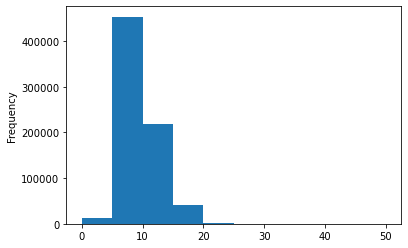

In [55]:
# CLEANING CITIES: EVENTUALLY WILL BE USED TO CREATE AVG WAGE TO REPLACE EXTREME OUTLIER WAGES
# CLEAN UP JOB CITY: distribution of the length of the cities
df["WORKSITE_CITY"].str.len().plot(kind = "hist")

In [56]:
# TOO MANY TO MANUALLY CLEAN: BUT WE WILL TARGET CITIES UNDER 5 CHARECTERS TO SPELL OUT ANY ABR.
df[df["WORKSITE_CITY"].str.len()<5]["WORKSITE_CITY"].unique()

array(['BREA', 'TROY', 'CARY', 'KATY', 'LEHI', 'WEED', 'NOVI', 'LAIE',
       'KENT', 'RENO', 'LULA', 'ERIE', 'YORK', 'STOW', 'OREM', 'NYC',
       'ANZA', 'YIGO', 'ELM', 'APEX', 'WACO', 'ROME', 'MESA', 'HAYS',
       'YUMA', 'KYLE', 'NY', 'ELKO', 'AVON', 'ENID', 'BUDA', 'ELON',
       'YELM', 'NASH', 'NAPA', 'COPE', 'AMES', 'ELBA', 'LUTZ', 'COVE',
       'HILO', 'LYNN', 'FIFE', 'LIMA', 'GARY', 'AGAT', 'LODI', 'PERU',
       'GUAM', 'OMAK', 'HULL', 'ADA', 'ALMA', 'CUBA', 'KRUM', 'RAKE',
       'BEND', 'BELL', 'TAFT', 'POCA', 'RYE', 'TATE', 'RIVA', 'OAKS',
       'VONA', 'LEE', 'KULM', 'BEAR', 'IRMO', 'AZLE', 'OJAI', 'ELMA',
       'HOWE', 'MARS', 'VAIL', 'HOPE', 'ALVA', 'ROY', 'SWEA', 'SACO',
       'ZUNI', 'MOAB', 'POTH', 'KIEL', 'GILL', 'PALA', 'AJO', 'AYER',
       'COOK', 'ROTA', 'WADE', 'TAOS', 'EDEN', 'MACK', 'RAY', 'DYER',
       'ORD', 'AXIS', 'LUSK', 'VEGA', 'CA', 'ELY', 'RTP', 'DUNN', '',
       'DOON', 'BATH', 'NUNN', 'ALTO', 'PACE', 'WALL', 'SPUR', 'WARE',
       'CARO', 'L

In [57]:
# WHAT ARE THE TOP CITIES?
df["WORKSITE_CITY"].value_counts()[:15]

NEW YORK           43046
SEATTLE            22738
SAN FRANCISCO      20135
COLLEGE STATION    18520
REDMOND            16886
MOUNTAIN VIEW      16716
SAN JOSE           16423
SANTA CLARA        12175
CHICAGO            11773
HOUSTON            11616
SUNNYVALE          10925
PLANO               9231
AUSTIN              8013
LOS ANGELES         7802
EDISON              7205
Name: WORKSITE_CITY, dtype: int64

In [58]:
# HOW MANY VARIATIONS OF THE TOP CITIES?
#df[df["WORKSITE_CITY"].str.contains("edison", case = False, na = False)]["WORKSITE_CITY"].value_counts()

In [59]:
# TURNING ALL THE NYC VARATIONS INTO NEW YORK + SPELL OUT NEW YORK
df["WORKSITE_CITY"] =  df["WORKSITE_CITY"].replace("NY","NEW YORK").replace("NYC","NEW YORK")
df.loc[df["WORKSITE_CITY"].str.contains("new york", case = False, na = False), "WORKSITE_CITY"] = "NEW YORK"
# MERGING THE TOP 15 cities (COLLEGE STATION, PLANO DOES NOT NEED CLEANING)
df.loc[df["WORKSITE_CITY"].str.contains("seattle", case = False, na = False), "WORKSITE_CITY"] = "SEATTLE"
df.loc[df["WORKSITE_CITY"].str.contains("san francisco", case = False, na = False), "WORKSITE_CITY"] = "SAN FRANCISCO"
df.loc[df["WORKSITE_CITY"].str.contains("REDMOND", case = False, na = False), "WORKSITE_CITY"] = "REDMOND"
df.loc[df["WORKSITE_CITY"].str.contains("mountain view", case = False, na = False), "WORKSITE_CITY"] = "MOUNTAIN VIEW"
df.loc[df["WORKSITE_CITY"].str.contains("san jose", case = False, na = False), "WORKSITE_CITY"] = "SAN JOSE"
df.loc[df["WORKSITE_CITY"].str.contains("santa clara", case = False, na = False), "WORKSITE_CITY"] = "SANTA CLARA"
df.loc[df["WORKSITE_CITY"].str.contains("chicago", case = False, na = False), "WORKSITE_CITY"] = "CHICAGO"
df.loc[df["WORKSITE_CITY"].str.contains("houston", case = False, na = False), "WORKSITE_CITY"] = "HOUSTON"
df.loc[df["WORKSITE_CITY"].str.contains("sunnyvale", case = False, na = False), "WORKSITE_CITY"] = "SUNNYVALE"
df.loc[df["WORKSITE_CITY"].str.contains("austin/|austin,", case = False, na = False), "WORKSITE_CITY"] = "AUSTIN"
df.loc[df["WORKSITE_CITY"].str.contains("los angeles", case = False, na = False), "WORKSITE_CITY"] = "LOS ANGELES"
df.loc[df["WORKSITE_CITY"].str.contains("edison", case = False, na = False), "WORKSITE_CITY"] = "EDISON"

In [60]:
# HOW MANY STATES ARE APPLICANTS TRYING TO WORK IN? SHOULD BE NO MORE THAN 60...
df["WORKSITE_STATE"].nunique()

114

In [61]:
# CREATING THE MAIN LIST TO TRY AND CLEAN MOST STATES INTO ABBREVIATIONS
mainst= ["Alabama",
"Alaska",
"Arizona",
"Arkansas",
"California",
"Colorado",
"Connecticut",
"Delaware",
"Florida",
"Georgia",
"Hawaii",
"Idaho",
"Illinois",
"Indiana",
"Iowa",
"Kansas",
"Kentucky",
"Louisiana",
"Maine",
"Maryland",
"Massachusetts",
"Michigan",
"Minnesota",
"Mississippi",
"Missouri",
"Montana",
"Nebraska",
"Nevada",
"New Hampshire",
"New Jersey",
"New Mexico",
"New York",
"North Carolina",
"North Dakota",
"Ohio",
"Oklahoma",
"Oregon",
"Pennsylvania",
"Rhode Island",
"South Carolina",
"South Dakota",
"Tennessee",
"Texas",
"Utah",
"Vermont",
"Virginia",
"Washington",
"West Virginia",
"Wisconsin",
"Wyoming",
"District of Columbia"]

In [62]:
# CREATING THE MAIN ABR TO TRY AND CLEAN MOST STATES INTO ABBREVIATIONS
mainabr = ["AL",
"AK",
"AZ",
"AR",
"CA",
"CO",
"CT",
"DE",
"FL",
"GA",
"HI",
"ID",
"IL",
"IN",
"IA",
"KS",
"KY",
"LA",
"ME",
"MD",
"MA",
"MI",
"MN",
"MS",
"MO",
"MT",
"NE",
"NV",
"NH",
"NJ",
"NM",
"NY",
"NC",
"ND",
"OH",
"OK",
"OR",
"PA",
"RI",
"SC",
"SD",
"TN",
"TX",
"UT",
"VT",
"VA",
"WA",
"WV",
"WI",
"WY",
"DC"]

In [63]:
# ROUND 1 CLEANING STATES
for j in range(len(mainst)):
    df.loc[df["WORKSITE_STATE"].str.contains(mainst[j], case = False, na = False), "WORKSITE_STATE"] = mainabr[j]

In [64]:
# HOW MANY STATES ARE THERE NOT ABR AFTER ROUND 1 CLEANING?
df["WORKSITE_STATE"].unique()[np.vectorize(len)(df["WORKSITE_STATE"].unique())>2]

array(['PUERTO RICO', 'GUAM', 'NORTHERN MARIANA ISLANDS',
       'VIRGIN ISLANDS', 'MARSHALL ISLANDS',
       'FEDERATED STATES OF MICRONESIA'], dtype=object)

In [65]:
# CREATING THE SECONDARY LIST TO FINISH CLEANING STATES
secondst = ['PUERTO RICO', 'GUAM', 'NORTHERN MARIANA ISLANDS',
       'VIRGIN ISLANDS', 'MARSHALL ISLANDS',
       'FEDERATED STATES OF MICRONESIA']
secondabr = ["PR","GU","MP","VI","MH","FSM"]
# ROUND 2 CLEANING STATES
for j in range(len(secondst)):
    df.loc[df["WORKSITE_STATE"].str.contains(secondst[j], case = False, na = False), "WORKSITE_STATE"] = secondabr[j]

In [66]:
# CREATING US GEOGRAPHIC REGION: STATE LIST
geostate = ["AK",
"AL",
"AR",
"AZ",
"CA",
"CO",
"CT",
"DC",
"DE",
"FL",
"GA",
"HI",
"IA",
"ID",
"IL",
"IN",
"KS",
"KY",
"LA",
"MA",
"MD",
"ME",
"MI",
"MN",
"MO",
"MS",
"MT",
"NC",
"ND",
"NE",
"NH",
"NJ",
"NM",
"NV",
"NY",
"OH",
"OK",
"OR",
"PA",
"RI",
"SC",
"SD",
"TN",
"TX",
"UT",
"VA",
"VT",
"WA",
"WI",
"WV",
"WY",
"PR",
"GU",
"MP",
"VI",
"MH",
"FSM"]

In [67]:
# CREATING US GEOGRAPHIC REGION: REGION LIST
region= ["WEST",
"SOUTH",
"SOUTH",
"WEST",
"WEST",
"WEST",
"NORTHEAST",
"SOUTH",
"SOUTH",
"SOUTH",
"SOUTH",
"WEST",
"MIDWEST",
"WEST",
"MIDWEST",
"MIDWEST",
"MIDWEST",
"SOUTH",
"SOUTH",
"NORTHEAST",
"SOUTH",
"NORTHEAST",
"MIDWEST",
"MIDWEST",
"MIDWEST",
"SOUTH",
"WEST",
"SOUTH",
"MIDWEST",
"MIDWEST",
"NORTHEAST",
"NORTHEAST",
"WEST",
"WEST",
"NORTHEAST",
"MIDWEST",
"SOUTH",
"WEST",
"NORTHEAST",
"NORTHEAST",
"SOUTH",
"MIDWEST",
"SOUTH",
"SOUTH",
"WEST",
"SOUTH",
"NORTHEAST",
"WEST",
"MIDWEST",
"SOUTH",
"WEST",
"TERRITORY",
"TERRITORY",
"TERRITORY",
"TERRITORY",
"TERRITORY",
"TERRITORY"]

In [68]:
# CREATING A WORKSITE REGION COLUMN
df["WORKSITE_REGION"]=df["WORKSITE_STATE"]
for j in range(len(geostate)):
    df.loc[df["WORKSITE_REGION"].str.contains(geostate[j], case = False, na = False), "WORKSITE_REGION"] = region[j]

In [69]:
# UNIQUE REGIONS (CHECK IF ALL STATES WERE TRANSLATED CORRECTLY)
df["WORKSITE_REGION"].unique()

array(['WEST', 'MIDWEST', 'SOUTH', 'NORTHEAST', 'TERRITORY', ''],
      dtype=object)

In [70]:
# OUTLIER WO_A USING IQR (EXTREME OUTLIER PER YEAR) TOP SIDE
wagetop = df.groupby("YEAR")["WO_A"].quantile(.75) + (df.groupby("YEAR")["WO_A"].quantile(.75)-df.groupby("YEAR")["WO_A"].quantile(.25)) *3
pwtop = df.groupby("YEAR")["PW_A"].quantile(.75) + (df.groupby("YEAR")["PW_A"].quantile(.75)-df.groupby("YEAR")["PW_A"].quantile(.25)) *3

In [71]:
# CREATING LISTS TO CLEAN UP WAGE BASED ON OUTLIERS : TOP END ONLY... DROP BOTTOM 1% (LAWS PROTECTING THE BTM END... MORE LIKELY TOP END IS ERROR)
yr = wagetop.index.tolist()
wagetop = wagetop.tolist()
pwtop = pwtop.tolist()

In [72]:
# FOR LOOP TO GET ALL APPLICANTS WITH WO_A > CUTOFF: BIGWAGE
bigwage = pd.DataFrame()
for x in range(len(yr)):
    j = df[(df["YEAR"] == yr[x])&(df["WO_A"]>wagetop[x])]
    bigwage = pd.concat([bigwage,j])

In [73]:
# GETTING THE REST OF THE APPLICANTS WHO ARE NOT > CUTOFF: REGWAGE
bwlist = bigwage["ID"].tolist()
regwage = df[~df['ID'].isin(bwlist)]

In [74]:
# CREATING A UNIQUE IDENTIFIER TO GET AN AVG WAGE FOR EACH IDENTIFIER TO REPLACE OUTLIER SALARIES
regwage["BID"] = regwage["PW_SOC_CODE"].astype(str)+regwage["WORKSITE_STATE"].astype(str) + regwage["WORKSITE_CITY"].astype(str) + regwage["PW_SKILL_LEVEL"].astype(str)
# IS THIS TOO GRANULAR OF AN AVG? LETS SEE AVG COUNT FOR EACH UNIQUE IDENTIFIER
regwage.groupby("BID")["WO_A"].value_counts().mean()

2.1001117266421487

In [75]:
# NEW IDENTIFIER : USING STATE ONLY
regwage["BID"] = regwage["PW_SOC_CODE"].astype(str)+regwage["WORKSITE_STATE"].astype(str)+ regwage["PW_SKILL_LEVEL"].astype(str)
regwage.groupby("BID")["WO_A"].value_counts().mean()
# STILL ONLY 2.7  APPLICANTS A CODE

2.7672878815180595

In [76]:
# NEW IDENTIFIER : USING REGION ONLY
regwage["BID"] = regwage["PW_SOC_CODE"].astype(str)+regwage["WORKSITE_REGION"].astype(str)+ regwage["PW_SKILL_LEVEL"].astype(str)
regwage.groupby("BID")["WO_A"].value_counts().mean()
# BETTER with 3.3... 

3.304037352375721

In [77]:
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
normwage = pd.DataFrame(regwage.groupby("BID")["WO_A"].mean())
normpw = pd.DataFrame(regwage.groupby("BID")["PW_A"].mean())
normwage.columns=["NORM_WAGE"]
normpw.columns = ["NORM_PW"]

In [78]:
# CREATING THE UNIQUE IDENTIFIER FOR BIG WAGE TO MATCH UP WITH REG WAGE AVG
bigwage["BID"] = bigwage["PW_SOC_CODE"].astype(str)+bigwage["WORKSITE_REGION"].astype(str)+ bigwage["PW_SKILL_LEVEL"].astype(str)

In [79]:
# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchbidwage = bigwage
matchbidwage = matchbidwage.merge(normwage, how = "inner", on = "BID")

In [80]:
# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH BID
len(bigwage) - len(matchbidwage)

35

In [81]:
# LIST THE BIDs THAT DO NOT MATCH IN NORM WAGE: THESE ARE THE BIDs NOT IN THE NORM WAGE...
bwregion = bigwage["BID"].unique().tolist()
normwageregion = normwage.index.tolist()
list(set(bwregion) - set(normwageregion))

['29-1061NORTHEASTLEVEL I',
 '29-1067NORTHEAST',
 '29-1069TERRITORYLEVEL III',
 '29-1069TERRITORYLEVEL I',
 '25-1051WESTLEVEL IV',
 '29-1061NORTHEAST',
 '29-1067SOUTHLEVEL III',
 '29-1061TERRITORYLEVEL III',
 '29-1064NORTHEAST',
 '29-1063SOUTHLEVEL III',
 '29-1022WESTLEVEL III',
 '11-1011SOUTH',
 '29-1064MIDWESTLEVEL IV',
 '29-1061SOUTHLEVEL III',
 '29-1067NORTHEASTLEVEL IV']

In [82]:
# GETTING THE APPLICANTS THAT DID NOT MATCH IN BID for NORM WAGE
nonmatchwage = pd.DataFrame()
for x in range(len(list(set(bwregion) - set(normwageregion)))):
    j = bigwage[bigwage["BID"]==list(set(bwregion) - set(normwageregion))[x]]
    nonmatchwage = pd.concat([nonmatchwage, j],axis = 0)

In [83]:
# DOES THE NUMBER OF APPLICANTS THAT DO NOT MATCH = TO 35?
len(nonmatchwage)
# YES

35

In [84]:
# CORRELATION BETWEEN REGION OR LEVEL WITH WAGE: TO DETERMINE HOW TO ADJUST THE BID
regiondummy = pd.get_dummies(df["WORKSITE_REGION"])
leveldummy = pd.get_dummies(df["PW_SKILL_LEVEL"])

In [85]:
# CORREL BETWEEN REGIONS AND WO_A
pd.concat([regiondummy,df["WO_A"]],axis = 1).corr()["WO_A"]

            -0.002334
MIDWEST     -0.035596
NORTHEAST   -0.000939
SOUTH       -0.015371
TERRITORY   -0.021151
WEST         0.040113
WO_A         1.000000
Name: WO_A, dtype: float64

In [86]:
# CORREL BETWEEN LEVEL AND WO_A
pd.concat([leveldummy,df["WO_A"]],axis = 1).corr()["WO_A"]
# LEVELS LOOK MUCH HIGHER OVERALL 

             0.030534
LEVEL I     -0.140554
LEVEL II    -0.011339
LEVEL III    0.024664
LEVEL IV     0.105982
WO_A         1.000000
Name: WO_A, dtype: float64

In [87]:
# GETTING THE ADJUSTED BID FOR NORM WAGE: ONLY KEEPING LEVELS SINCE IT IS MORE CORREL WITH WAGE THAN REGION
adjregw = regwage
adjregw["BID"] = adjregw["PW_SOC_CODE"].astype(str)+adjregw["PW_SKILL_LEVEL"].astype(str)
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
adjnormwage = pd.DataFrame(adjregw.groupby("BID")["WO_A"].mean())
adjnormwage.columns=["NORM_WAGE"]

# CREATING THE UNIQUE IDENTIFIER FOR MISSING BIG WAGE TO MATCH UP WITH REG WAGE AVG
adjbigwage = nonmatchwage
adjbigwage["BID"] = adjbigwage["PW_SOC_CODE"].astype(str)+ adjbigwage["PW_SKILL_LEVEL"].astype(str)

# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchadjbidwage = adjbigwage
matchadjbidwage = matchadjbidwage.merge(adjnormwage, how = "inner", on = "BID")

# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH AdjBID
len(adjbigwage) - len(matchadjbidwage)

2

In [88]:
# LIST THE Adj BIDs THAT DO NOT MATCH IN NORM WAGE: THESE ARE THE Adj BIDs NOT IN THE NORM WAGE...
adjbwregion = adjbigwage["BID"].unique().tolist()
adjnormwageregion = adjnormwage.index.tolist()
list(set(adjbwregion) - set(adjnormwageregion))

['29-1064LEVEL IV', '25-1051LEVEL IV']

In [89]:
# LIST THE APPLICANTS THAT ARE STILL NOT MATCHED THROUGH BID...
nonmatchadjwage = pd.DataFrame()
for x in range(len(list(set(adjbwregion) - set(adjnormwageregion)))):
    j = adjbigwage[adjbigwage["BID"]==list(set(adjbwregion) - set(adjnormwageregion))[x]]
    nonmatchadjwage = pd.concat([nonmatchadjwage, j],axis = 0)

# DOES THE NUMBER OF APPLICANTS THAT DO NOT MATCH = TO 2?
len(nonmatchadjwage)
# YES

2

In [90]:
# GETTING THE WAGE FOR SOC CODE ONLY FOR NORM WAGE
soconly = regwage
soconly["BID"] = soconly["PW_SOC_CODE"].astype(str)
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
socnormwage = pd.DataFrame(soconly.groupby("BID")["WO_A"].mean())
socnormwage.columns=["NORM_WAGE"]

# CREATING THE UNIQUE IDENTIFIER FOR MISSING BIG WAGE TO MATCH UP WITH REG WAGE AVG
socbigwage = nonmatchadjwage
socbigwage["BID"] = socbigwage["PW_SOC_CODE"].astype(str)

# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchsocbidwage = socbigwage
matchsocbidwage = matchsocbidwage.merge(socnormwage, how = "inner", on = "BID")

# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH AdjBID
len(socbigwage) - len(matchsocbidwage)

0

In [91]:
# MERGING BACK TO MAKE THE FINAL BIG WAGE : USING NORM WAGE...
bigwage = pd.concat([matchbidwage,
matchadjbidwage,
matchsocbidwage],axis = 0, ignore_index = True)
bigwage["WO_A"] = bigwage["NORM_WAGE"]
bigwage = bigwage.drop("NORM_WAGE", axis = 1)

In [92]:
# CLEANING UP THE PW_A
# CREATING THE UNIQUE IDENTIFIER FOR BIG WAGE TO MATCH UP WITH REG WAGE AVG
bigwage["BID"] = bigwage["PW_SOC_CODE"].astype(str)+bigwage["WORKSITE_REGION"].astype(str)+ bigwage["PW_SKILL_LEVEL"].astype(str)

In [93]:
# MERGING BASED ON BID AND BRINGING IN NORM PW
matchbidwage = bigwage
matchbidwage = matchbidwage.merge(normpw, how = "inner", on = "BID")

In [94]:
# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH BID
len(bigwage) - len(matchbidwage)

35

In [95]:
# LIST THE BIDs THAT DO NOT MATCH IN NORM WAGE: THESE ARE THE BIDs NOT IN THE NORM WAGE...
bwregion = bigwage["BID"].unique().tolist()
normwageregion = normpw.index.tolist()
list(set(bwregion) - set(normwageregion))

['29-1061NORTHEASTLEVEL I',
 '29-1067NORTHEAST',
 '29-1069TERRITORYLEVEL III',
 '29-1069TERRITORYLEVEL I',
 '29-1067SOUTHLEVEL III',
 '29-1061NORTHEAST',
 '25-1051WESTLEVEL IV',
 '29-1061TERRITORYLEVEL III',
 '29-1064NORTHEAST',
 '29-1063SOUTHLEVEL III',
 '29-1022WESTLEVEL III',
 '11-1011SOUTH',
 '29-1064MIDWESTLEVEL IV',
 '29-1061SOUTHLEVEL III',
 '29-1067NORTHEASTLEVEL IV']

In [96]:
# GETTING THE APPLICANTS THAT DID NOT MATCH IN BID for NORM PW
nonmatchwage = pd.DataFrame()
for x in range(len(list(set(bwregion) - set(normwageregion)))):
    j = bigwage[bigwage["BID"]==list(set(bwregion) - set(normwageregion))[x]]
    nonmatchwage = pd.concat([nonmatchwage, j],axis = 0)

In [97]:
# DOES THE NUMBER OF APPLICANTS THAT DO NOT MATCH = TO 35?
len(nonmatchwage)
# YES

35

In [98]:
# GETTING THE ADJUSTED BID FOR NORM PW: ONLY KEEPING LEVELS SINCE IT IS MORE CORREL WITH WAGE THAN REGION
adjregw = regwage
adjregw["BID"] = adjregw["PW_SOC_CODE"].astype(str)+adjregw["PW_SKILL_LEVEL"].astype(str)
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
adjnormwage = pd.DataFrame(adjregw.groupby("BID")["PW_A"].mean())
adjnormwage.columns=["NORM_PW"]

# CREATING THE UNIQUE IDENTIFIER FOR MISSING BIG WAGE TO MATCH UP WITH REG WAGE AVG
adjbigwage = nonmatchwage
adjbigwage["BID"] = adjbigwage["PW_SOC_CODE"].astype(str)+ adjbigwage["PW_SKILL_LEVEL"].astype(str)

# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchadjbidwage = adjbigwage
matchadjbidwage = matchadjbidwage.merge(adjnormwage, how = "inner", on = "BID")

# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH AdjBID
len(adjbigwage) - len(matchadjbidwage)

2

In [99]:
# LIST THE Adj BIDs THAT DO NOT MATCH IN NORM WAGE: THESE ARE THE Adj BIDs NOT IN THE NORM WAGE...
adjbwregion = adjbigwage["BID"].unique().tolist()
adjnormwageregion = adjnormwage.index.tolist()
list(set(adjbwregion) - set(adjnormwageregion))

['29-1064LEVEL IV', '25-1051LEVEL IV']

In [100]:
# LIST THE APPLICANTS THAT ARE STILL NOT MATCHED THROUGH BID...
nonmatchadjwage = pd.DataFrame()
for x in range(len(list(set(adjbwregion) - set(adjnormwageregion)))):
    j = adjbigwage[adjbigwage["BID"]==list(set(adjbwregion) - set(adjnormwageregion))[x]]
    nonmatchadjwage = pd.concat([nonmatchadjwage, j],axis = 0)

# DOES THE NUMBER OF APPLICANTS THAT DO NOT MATCH = TO 2?
len(nonmatchadjwage)
# YES

2

In [101]:
# GETTING THE WAGE FOR SOC CODE ONLY FOR NORM WAGE
soconly = regwage
soconly["BID"] = soconly["PW_SOC_CODE"].astype(str)
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
socnormwage = pd.DataFrame(soconly.groupby("BID")["PW_A"].mean())
socnormwage.columns=["NORM_PW"]

# CREATING THE UNIQUE IDENTIFIER FOR MISSING BIG WAGE TO MATCH UP WITH REG WAGE AVG
socbigwage = nonmatchadjwage
socbigwage["BID"] = socbigwage["PW_SOC_CODE"].astype(str)

# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchsocbidwage = socbigwage
matchsocbidwage = matchsocbidwage.merge(socnormwage, how = "inner", on = "BID")

# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH AdjBID
len(socbigwage) - len(matchsocbidwage)

0

In [102]:
# MERGING BACK TO MAKE THE FINAL BIG WAGE : USING NORM WAGE...
bigwage = pd.concat([matchbidwage,
matchadjbidwage,
matchsocbidwage],axis = 0, ignore_index = True)
bigwage["PW_A"] = bigwage["NORM_PW"]
bigwage = bigwage.drop(["BID","NORM_PW"], axis = 1)

In [103]:
# MATCH APPLICATIONS IN BIGWAGE DF WITH ORIGINAL DF AND UPDATE WAGE AND PW DATA
bigwage = bigwage.set_index("ID")
df = df.set_index("ID")
df.loc[bigwage.index] = bigwage
df = df.reset_index()

In [104]:
# ANNUALIZED WAGE OFFER - ANNUALIZED PW: REDO, WITH CLEANED UP ANNUAL WAGE AND PW
df["WO-PW"] = df["WO_A"] - df["PW_A"]

In [105]:
# CLEANING UP DAYS TO DECIDE
# IQR EXTREME OUTLIER... SINCE WE HAVE NO IDEA IF AN APPLICANT TOOK THAT LONG, WE CANNOT NORMALIZE IT
# DROP THE OUTLIERS ABOVE 99.5%
ddtop = df.groupby("YEAR")["DAYS_TO_DECIDE"].quantile(.995)
ddtop

YEAR
2014    1156.600
2015    1484.215
2016    1501.000
2017    2063.065
2018    1718.230
2019     953.040
2020     531.000
2021     603.000
Name: DAYS_TO_DECIDE, dtype: float64

In [106]:
# NEW COLUMN TO DROP
ddcutoff = ddtop.tolist()
for x in range(len(yr)):
    df["drop"] = np.where((df["YEAR"]==yr[x])&(df["DAYS_TO_DECIDE"]>=ddcutoff[x]),"DROP",np.nan)

In [107]:
# HOW MANY ARE WE DROPPING?
(df["drop"]=="DROP").sum()

448

In [108]:
# DROPPING ALL DAYS TO DECIDE > 99 PERCENTILE
df = df[df["drop"]!="DROP"].drop("drop",axis = 1).reset_index(drop = True)

<AxesSubplot:ylabel='Frequency'>

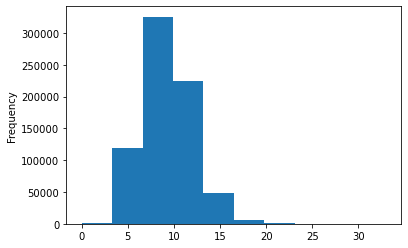

In [109]:
# CLEANING EMPLOYER HQ CITIES
# CLEAN UP JOB CITY: distribution of the length of the cities
df["EMPLOYER_CITY"].str.len().plot(kind = "hist")

In [110]:
# TOO MANY TO MANUALLY CLEAN: 
# WHAT ARE THE TOP CITIES?
df["EMPLOYER_CITY"].value_counts()[:15]

NEW YORK           41027
SEATTLE            24503
MOUNTAIN VIEW      21400
SANTA CLARA        21071
COLLEGE STATION    19646
SAN FRANCISCO      18346
SAN JOSE           18132
REDMOND            17900
CHICAGO            15303
SUNNYVALE          11825
HOUSTON            10288
PLANO               8653
CUPERTINO           7894
EDISON              7299
MENLO PARK          7258
Name: EMPLOYER_CITY, dtype: int64

In [111]:
# HOW MANY VARIATIONS OF THE TOP CITIES?
#df[df["EMPLOYER_CITY"].str.contains("mountain view", case = False, na = False)]["EMPLOYER_CITY"].value_counts()

In [112]:
# TURNING ALL THE NYC VARATIONS INTO NEW YORK + SPELL OUT NEW YORK
df["EMPLOYER_CITY"] =  df["EMPLOYER_CITY"].replace("NY","NEW YORK").replace("NYC","NEW YORK")
df.loc[df["EMPLOYER_CITY"].str.contains("new york", case = False, na = False), "EMPLOYER_CITY"] = "NEW YORK"
# MERGING THE TOP 15 cities (santa clara, COLLEGE STATION,redmond, cupertino, menlo park, and PLANO did NOT NEED CLEANING)
df.loc[df["EMPLOYER_CITY"].str.contains("seattle", case = False, na = False), "EMPLOYER_CITY"] = "SEATTLE"
df.loc[df["EMPLOYER_CITY"].str.contains("san francisco", case = False, na = False), "EMPLOYER_CITY"] = "SAN FRANCISCO"
df.loc[df["EMPLOYER_CITY"].str.contains("san jose", case = False, na = False), "EMPLOYER_CITY"] = "SAN JOSE"
df.loc[df["EMPLOYER_CITY"].str.contains("chicago", case = False, na = False), "EMPLOYER_CITY"] = "CHICAGO"
df.loc[df["EMPLOYER_CITY"].str.contains("houston", case = False, na = False), "EMPLOYER_CITY"] = "HOUSTON"
df.loc[df["EMPLOYER_CITY"].str.contains("sunnyvale", case = False, na = False), "EMPLOYER_CITY"] = "SUNNYVALE"
df.loc[df["EMPLOYER_CITY"].str.contains("los angeles", case = False, na = False), "EMPLOYER_CITY"] = "LOS ANGELES"
df.loc[df["EMPLOYER_CITY"].str.contains("edison", case = False, na = False), "EMPLOYER_CITY"] = "EDISON"

In [113]:
# HOW MANY STATES ARE EMPLOYERS HQ IN? SHOULD BE NO MORE THAN 60...
df["EMPLOYER_STATE_PROVINCE"].nunique()
# ... 1157

1152

In [114]:
# ROUND 1 CLEANING STATES
for j in range(len(mainst)):
    df.loc[df["EMPLOYER_STATE_PROVINCE"].str.contains(mainst[j], case = False, na = False), "EMPLOYER_STATE_PROVINCE"] = mainabr[j]

In [115]:
# HOW MANY STATES ARE THERE NOT ABR AFTER ROUND 1 CLEANING?
df["EMPLOYER_STATE_PROVINCE"].unique()[np.vectorize(len)(df["EMPLOYER_STATE_PROVINCE"].unique())>2]

array(['PUERTO RICO', 'GUAM', 'NORTHERN MARIANA ISLANDS',
       'NORTHERN MARIANA ISLANDS CNMI', ' PR', 'GUAM ', 'GUAM GUAM',
       'NORTHERN MARIANA ISLANDS SAIPAN INTERNATIONAL SCHOOL',
       'VIRGIN ISLANDS ABC SALES & SERVICES', 'VIRGIN ISLANDS ST. CROIX',
       ' FL 32773', ' FL BUILDIN',
       'NORTHERN MARIANA ISLANDS NORTHERN MARIANA ISLANDS',
       'VIRGIN ISLANDS', 'PUERTO RICO PUERTO RICO', ' OR OR',
       'VIRGIN ISLANDS ST CROIX', 'PUERTO RICO PR',
       'NORTHERN MARIANA ISLANDS NORTHERN MARIANA ISLAND',
       'FEDERATED STATES OF MICRONESIA', 'BRITISH COLUMBIA'], dtype=object)

In [116]:
df["EMPLOYER_STATE_PROVINCE"].unique()[np.vectorize(len)(df["EMPLOYER_STATE_PROVINCE"].unique())>2].tolist()

['PUERTO RICO',
 'GUAM',
 'NORTHERN MARIANA ISLANDS',
 'NORTHERN MARIANA ISLANDS CNMI',
 ' PR',
 'GUAM ',
 'GUAM GUAM',
 'NORTHERN MARIANA ISLANDS SAIPAN INTERNATIONAL SCHOOL',
 'VIRGIN ISLANDS ABC SALES & SERVICES',
 'VIRGIN ISLANDS ST. CROIX',
 ' FL 32773',
 ' FL BUILDIN',
 'NORTHERN MARIANA ISLANDS NORTHERN MARIANA ISLANDS',
 'VIRGIN ISLANDS',
 'PUERTO RICO PUERTO RICO',
 ' OR OR',
 'VIRGIN ISLANDS ST CROIX',
 'PUERTO RICO PR',
 'NORTHERN MARIANA ISLANDS NORTHERN MARIANA ISLAND',
 'FEDERATED STATES OF MICRONESIA',
 'BRITISH COLUMBIA']

In [117]:
# CREATING THE SECONDARY LIST TO FINISH CLEANING STATES
secondst = ['PUERTO RICO', 'GUAM', 'NORTHERN MARIANA ISLANDS',
       'VIRGIN ISLANDS', 'MARSHALL ISLANDS',
       'FEDERATED STATES OF MICRONESIA'," PR","FL 32773","FL BUILDIN","OR OR","BRITISH COLUMBIA"]
secondabr = ["PR","GU","MP","VI","MH","FSM","PR","FL","FL","OR","BC"]
# ROUND 2 CLEANING STATES
for j in range(len(secondst)):
    df.loc[df["EMPLOYER_STATE_PROVINCE"].str.contains(secondst[j], case = False, na = False), "EMPLOYER_STATE_PROVINCE"] = secondabr[j]

In [118]:
# CREATING A WORKSITE REGION COLUMN
df["EMPLOYER_REGION"]=df["EMPLOYER_STATE_PROVINCE"]
for j in range(len(geostate)):
    df.loc[df["EMPLOYER_REGION"].str.contains(geostate[j], case = False, na = False), "EMPLOYER_REGION"] = region[j]


In [119]:
# UNIQUE REGIONS (CHECK IF ALL STATES WERE TRANSLATED CORRECTLY)
df["EMPLOYER_REGION"] = df["EMPLOYER_REGION"].replace("BC","OTHER")
df["EMPLOYER_REGION"].unique()

array(['WEST', 'MIDWEST', 'SOUTH', 'NORTHEAST', 'TERRITORY', '', 'OTHER'],
      dtype=object)

In [120]:
# ADDING A CATEGORICAL VARIABLE OF DISCREPANCY BETWEEN EMPLOYER HQ STATE , REGION, AND CITY WITH JOB WORK SITE. UNIT OF WAGE AS WELL
df["DISC_ST"] = np.where(df["EMPLOYER_STATE_PROVINCE"]==df["WORKSITE_STATE"], 0, 1)
df["DISC_CTY"] = np.where(df["EMPLOYER_CITY"]==df["WORKSITE_CITY"], 0, 1)
df["DISC_RGION"] = np.where(df["EMPLOYER_REGION"]==df["WORKSITE_REGION"], 0, 1)
df["DISC_UNIT"] = np.where(df["WAGE_OFFER_UNIT_OF_PAY"]==df["PW_UNIT_OF_PAY"], 0, 1)

In [121]:
# MANUAL CLEANING OF EMPLOYER NAMES: THIS CODE IS TAKEN FROM THE US IMMIGRANT EMPLOYEMENT MINIPROJECT IN MY GITHUB
df.loc[df["EMPLOYER_NAME"].str.contains("GOOGLE", case = False, na = False),"EMPLOYER_NAME"]="GOOGLE"
df.loc[(df["EMPLOYER_NAME"].str.contains("amazon |amazon.com", case = False, na = False))&(~df["EMPLOYER_NAME"].str.contains("amazon conservation team|amazon stones", case = False, na = False)), "EMPLOYER_NAME"] = "AMAZON"
df.loc[df["EMPLOYER_NAME"].str.contains("MICROSOFT", case = False, na = False), "EMPLOYER_NAME"] = "MICROSOFT"
df.loc[df["EMPLOYER_NAME"].str.contains("Cognizant", case = False, na = False), "EMPLOYER_NAME"] = "COGNIZANT"
df.loc[df["EMPLOYER_NAME"].str.contains("intel corporation|intel mobile|intel massachusetts|intel america|intel federal", case = False, na = False), "EMPLOYER_NAME"] = "INTEL"
df.loc[df["EMPLOYER_NAME"].str.contains("apple inc.|apple computer|apple educational", case = False, na = False), "EMPLOYER_NAME"] = "APPLE"
df.loc[df["EMPLOYER_NAME"].str.contains("infosys ltd.|infosys technologies|infosys public|infosys solutions|infosys consulting|infosys international|infosys BPO", case = False, na = False), "EMPLOYER_NAME"] = "INFOSYS"
df.loc[df["EMPLOYER_NAME"].str.contains("facebook", case = False, na = False), "EMPLOYER_NAME"] = "FACEBOOK"
df.loc[df["EMPLOYER_NAME"].str.contains("tata consultancy|tata technologies|tata communications|tata industries|tata consltancy|tata enterprises|tata america international|tata autocomp|tata international metals|tata chemicals|tata elxsi", case = False, na = False), "EMPLOYER_NAME"] = "TATA"
df.loc[df["EMPLOYER_NAME"].str.contains("oracle america|oracle usa|oracle financial", case = False, na = False), "EMPLOYER_NAME"] = "FACEBOOK"
df.loc[df["EMPLOYER_NAME"].str.contains("hcl america", case = False, na = False), "EMPLOYER_NAME"] = "HCL AMERICA"
df.loc[df["EMPLOYER_NAME"].str.contains("deloitte", case = False, na = False), "EMPLOYER_NAME"] = "DELOITTE"
df.loc[df["EMPLOYER_NAME"].str.contains("qualcomm", case = False, na = False), "EMPLOYER_NAME"] = "QUALCOMM"
df.loc[df["EMPLOYER_NAME"].str.contains("IBM ", case = False, na = False), "EMPLOYER_NAME"] = "IBM"
df.loc[df["EMPLOYER_NAME"].str.contains("Cisco systems|cisco consumer", case = False, na = False), "EMPLOYER_NAME"] = "CISCO"
df.loc[df["EMPLOYER_NAME"].str.contains("salesforce", case = False, na = False), "EMPLOYER_NAME"] = "SALESFORCE"
df.loc[df["EMPLOYER_NAME"].str.contains("morgan stanley", case = False, na = False), "EMPLOYER_NAME"] = "MORGAN STANLEY"
df.loc[df["EMPLOYER_NAME"].str.contains("JP Morgan", case = False, na = False), "EMPLOYER_NAME"] = "JP MORGAN"
df.loc[df["EMPLOYER_NAME"].str.contains("goldman sachs|goldman, sachs|goldman,sachs", case = False, na = False), "EMPLOYER_NAME"] = "GOLDMAN SACHS"
df.loc[df["EMPLOYER_NAME"].str.contains("MERRILL LYNCH", case = False, na = False), "EMPLOYER_NAME"] = "MERRILL LYNCH"
df.loc[df["EMPLOYER_NAME"].str.contains("Citibank|citigroup", case = False, na = False), "EMPLOYER_NAME"] = "CITI GROUP"
df.loc[df["EMPLOYER_NAME"].str.contains("CREDIT SUISSE", case = False, na = False), "EMPLOYER_NAME"] = "CREDIT SUISSE"
df.loc[df["EMPLOYER_NAME"].str.contains("pricewater|pwc", case = False, na = False), "EMPLOYER_NAME"] = "PRICEWATERHOUSECOOPERS"
df.loc[df["EMPLOYER_NAME"].str.contains("ernst  |ernst & Young", case = False, na = False), "EMPLOYER_NAME"] = "ERNST YOUNG"
df.loc[df["EMPLOYER_NAME"].str.contains("capgemini", case = False, na = False), "EMPLOYER_NAME"] = "CAPGEMINI"
df.loc[df["EMPLOYER_NAME"].str.contains("technip usa", case = False, na = False), "EMPLOYER_NAME"] = "TECHNIP USA"
df.loc[df["EMPLOYER_NAME"].str.contains("bechtel ", case = False, na = False), "EMPLOYER_NAME"] = "BECHTEL"
df.loc[(df["EMPLOYER_NAME"].str.contains("hp enterprise services|hp inc.|Hewlett-|Hewlett P|HewlettP", case = False, na = False))&(~df["EMPLOYER_NAME"].str.contains("queen nails hp inc|backer ehp inc", case = False, na = False)), "EMPLOYER_NAME"] = "AMAZON"
df.loc[df["EMPLOYER_NAME"].str.contains("CGGVERITAS", case = False, na = False), "EMPLOYER_NAME"] = "CGGVERITAS"
df.loc[df["EMPLOYER_NAME"].str.contains("national oilwell", case = False, na = False), "EMPLOYER_NAME"] = "NATIONAL OILWELL VARCO"
df.loc[df["EMPLOYER_NAME"].str.contains("IH SERVICES", case = False, na = False), "EMPLOYER_NAME"] = "IH SERVICES"
df.loc[df["EMPLOYER_NAME"].str.contains("paypal", case = False, na = False), "EMPLOYER_NAME"] = "PAYPAL"
df.loc[df["EMPLOYER_NAME"].str.contains("EBAY INC.|EBAY INC|EBAY ENTERPRISE|EBAY MOBILE LABS| EBAY PAYMENTS", case = False, na = False), "EMPLOYER_NAME"] = "EBAY"
df.loc[df["EMPLOYER_NAME"].str.contains("brocade", case = False, na = False), "EMPLOYER_NAME"] = "BROCADE"
df.loc[df["EMPLOYER_NAME"].str.contains("ADOBE INC.|ADOBE SYSTEMS", case = False, na = False), "EMPLOYER_NAME"] = "ADOBE"
df.loc[df["EMPLOYER_NAME"].str.contains("University of Chicago", case = False, na = False), "EMPLOYER_NAME"] = "THE UNIVERSITY OF CHICAGO"
df.loc[df["EMPLOYER_NAME"].str.contains("mckinsey", case = False, na = False), "EMPLOYER_NAME"] = "MCKINSEY COMPANY"
df.loc[df["EMPLOYER_NAME"].str.contains("motorola", case = False, na = False), "EMPLOYER_NAME"] = "MOTOROLA"
df.loc[df["EMPLOYER_NAME"].str.contains("citadel LLC|citadel americas|citadel Securities|citadel investment|citadel enterprise", case = False, na = False), "EMPLOYER_NAME"] = "CITADEL LLC"
df.loc[df["EMPLOYER_NAME"].str.contains("yahoo", case = False, na = False), "EMPLOYER_NAME"] = "YAHOO"
df.loc[df["EMPLOYER_NAME"].str.contains("Juniper networks", case = False, na = False), "EMPLOYER_NAME"] = "JUNIPER NETWORKS"
df.loc[df["EMPLOYER_NAME"].str.contains("a2z development", case = False, na = False), "EMPLOYER_NAME"] = "A2Z DEVELOPMENT"
df.loc[df["EMPLOYER_NAME"].str.contains("walmart|wal-mart", case = False, na = False), "EMPLOYER_NAME"] = "WALMART"
df.loc[df["EMPLOYER_NAME"].str.contains("fortinet", case = False, na = False), "EMPLOYER_NAME"] = "FORTINET"
df.loc[df["EMPLOYER_NAME"].str.contains("larsen &|larsen  ", case = False, na = False), "EMPLOYER_NAME"] = "LARSEN TOUBRO"
df.loc[df["EMPLOYER_NAME"].str.contains("mindtree", case = False, na = False), "EMPLOYER_NAME"] = "MINDTREE LIMITED"
df.loc[df["EMPLOYER_NAME"].str.contains("igate tech|igate mastech|igate global", case = False, na = False), "EMPLOYER_NAME"] = "IGATE TECHNOLOGIES"
df.loc[df["EMPLOYER_NAME"].str.contains("3i info", case = False, na = False), "EMPLOYER_NAME"] = "3I INFOTECH"
df.loc[df["EMPLOYER_NAME"].str.contains("NTT Data", case = False, na = False), "EMPLOYER_NAME"] = "NTT DATA"
df.loc[df["EMPLOYER_NAME"].str.contains("Texas instrument", case = False, na = False), "EMPLOYER_NAME"] = "TEXAS INSTRUMENTS"
df.loc[df["EMPLOYER_NAME"].str.contains("tech mahindra", case = False, na = False), "EMPLOYER_NAME"] = "TECH MAHINDRA"
df.loc[df["EMPLOYER_NAME"].str.contains("DELL USA LP|DELL PRODUCTS LP|DELL MARKETING LP|DELL SOFTWARE INC|DELL FINANCIAL", case = False, na = False), "EMPLOYER_NAME"] = "DELL"
df.loc[df["EMPLOYER_NAME"].str.contains("uber technologies", case = False, na = False), "EMPLOYER_NAME"] = "UBER TECHNOLOGIES"
df.loc[df["EMPLOYER_NAME"].str.contains("case farms", case = False, na = False), "EMPLOYER_NAME"] = "CASE FARMS"
df.loc[df["EMPLOYER_NAME"].str.contains("house of raeford", case = False, na = False), "EMPLOYER_NAME"] = "HOUSE OF RAEFORD FARMS"
df.loc[df["EMPLOYER_NAME"].str.contains("george's processing", case = False, na = False), "EMPLOYER_NAME"] = "GEORGE'S PROCESSING"
df.loc[df["EMPLOYER_NAME"].str.contains("abbyland", case = False, na = False), "EMPLOYER_NAME"] = "ABBYLAND FOODS"
df.loc[df["EMPLOYER_NAME"].str.contains("koch foods of cinc", case = False, na = False), "EMPLOYER_NAME"] = "KOCH FOODS OF CINCINNATI"
df.loc[df["EMPLOYER_NAME"].str.contains("koch foods of al", case = False, na = False), "EMPLOYER_NAME"] = "KOCH FOODS OF ALABAMA"


In [124]:
# CREATING THE LIST OF COLUMNS THAT NEED CLEANING UP: "Y" OR "N" INTO 1 or 0
Y_N_cols = ["REFILE",
"REQUIRED_TRAINING",
"REQUIRED_EXPERIENCE",
"ACCEPT_FOREIGN_EDUCATION",
"ACCEPT_ALT_OCCUPATION",
"JOB_OPP_REQUIREMENTS_NORMAL",
"FOREIGN_LANGUAGE_REQUIRED",
"PROFESSIONAL_OCCUPATION",
"APP_FOR_COLLEGE_U_TEACHER",
"SUNDAY_EDITION_NEWSPAPER",
"SECOND_ADVERTISEMENT",
"JOB_FAIR",
"ON_CAMPUS_RECRUITING",
"EMPLOYER_WEBSITE",
"PRO_ORG_AD",
"JOB_SEARCH_WEBSITE",
"EMPLOYEE_REF_PROG",
"CAMPUS_PLACEMENT",
"LOCAL_ETHNIC_PAPER",
"RADIO_TV_AD",
"EMP_RECEIVED_PAYMENT",
"BARGAINING_REP_NOTIFIED",
"POSTED_NOTICE_AT_WORKSITE",
"LAYOFF_IN_PAST_SIX_MONTHS",
"US_WORKERS_CONSIDERED",
"FOREIGN_WORKER_TRAINING_COMP",
"FOREIGN_WORKER_REQ_EXPERIENCE",
"FOREIGN_WORKER_ALT_ED_EXP",
"FOREIGN_WORKER_ALT_OCC_EXP",
"EMPLOYER_COMPLETED_APPLICATION"]

In [125]:
# CHECKING WHAT THE MAX UNIQUE VALUES ARE FOR THE FIELDS WITH "Y" AND "N": THIS SHOULD BE NO MORE THAN 4 (Y,N,NA,Blank)
exlist = []
edf = pd.DataFrame()
for i in range(len(Y_N_cols)):
    j = df[Y_N_cols[i]].nunique()
    x = pd.DataFrame([Y_N_cols[i],j]).transpose()
    edf = pd.concat([edf,x])
edf

,0,1
0,REFILE,3
0,REQUIRED_TRAINING,3
0,REQUIRED_EXPERIENCE,3
0,ACCEPT_FOREIGN_EDUCATION,3
0,ACCEPT_ALT_OCCUPATION,45298
0,JOB_OPP_REQUIREMENTS_NORMAL,3
0,FOREIGN_LANGUAGE_REQUIRED,3
0,PROFESSIONAL_OCCUPATION,3
0,APP_FOR_COLLEGE_U_TEACHER,3
0,SUNDAY_EDITION_NEWSPAPER,3


In [126]:
# LOOKING INTO ACCEPT_ALT_OCCUPATION
df["ACCEPT_ALT_OCCUPATION"].value_counts()
# LOOKS LIKE SOME APPLICANTS HAVE Y AND N WHILE OTHERS WRITE THE ACCEPTED OCCUPATION...

Y                                                                257303
                                                                 198132
N                                                                129719
Computer Science, Engineering or related technical field           2017
Engineering, Mathematics, or a related field                       1935
                                                                  ...  
HISTORY OR EQUIVALENT (SEE H.14)                                      1
Theology or Educational Leadership                                    1
Bus Admin, Econ, or a related field.                                  1
Manufacturing Engineering, or in a related field of study             1
Business Administration, Business and Commerce, or its equiv.         1
Name: ACCEPT_ALT_OCCUPATION, Length: 45298, dtype: int64

In [129]:
# GETTING A LIST TO RUN A LOOP AND FIND ALL THE UNIQUES FOR EACH COLUMN, EXCEPT FOR ALT_OCCUPATION
new_Y_N_cols = ["REFILE",
"REQUIRED_TRAINING",
"REQUIRED_EXPERIENCE",
"ACCEPT_FOREIGN_EDUCATION",
"JOB_OPP_REQUIREMENTS_NORMAL",
"FOREIGN_LANGUAGE_REQUIRED",
"PROFESSIONAL_OCCUPATION",
"APP_FOR_COLLEGE_U_TEACHER",
"SUNDAY_EDITION_NEWSPAPER",
"SECOND_ADVERTISEMENT",
"JOB_FAIR",
"ON_CAMPUS_RECRUITING",
"EMPLOYER_WEBSITE",
"PRO_ORG_AD",
"JOB_SEARCH_WEBSITE",
"EMPLOYEE_REF_PROG",
"CAMPUS_PLACEMENT",
"LOCAL_ETHNIC_PAPER",
"RADIO_TV_AD",
"EMP_RECEIVED_PAYMENT",
"BARGAINING_REP_NOTIFIED",
"POSTED_NOTICE_AT_WORKSITE",
"LAYOFF_IN_PAST_SIX_MONTHS",
"US_WORKERS_CONSIDERED",
"FOREIGN_WORKER_TRAINING_COMP",
"FOREIGN_WORKER_REQ_EXPERIENCE",
"FOREIGN_WORKER_ALT_ED_EXP",
"FOREIGN_WORKER_ALT_OCC_EXP",
"EMPLOYER_COMPLETED_APPLICATION"]

In [130]:
# CHECKING THE UNIQUE VALUES ARE FOR THE FIELDS WITH "Y" AND "N": THIS SHOULD BE NO MORE THAN 4 (Y,N,NA,Blank)
exlist = []
edf = pd.DataFrame()
for i in range(len(new_Y_N_cols)):
    j = df[new_Y_N_cols[i]].nunique()
    a = df[new_Y_N_cols[i]].unique()
    x = pd.DataFrame([new_Y_N_cols[i],j,a]).transpose()
    edf = pd.concat([edf,x])
edf

,0,1,2
0,REFILE,3,"[N, Y, ]"
0,REQUIRED_TRAINING,3,"[N, Y, ]"
0,REQUIRED_EXPERIENCE,3,"[Y, N, ]"
0,ACCEPT_FOREIGN_EDUCATION,3,"[Y, N, ]"
0,JOB_OPP_REQUIREMENTS_NORMAL,3,"[Y, N, ]"
0,FOREIGN_LANGUAGE_REQUIRED,3,"[N, Y, ]"
0,PROFESSIONAL_OCCUPATION,3,"[N, Y, ]"
0,APP_FOR_COLLEGE_U_TEACHER,3,"[N, Y, ]"
0,SUNDAY_EDITION_NEWSPAPER,3,"[Y, , N]"
0,SECOND_ADVERTISEMENT,2,"[Y, N]"


In [131]:
# CHANGING "Y" TO 1, N to 0, A to 0, and "" to 0
for i in range(len(new_Y_N_cols)):
    df[new_Y_N_cols[i]] = np.where(df[new_Y_N_cols[i]]=="Y", 1, 0)

In [132]:
# CHANGING ALT OCCUPATION Y to 1, N to 0, "" to 0, anything else will be a 1
df["ACCEPT_ALT_OCCUPATION"] = np.where(df["ACCEPT_ALT_OCCUPATION"]=="Y", 1, df["ACCEPT_ALT_OCCUPATION"])
df["ACCEPT_ALT_OCCUPATION"] = np.where((df["ACCEPT_ALT_OCCUPATION"]=="N")|(df["ACCEPT_ALT_OCCUPATION"]==""), 0, df["ACCEPT_ALT_OCCUPATION"])
df["ACCEPT_ALT_OCCUPATION"] = np.where(df["ACCEPT_ALT_OCCUPATION"]!=0, 1, df["ACCEPT_ALT_OCCUPATION"])

In [133]:
# DROP THE COLUMNS NOT IN USE
df = df.drop(["ID","CASE_NUMBER","DECISION_DATE","RECEIVED_DATE"], axis = 1).reset_index(drop = True)

In [134]:
# TURN ALL "" TO NP.NAN
df = df.replace("",np.nan)

In [ ]:
############################################################

In [135]:
########## EDA ##########

In [136]:
### EMPLOYER RELATED DATA ###

In [137]:
# TURNING EMPLOYER EMPLOYEE NUMBER, "" INTO 0, THIS WILL ALLOW FOR EASIER CLEANING
df["EMPLOYER_NUM_EMPLOYEES"] = df["EMPLOYER_NUM_EMPLOYEES"].replace(np.nan,0)

In [138]:
# CLEANING UP APPLICANT DATA BASED ON FREQUENCY OF EMPLOYER SPONSORSHIP...
# IF AN EMPLOYER ONLY HAS 1 APPLICANT EVER, PROBABLY WILL NOT SPONSOR AGAIN - COMPARED TO COMPANIES THAT SPONSOR FREQUENTLY
# HOW MANY EMPLOYERS HAVE SPONSORED ONLY ONCE? NOT COMPLETELY ACCURATE DUE TO LACK OF STANDARDIZATION RULES
print("There are around",(df["EMPLOYER_NAME"].value_counts()==1).sum(),"companies that have only sponsored one applicant.")
print("There are a total of",len(df["EMPLOYER_NAME"].value_counts()),"unique companies in the entire dataset.")
print("Dropping companies with only 1 applicant would be",round(((df["EMPLOYER_NAME"].value_counts()==1).sum()/len(df["EMPLOYER_NAME"].value_counts()))*100,2),"% of all companies.")
print("There would be",df["EMPLOYER_NAME"].value_counts()[df["EMPLOYER_NAME"].value_counts()>1].sum(),"applicants left out of",len(df),"in the entire dataset, or dropping",round((len(df)-df["EMPLOYER_NAME"].value_counts()[df["EMPLOYER_NAME"].value_counts()>1].sum())/len(df)*100,2),"%.")

There are around 71228 companies that have only sponsored one applicant.
There are a total of 115341 unique companies in the entire dataset.
Dropping companies with only 1 applicant would be 61.75 % of all companies.
There would be 654998 applicants left out of 726229 in the entire dataset, or dropping 9.81 %.


In [139]:
# BEFORE WE DROP, WHATS THE SUCCESS % OF THESE APPLICANTS?
# CREATE A DF WITH ONLY APPLICANTS TO COMPANIES THAT HAVE SPONSORED ONLY 1 APPLICANT
onlyone = df["EMPLOYER_NAME"].value_counts()[df["EMPLOYER_NAME"].value_counts()<=1].index.tolist()
onlyonedf = df[df["EMPLOYER_NAME"].isin(onlyone)]

In [140]:
# SUCCESS RATE OF APPLICANTS SPONSORED BY COMPANIES THAT HAVE ONLY SPONSORED ONE APPLICANT
# COMPARE THIS TO THE REST OF THE DATA SET
print("Applicants sponsored by companies that have only sponsored one applicant have a,",round((onlyonedf["CASE_STATUS"].sum())/len(onlyonedf)*100,2),"% success rate.")
rest = df["EMPLOYER_NAME"].value_counts()[df["EMPLOYER_NAME"].value_counts()>1].index.tolist()
df = df[df["EMPLOYER_NAME"].isin(rest)]
print("The rest of the applicants have a,",round((df["CASE_STATUS"].sum())/len(df)*100,2),"% success rate.")

Applicants sponsored by companies that have only sponsored one applicant have a, 89.0 % success rate.
The rest of the applicants have a, 91.81 % success rate.


In [141]:
# CLEANING UP APPLICANT DATA BASED ON EMPLOYEE NUM FIELD
# IF AN EMPLOYER HAS 0 or DID NOT FILL OUT THE EMPLOYEE NUM FIELD, WE WILL DROP: INACCURATE DATA
# HOW MANY EMPLOYERS HAVE 0 EMPLOYEES?
print("There are around",(df["EMPLOYER_NUM_EMPLOYEES"]==0).sum(),"applications from companies that have no employees or did not fill out the field.")
print("Dropping applicants with 0 employees or who did not fill out would be",round((df["EMPLOYER_NUM_EMPLOYEES"]==0).sum()/len(df)*100,2),"% of all applications.")
print("There would be",len(df[df["EMPLOYER_NUM_EMPLOYEES"]>0]),"applications left out of",len(df),".")

There are around 152 applications from companies that have no employees or did not fill out the field.
Dropping applicants with 0 employees or who did not fill out would be 0.02 % of all applications.
There would be 654846 applications left out of 654998 .


In [142]:
# BEFORE WE DROP, WHATS THE SUCCESS % OF THESE APPLICANTS?
# CREATE A DF WITH ONLY APPLICANTS TO COMPANIES THAT HAVE 0 EMPLOYEES
none = df[df["EMPLOYER_NUM_EMPLOYEES"]==0]
# SUCCESS RATE OF APPLICANTS SPONSORED BY COMPANIES HAVE 0 EMPLOYEES / DID NOT FILL OUT THE FIELD
# COMPARE THIS TO THE REST OF THE DATA SET
print("Applicants sponsored by companies with 0 employees have a,",round((none["CASE_STATUS"].sum())/len(none)*100,2),"% success rate.")
df = df[df["EMPLOYER_NUM_EMPLOYEES"]>0]
print("The rest of the applicants have a,",round((df["CASE_STATUS"].sum())/len(df)*100,2),"% success rate.")

Applicants sponsored by companies with 0 employees have a, 21.05 % success rate.
The rest of the applicants have a, 91.82 % success rate.


In [143]:
# CLEANING UP APPLICANT DATA BASED ON EMPLOYER YR COMMENCED BUSINESS
# IF AN EMPLOYER COMMENCED BUSINESS IN YEAR 1600, DROP
print("There are around",(df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]<=1600).sum(),"applications from companies that operated before the year 1600.")
print("Dropping applicants from companies operating before 1600 would be",round((df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]<=1600).sum()/len(df)*100,2),"% of all applications.")
print("There would be",len(df[df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]>1600]),"applications left out of",len(df),".")

There are around 34 applications from companies that operated before the year 1600.
Dropping applicants from companies operating before 1600 would be 0.01 % of all applications.
There would be 654760 applications left out of 654846 .


In [144]:
# BEFORE WE DROP, WHATS THE SUCCESS % OF THESE APPLICANTS?
# CREATE A DF WITH ONLY APPLICANTS TO COMPANIES THAT WERE OPERATING BEFORE 1600
none = df[df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]<=1600]
# SUCCESS RATE OF APPLICANTS SPONSORED BY COMPANIES OPERATING BEFORE 1600
# COMPARE THIS TO THE REST OF THE DATA SET
print("Applicants sponsored by companies operating before 1600,",round((none["CASE_STATUS"].sum())/len(none)*100,2),"% success rate.")
df = df[df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]>1600]
print("The rest of the applicants have a,",round((df["CASE_STATUS"].sum())/len(df)*100,2),"% success rate.")

Applicants sponsored by companies operating before 1600, 82.35 % success rate.
The rest of the applicants have a, 91.83 % success rate.


In [145]:
# Top 15 Employers of all time 2014-2021
allemp = pd.DataFrame(df["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
allemp.columns = ["AEMP","COUNT AEMP"]
sucemp = pd.DataFrame(df[df["CASE_STATUS"]==1]["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
sucemp.columns = ["SEMP","COUNT SEMP"]
pd.concat([allemp,sucemp], axis = 1)

,AEMP,COUNT AEMP,SEMP,COUNT SEMP
0,AMAZON,22043,AMAZON,21626
1,COGNIZANT,19497,COGNIZANT,19305
2,MICROSOFT,16953,MICROSOFT,16465
3,GOOGLE,15574,GOOGLE,15354
4,INTEL,12362,INTEL,11218
5,FACEBOOK,10818,FACEBOOK,10437
6,INFOSYS,6857,APPLE,6440
7,TATA,6539,TATA,6430
8,APPLE,6523,INFOSYS,6235
9,DELOITTE,5104,DELOITTE,5049


In [146]:
# Grabbing the top 15 for each year employers: only succesful applications
top15semp = pd.DataFrame()
def grab (year):
    return df[(df["YEAR"]==year)&(df["CASE_STATUS"]==1)]["EMPLOYER_NAME"].value_counts()[:15]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top15semp = pd.concat([top15semp,j], axis = 1)
top15semp.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS COMPANY NOT IN THE TOP 15?: TOP 10 CONSISTENT COMPANIES...
kingcons = top15semp.isnull().replace(False,0).replace(True,1)
kingcons["Yrs not in Top 15"] = top15semp.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingcons["Yrs not in Top 15"].sort_values()[:10]

MICROSOFT      0
AMAZON         0
GOOGLE         0
APPLE          0
INTEL          1
INFOSYS        1
HCL AMERICA    1
DELOITTE       1
FACEBOOK       1
ERNST YOUNG    2
Name: Yrs not in Top 15, dtype: int64

In [147]:
# Grabbing the top 15 for each year employers: total applications
top15aemp = pd.DataFrame()
def grab (year):
    return df[df["YEAR"]==year]["EMPLOYER_NAME"].value_counts()[:15]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top15aemp = pd.concat([top15aemp,j], axis = 1)
top15aemp.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS COMPANY NOT IN THE TOP 15?: TOP 10 CONSISTENT COMPANIES...
kingconsA = top15aemp.isnull().replace(False,0).replace(True,1)
kingconsA["Yrs not in Top 15"] = top15aemp.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingconsA["Yrs not in Top 15"].sort_values()[:10]

MICROSOFT      0
INTEL          0
INFOSYS        0
FACEBOOK       0
APPLE          0
AMAZON         0
GOOGLE         0
DELOITTE       1
HCL AMERICA    3
CISCO          3
Name: Yrs not in Top 15, dtype: int64

In [148]:
# NEW COLUMN: 1 is in the top 15 of the YEAR, 0 is not: Applications
filler = pd.DataFrame()
for x in range(len(yr)):
    listy = top15aemp[yr[x]].dropna().index.tolist()
    filler = pd.concat([filler,pd.DataFrame((df[df["YEAR"]==yr[x]]["EMPLOYER_NAME"].isin(listy)).replace(True,1).replace(False,0))])

filler = filler.reset_index().sort_values(by = "index").set_index("index")
filler.columns = ["TOP15COMPANY"]
df["TOP15COMPANY"] = filler

In [149]:
# CORRELATION ANALYSIS: NUMBER OF EMPLOYEEs WITH CASE STATUS: CASE BY CASE
st.linregress(x = df.dropna()["TOP15COMPANY"], y = df.dropna()["CASE_STATUS"])
# DOES NOT SHOW MUCH, AGGREGATE MAY SHOW A DIFFERENT STORY

LinregressResult(slope=0.0366968832319754, intercept=0.9326427019225983, rvalue=0.06876328255718217, pvalue=0.0, stderr=0.0007625081621355143, intercept_stderr=0.00038737965984531915)

Text(0.5, 1.0, 'Success Rates by Companies in the Top 15 and not in the Top 15, Over Time')

<Figure size 1200x1000 with 0 Axes>

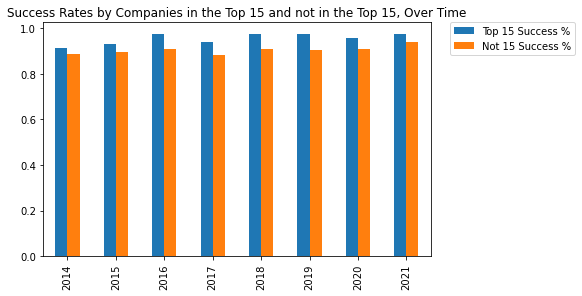

In [150]:
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY TOP 15 COMPANY (IN TERMS OF ANNUAL APPLICATIONS)

top15 = df[df["TOP15COMPANY"]==1]
not15 = df[df["TOP15COMPANY"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["Top 15 Success %", "Not 15 Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Companies in the Top 15 and not in the Top 15, Over Time")

Text(0.5, 1.0, 'Application Rates by Companies in the Top 15 and not in the Top 15, Over Time')

<Figure size 1200x1000 with 0 Axes>

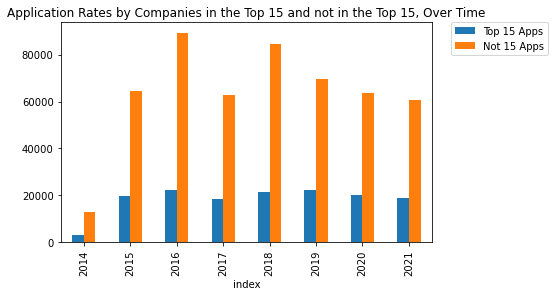

In [151]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["Top 15 Apps"] = pd.DataFrame(top15apps)
analysisdf["Not 15 Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["Top 15 Apps","Not 15 Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Companies in the Top 15 and not in the Top 15, Over Time")

In [152]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["Top 15 Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not 15 Success %"]
    sample1_size = analysisdf.loc[yr[x]]["Top 15 Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not 15 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Top 15 Vs. Not Top 15"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["Top 15 Vs. Not Top 15"]

In [153]:
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: TOP 15 COMPANY
print("Top 15 Company Success Rate Over Time Slope:",round(st.linregress(y = analysisdf["Top 15 Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = analysisdf["Top 15 Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = analysisdf["Top 15 Success %"], x = yr).rvalue,4),"\nModerate growth, .68% growth in success rate a year, but not a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: TOP 15 COMPANY
print("\nTop 15 Company Application Rate Over Time Slope:",round(st.linregress(y = analysisdf["Top 15 Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = analysisdf["Top 15 Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = analysisdf["Top 15 Apps"], x = yr).rvalue,4),"\nModerate growth, 1379 applications a year, but not a statistically significant slope.")

Top 15 Company Success Rate Over Time Slope: 0.006834 , P Val: 0.0513 , R Val: 0.7039 
Moderate growth, .68% growth in success rate a year, but not a statistically significant slope.

Top 15 Company Application Rate Over Time Slope: 1375.869 , P Val: 0.1765 , R Val: 0.5302 
Moderate growth, 1379 applications a year, but not a statistically significant slope.


In [154]:
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: NOT TOP 15 COMPANY
print("Not Top 15 Company Success Rate Over Time Slope:",round(st.linregress(y = analysisdf["Not 15 Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = analysisdf["Not 15 Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = analysisdf["Not 15 Success %"], x = yr).rvalue,4),"\nStrong growth, .54% growth in success rate a year, and a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: NOT TOP 15 COMPANY
print("\nNot Top 15 Company Application Rate Over Time Slope:",round(st.linregress(y = analysisdf["Not 15 Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = analysisdf["Not 15 Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = analysisdf["Not 15 Apps"], x = yr).rvalue,4),"\nWeak growth, 3516 applications a year, but not a statistically significant slope.")

Not Top 15 Company Success Rate Over Time Slope: 0.005654 , P Val: 0.0341 , R Val: 0.7445 
Strong growth, .54% growth in success rate a year, and a statistically significant slope.

Not Top 15 Company Application Rate Over Time Slope: 3491.06 , P Val: 0.3646 , R Val: 0.3717 
Weak growth, 3516 applications a year, but not a statistically significant slope.


In [155]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,Top 15 Success %,Not 15 Success %,Top 15 Apps,Not 15 Apps,PVAL Success %
index,,,,,
2014,0.91,0.89,"3,035.00","12,964.00",0.00
2015,0.93,0.89,"19,736.00","64,579.00",0.00
2016,0.97,0.91,"22,499.00","89,279.00",0.00
2017,0.94,0.88,"18,304.00","62,830.00",0.00
2018,0.98,0.91,"21,652.00","84,492.00",0.00
2019,0.97,0.90,"22,219.00","69,596.00",0.00
2020,0.96,0.91,"20,075.00","63,803.00",0.00
2021,0.97,0.94,"18,945.00","60,752.00",0.00
ALL YRS,0.96,0.91,"146,465.00","508,295.00",0.00


In [156]:
# CREATE A NEW COLUMN: YRS EDUCATION - DECISION YEAR, HOW MANY YEARS AFTER GRADUATION: POSTGRADYRS
# THIS IS FOR A DEEPER DIVE INTO THE TOP EMPLOYERS... 
df["YRSPOSTGRAD"] = df["YEAR"]-df["FOREIGN_WORKER_YRS_ED_COMP"]
# CLEANING UP WORKER EDUCATION AND EDUCATION REQUIREMENTS
df["FOREIGN_WORKER_EDUCATION"]= df["FOREIGN_WORKER_EDUCATION"].replace("NONE",np.nan)
df["MINIMUM_EDUCATION"] = df["MINIMUM_EDUCATION"].replace("NONE",np.nan)

In [157]:
# DIVING DEEPER INTO MICROSOFT, AMAZON, GOOGLE, APPLE (COMPANY VARIABLE CAN BE CHANGED FOR ANY COMPANY)
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

company = "MICROSOFT"
# CHANGE THIS FOR ANY COMPANY

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY PW LEVEL
topstate = df[df["EMPLOYER_NAME"] == company]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
empstatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
empstatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
empstatedf = empstatedf.set_index(["STATE","PW LEVEL"])
empstatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
WA    LEVEL I                 4331    117127.0                  3.0   
      LEVEL II                6663    120500.0                  4.0   
      LEVEL III               2246    135000.0                 10.0   
      LEVEL IV                1543    154315.0                 12.0   
CA    LEVEL I                  190    130954.0                  4.0   
      LEVEL II                 465    135500.0                  4.0   
      LEVEL III                181    155147.0                  9.0   
      LEVEL IV                 123    175000.0                 12.0   
TX    LEVEL I                   46     93750.0                  7.0   
      LEVEL II                  83    104832.0                  6.0   
      LEVEL III                 56    105400.0                 12.0   
      LEVEL IV                  36    118500.0                 13.0   
NC    LEVEL I                   32     99050.0                  4.5   
      LEVEL II                 124    105500.0                  3.0   
      LEVEL III                 35    130300.0                 10.0   
      LEVEL IV                  25    135470.0                 12.0   
MA    LEVEL I                   43    117980.0                  2.0   
      LEVEL II                  53    116000.0                  3.0   
      LEVEL III                 27    130000.0                 11.0   
      LEVEL IV                   8    159040.0                  7.5   
NY    LEVEL I                   19    135260.0                  5.0   
      LEVEL II                  35    135000.0                  6.0   
      LEVEL III                 28    147212.5                 11.0   
      LEVEL IV                  25    162000.0                 11.0   
ND    LEVEL I                   16     87080.0                  5.5   
      LEVEL II                  18     88500.0                  2.5   
      LEVEL III                  5     96900.0                  8.0   
      LEVEL IV                   9    110000.0                 11.0   
FL    LEVEL I                    5     98800.0                  8.0   
      LEVEL II                  12    118195.0                  9.0   
      LEVEL III                  6    136250.0                 17.0   
      LEVEL IV                  19    138352.0                 12.0   
GA    LEVEL I                    6    105000.0                  4.5   
      LEVEL II                  14    109000.0                  3.5   
      LEVEL III                  3    112500.0                  7.0   
      LEVEL IV                   7    127379.0                 14.0   
VA    LEVEL I                    8    110007.0                  8.5   
      LEVEL II                   5    127525.0                 10.0   
      LEVEL III                  5    131800.0                 15.0   
      LEVEL IV                   2    126050.0                  7.0   
NJ    LEVEL I                    0         NaN                  NaN   
      LEVEL II                   0         NaN                  NaN   
      LEVEL III                  8    120853.0                 11.0   
      LEVEL IV                   8    158227.0                 14.0   
IL    LEVEL I                    1    160550.0                 18.0   
      LEVEL II                   9    109076.0                  6.0   
      LEVEL III                  0         NaN                  NaN   
      LEVEL IV                   5    142700.0                 13.0   
PA    LEVEL I                    1    142080.0                  7.0   
      LEVEL II                   9    105000.0                  5.0   
      LEVEL III                  1    128200.0                  5.0   
      LEVEL IV                   1    110575.0                  NaN   
CO    LEVEL I                    1    125000.0                  1.0   
      LEVEL II                   6   122532.68                  4.0   
      LEVEL III                  2    15

In [158]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
empstatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
empstatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
empstatedf1 = empstatedf1.set_index(["STATE","EDU LEVEL"])
empstatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
WA    HIGH SCHOOL                  1    136300.0                 21.0   
      ASSOCIATE'S                  7    130000.0                 10.0   
      BACHELOR'S                5698    124790.0                  7.0   
      MASTER'S                  8263    121720.0                  4.0   
      DOCTORATE                  598    130000.0                  3.0   
...                              ...         ...                  ...   
NV    ASSOCIATE'S                  0         NaN                  NaN   
      BACHELOR'S                   1     91500.0                  2.0   
      MASTER'S                     8    112000.0                  5.0   
      DOCTORATE                    0         NaN                  NaN   
      OTHER                        0         NaN                  NaN   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
WA    HIGH SCHOOL                 257.0  
      ASSOCIATE'S                 187.0  
      BACHELOR'S                  149.0  
      MASTER'S                    155.0  
      DOCTORATE              153.248437  
...                                 ...  
NV    ASSOCIATE'S                   NaN  
      BACHELOR'S                  179.0  
      MASTER'S               116.767025  
      DOCTORATE                     NaN  
      OTHER                         NaN  

[90 rows x 4 columns]

In [159]:
# WHERE ARE EMPLOYERS HEADQUARTED? 
# TOP 15 STATES WHERE EMPLOYERS HQ AND SPONSOR GREEN CARDS
allHQ = pd.DataFrame(df["EMPLOYER_STATE_PROVINCE"].value_counts()[:15]).reset_index()
allHQ.columns = ["ASTATE","COUNT ASTATE"]
sucHQ = pd.DataFrame(df[df["CASE_STATUS"]==1]["EMPLOYER_STATE_PROVINCE"].value_counts()[:15]).reset_index()
sucHQ.columns = ["SSTATE","COUNT SSTATE"]
pd.concat([allHQ,sucHQ], axis = 1)

,ASTATE,COUNT ASTATE,SSTATE,COUNT SSTATE
0,CA,173189,CA,162248
1,TX,72663,TX,67217
2,NY,48520,WA,45496
3,NJ,48226,NY,45183
4,WA,47154,NJ,44456
5,IL,28311,IL,26269
6,MA,22700,MA,21342
7,MI,21155,MI,19799
8,PA,20809,PA,19706
9,FL,18590,VA,16489


In [160]:
# CHOROPLETH MAP OF THE TOP STATES BY SUCCESS
# ACCEPT % BASED ON STATE HQ IN
empy = df.groupby("EMPLOYER_STATE_PROVINCE")["CASE_STATUS"].value_counts()
empyer = pd.DataFrame(empy.groupby(level=0).transform(lambda x: (x / x.sum()).round(2)))
empyer.columns = ["Percent"]
f1 = empyer.reset_index()["EMPLOYER_STATE_PROVINCE"].tolist()
t1 = empyer.reset_index()["CASE_STATUS"].replace(1,"Accept").replace(0,"Reject").tolist()
idx1 = []
idx1.extend([tuple(a) for a in zip (f1,t1)])
empyer.index = pd.MultiIndex.from_tuples(idx1)
empyer = empyer.reset_index()
empyer = empyer[empyer["level_1"]=="Accept"]
empyer = empyer.drop("level_1",axis = 1)

empycount = pd.DataFrame(df.groupby("EMPLOYER_STATE_PROVINCE")["CASE_STATUS"].value_counts())
empycount.columns = ["Count"]
empycount = empycount.reset_index()
empycount = empycount[empycount["CASE_STATUS"]==1]
empycount = empycount["Count"]

empyer = pd.concat([empyer, empycount], axis = 1)
empyer.columns = ["State","Percent","Count"]
empyer["Count"] = empyer["State"].astype(str)+": "+empyer["Count"].astype(str)+" Successful Applications"
# Choropleth Map of Employer State Accept %
data = dict(type = "choropleth",
           locations = empyer["State"],
           locationmode = "USA-states",
           z = empyer["Percent"].astype(float),
           text = empyer["Count"],
           colorbar={"title":"Percent Accepted"},
           colorscale = "delta",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Percent Accepted in Employer Headquartered States",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [161]:
# HOW MANY OF THE TOP COMPANIES, IDENTIFIED ABOVE, ARE HQ IN THE TOP 5 STATES
companies = kingconsA["Yrs not in Top 15"].sort_values()[:7].index.tolist()
states = allHQ["ASTATE"][:5].tolist()
apps = allHQ["COUNT ASTATE"][:5].tolist()
companystates = pd.DataFrame()
for x in range(len(companies)):
    for i in range(len(states)):
        c = (df[df["EMPLOYER_NAME"]==companies[x]]["EMPLOYER_STATE_PROVINCE"]==states[i]).sum()
        n = pd.DataFrame([companies[x],states[i],c]).transpose()
        companystates = pd.concat([companystates,n])
companystates.columns=["EMPLOYER","STATE","APPLICATIONS"]
companystates["TOTALAPP"]=np.nan
for x in range(len(states)):
    companystates["TOTALAPP"] = np.where(companystates["STATE"]==states[x],apps[x],companystates["TOTALAPP"])
companystates = companystates.set_index(["EMPLOYER","STATE"])
companystates["% OF TOTAL APPLICATIONS"] = (companystates["APPLICATIONS"]/companystates["TOTALAPP"])*100
companystates = companystates.drop("TOTALAPP", axis = 1)
companystates

APPLICATIONS % OF TOTAL APPLICATIONS
EMPLOYER  STATE                                     
MICROSOFT CA               0                     0.0
          TX               0                     0.0
          NY               0                     0.0
          NJ               0                     0.0
          WA           16951                35.94817
INTEL     CA           12042                6.953097
          TX               0                     0.0
          NY               0                     0.0
          NJ               0                     0.0
          WA               0                     0.0
INFOSYS   CA               0                     0.0
          TX            6676                 9.18762
          NY               3                0.006183
          NJ               0                     0.0
          WA               0                     0.0
FACEBOOK  CA           10128                5.847946
          TX             504                0.693613
          NY               0                     0.0
          NJ             180                0.373243
          WA               0                     0.0
APPLE     CA            6521                3.765251
          TX               0                     0.0
          NY               0                     0.0
          NJ               2                0.004147
          WA               0                     0.0
AMAZON    CA            1078                0.622441
          TX              78                0.107345
          NY               1                0.002061
          NJ              12                0.024883
          WA           20767               44.040802
GOOGLE    CA           15574                8.992488
          TX               0                     0.0
          NY               0                     0.0
          NJ               0                     0.0
          WA               0                     0.0

In [162]:
# WHERE ARE EMPLOYERS HEADQUARTED? 
# TOP REGIONS WHERE EMPLOYERS HQ AND SPONSOR GREEN CARDS
allRHQ = pd.DataFrame(df["EMPLOYER_REGION"].value_counts()[:15]).reset_index()
allRHQ.columns = ["AREGION","COUNT AREGION"]
sucRHQ = pd.DataFrame(df[df["CASE_STATUS"]==1]["EMPLOYER_REGION"].value_counts()[:15]).reset_index()
sucRHQ.columns = ["SREGION","COUNT SREGION"]
pd.concat([allRHQ,sucRHQ], axis = 1)

,AREGION,COUNT AREGION,SREGION,COUNT SREGION
0,WEST,524394,WEST,482048
1,MIDWEST,88072,MIDWEST,80440
2,NORTHEAST,22672,NORTHEAST,21443
3,SOUTH,18686,SOUTH,16685
4,TERRITORY,911,TERRITORY,641
5,OTHER,7,OTHER,7


In [163]:
# HOW MANY OF THE TOP COMPANIES, IDENTIFIED ABOVE, ARE HQ IN THE TOP 4 REGION
companies = kingconsA["Yrs not in Top 15"].sort_values()[:7].index.tolist()
region = allRHQ["AREGION"][:4].tolist()
apps = allRHQ["COUNT AREGION"][:4].tolist()
companyregions = pd.DataFrame()
for x in range(len(companies)):
    for i in range(len(region)):
        c = (df[df["EMPLOYER_NAME"]==companies[x]]["EMPLOYER_REGION"]==region[i]).sum()
        n = pd.DataFrame([companies[x],region[i],c]).transpose()
        companyregions = pd.concat([companyregions,n])
companyregions.columns=["EMPLOYER","REGION","APPLICATIONS"]
companyregions["TOTALAPP"]=np.nan
for x in range(len(region)):
    companyregions["TOTALAPP"] = np.where(companyregions["REGION"]==region[x],apps[x],companyregions["TOTALAPP"])
companyregions = companyregions.set_index(["EMPLOYER","REGION"])
companyregions["% OF TOTAL APPLICATIONS"] = (companyregions["APPLICATIONS"]/companyregions["TOTALAPP"])*100
companyregions = companyregions.drop("TOTALAPP", axis = 1)
companyregions

APPLICATIONS % OF TOTAL APPLICATIONS
EMPLOYER  REGION                                        
MICROSOFT WEST             16951                3.232493
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
INTEL     WEST             12362                2.357388
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
INFOSYS   WEST              6857                1.307605
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
FACEBOOK  WEST             10818                2.062953
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
APPLE     WEST              6523                1.243912
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
AMAZON    WEST             22031                 4.20123
          MIDWEST              4                0.004542
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
GOOGLE    WEST             15574                2.969904
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0

In [164]:
# HOW MANY EMPLOYERS ARE NOT HQ IN USA?
print("Only",df["EMPLOYER_COUNTRY"].value_counts()[1:].sum(),"countries are not headquartered in the U.S.")
print(df["EMPLOYER_COUNTRY"].value_counts())

Only 23 countries are not headquartered in the U.S.
UNITED STATES OF AMERICA    654668
CANADA                          12
GEORGIA                          4
CAMEROON                         2
INDIA                            2
GERMANY                          2
SOUTH KOREA                      1
Name: EMPLOYER_COUNTRY, dtype: int64


In [165]:
# EXPLORING THE DISTRIBUTION OF NUMBER OF EMPLOYEES PER EMPLOYER
avgempnum = df.groupby("EMPLOYER_NAME")["EMPLOYER_NUM_EMPLOYEES"].agg(lambda x: st.mode(x)[0][0])
# WHAT IS THE MOST EMPLOYEES PER EMPLOYER
avgempnum.sort_values(ascending = False)

EMPLOYER_NAME
WALMART                          1400000.0
YUM RESTAURANTS INTERNATIONAL     725000.0
TACO BELL CORP.                   725000.0
ANNAPURNA LABS U.S. INC.          647500.0
AMAZON                            647500.0
                                   ...    
JENNIFER FOREST YANG                   1.0
PETROSYAN JEWELRY, INC.                1.0
PETRO-CHEM DEVELOPMENT CO.             1.0
PETER J. CHELKOWSKI                    1.0
S.T.A.M.P., INC.                       1.0
Name: EMPLOYER_NUM_EMPLOYEES, Length: 44061, dtype: float64

In [166]:
# THE MODE LOOKS FISHY, LETS BRING IN THE TOTAL APPLICANTS
countemp = pd.DataFrame(df.groupby("EMPLOYER_NAME")["CASE_STATUS"].count()).reset_index().sort_values(by = "EMPLOYER_NAME").reset_index(drop = True)
empdf = pd.DataFrame(avgempnum).reset_index().sort_values(by = "EMPLOYER_NAME").reset_index(drop = True)
empdf["COUNT"] = np.where(empdf["EMPLOYER_NAME"]==countemp["EMPLOYER_NAME"],countemp["CASE_STATUS"],np.nan)
empdf = empdf.sort_values(by = "EMPLOYER_NUM_EMPLOYEES", ascending = False)
empdf

,EMPLOYER_NAME,EMPLOYER_NUM_EMPLOYEES,COUNT
42249,WALMART,1400000.0,1660.0
43763,YUM RESTAURANTS INTERNATIONAL,725000.0,7.0
37601,TACO BELL CORP.,725000.0,2.0
2655,ANNAPURNA LABS U.S. INC.,647500.0,7.0
2067,AMAZON,647500.0,22043.0
...,...,...,...
20458,JENNIFER FOREST YANG,1.0,3.0
29948,"PETROSYAN JEWELRY, INC.",1.0,2.0
29937,PETRO-CHEM DEVELOPMENT CO.,1.0,2.0
29929,PETER J. CHELKOWSKI,1.0,2.0


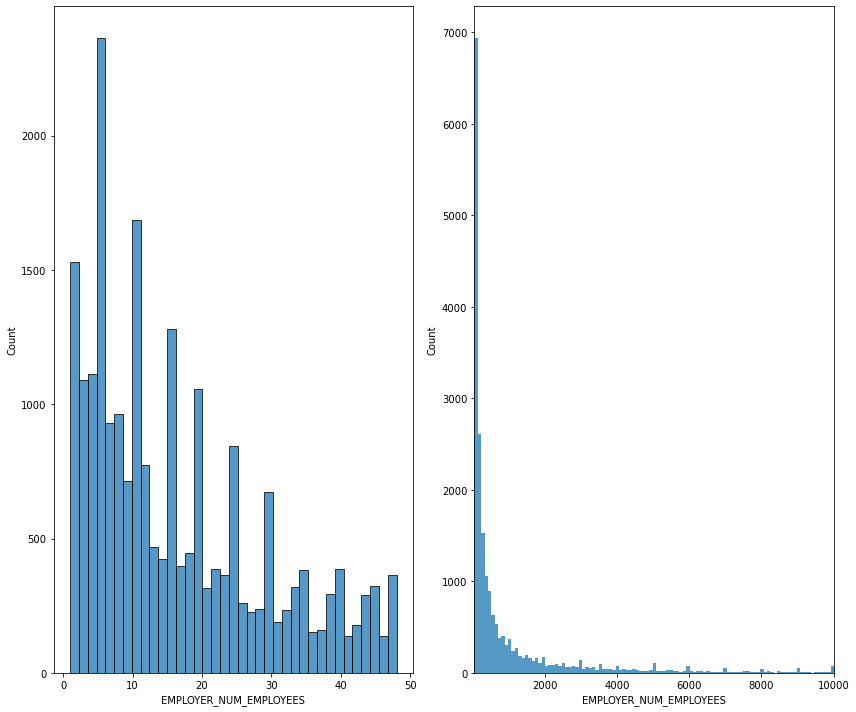

In [167]:
# PLOT THE DIST OF EMPLOYEE COUNT
btmemp = avgempnum[avgempnum<=avgempnum.median()]
topemp = avgempnum[avgempnum>avgempnum.median()]
fig, ax = plt.subplots(1,2, figsize = (12,10))
sns.histplot(x = btmemp, ax = ax[0])
topend = sns.histplot(x = topemp, ax = ax[1])
topend.set_xlim([50, 10000])
plt.tight_layout()

In [168]:
# CORRELATION ANALYSIS: NUMBER OF EMPLOYEEs WITH CASE STATUS: CASE BY CASE
st.linregress(x = df.dropna()["EMPLOYER_NUM_EMPLOYEES"], y = df.dropna()["CASE_STATUS"])
# DOES NOT SHOW MUCH, AGGREGATE MAY SHOW A DIFFERENT STORY

LinregressResult(slope=1.3117036505556376e-10, intercept=0.9421066763472213, rvalue=0.0017930190559430977, pvalue=0.21059270414226872, stderr=1.047737695479923e-10, intercept_stderr=0.00033450523432240775)

Text(0.5, 1.0, 'Success Rates by Company Size, Over Time')

<Figure size 1200x1000 with 0 Axes>

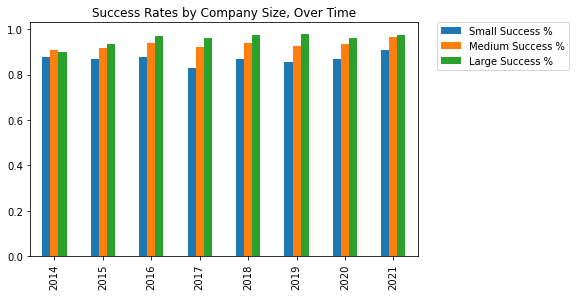

In [169]:
# CORRELATION ANALYSIS: AGGREGATE BY SIZE BRACKETS AND YEARLY
# PLOTTING SUCCESS RATES OVER TIME BY SIZE OF COMPANY

small = df[df["EMPLOYER_NUM_EMPLOYEES"]<1000]
medium = df[(df["EMPLOYER_NUM_EMPLOYEES"]>=1000)&(df["EMPLOYER_NUM_EMPLOYEES"]<10000)]
large = df[df["EMPLOYER_NUM_EMPLOYEES"]>=10000]


smalldf = pd.DataFrame()
meddf = pd.DataFrame()
largedf = pd.DataFrame()
regressdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(small[(small["YEAR"]==yr[x])&(small["CASE_STATUS"]==1)])/len(small[small["YEAR"]==yr[x]])])
    med = pd.DataFrame([len(medium[(medium["YEAR"]==yr[x])&(medium["CASE_STATUS"]==1)])/len(medium[medium["YEAR"]==yr[x]])])
    lar = pd.DataFrame([len(large[(large["YEAR"]==yr[x])&(large["CASE_STATUS"]==1)])/len(large[large["YEAR"]==yr[x]])])
    smalldf = pd.concat([smalldf,j])
    meddf = pd.concat([meddf,med])
    largedf = pd.concat([largedf,lar])
    regressdf = pd.concat([smalldf,meddf,largedf], axis = 1)
    

regressdf.index = yr
regressdf.columns = ["Small Success %", "Medium Success %", "Large Success %"]
plt.figure(figsize = (12,10), dpi = 100)
regressdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Company Size, Over Time")

Text(0.5, 1.0, 'Application Rates by Company Size, Over Time')

<Figure size 1200x1000 with 0 Axes>

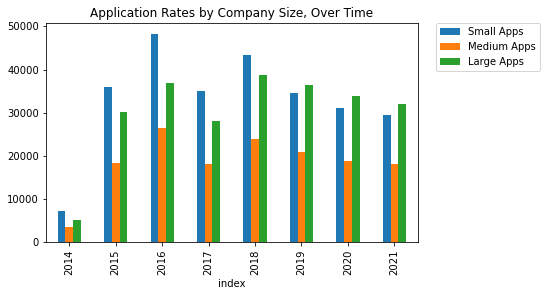

In [170]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
smallapps = []
mediumapps = []
largeapps = []

for x in range(len(yr)):
    s = (small["YEAR"]==yr[x]).sum()
    ssd = st.tstd(small[small["YEAR"]==yr[x]]["CASE_STATUS"])
    m = (medium["YEAR"]==yr[x]).sum()
    msd = st.tstd(medium[medium["YEAR"]==yr[x]]["CASE_STATUS"])
    l = (large["YEAR"]==yr[x]).sum()
    lsd = st.tstd(large[large["YEAR"]==yr[x]]["CASE_STATUS"])
    smallapps.append(s)
    mediumapps.append(m)
    largeapps.append(l)
regressdf = regressdf.reset_index()
regressdf["Small Apps"] = pd.DataFrame(smallapps)
regressdf["Medium Apps"] = pd.DataFrame(mediumapps)
regressdf["Large Apps"] = pd.DataFrame(largeapps)
regressdf = regressdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY SIZE OF COMPANY
plt.figure(figsize = (12,10), dpi = 100)
regressdf.reset_index().plot(x = "index", y = ["Small Apps","Medium Apps","Large Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Company Size, Over Time")

In [171]:
# P VALUE PER YEAR
small_med = []
for x in range(len(yr)):
    sample1_phat = regressdf.loc[yr[x]]["Small Success %"]
    sample2_phat = regressdf.loc[yr[x]]["Medium Success %"]
    sample1_size = regressdf.loc[yr[x]]["Small Apps"]
    sample2_size = regressdf.loc[yr[x]]["Medium Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    small_med.append(pval)

pvaldf = pd.DataFrame(small_med)

small_large = []
for x in range(len(yr)):
    sample1_phat = regressdf.loc[yr[x]]["Small Success %"]
    sample2_phat = regressdf.loc[yr[x]]["Large Success %"]
    sample1_size = regressdf.loc[yr[x]]["Small Apps"]
    sample2_size = regressdf.loc[yr[x]]["Large Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    small_large.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(small_large)], axis = 1)

med_large = []
for x in range(len(yr)):
    sample1_phat = regressdf.loc[yr[x]]["Medium Success %"]
    sample2_phat = regressdf.loc[yr[x]]["Large Success %"]
    sample1_size = regressdf.loc[yr[x]]["Medium Apps"]
    sample2_size = regressdf.loc[yr[x]]["Large Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    med_large.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(med_large)], axis = 1)
pvaldf.columns = ["Small_Med","Small_Large","Med_Large"]
pvaldf.index = yr
regressdf[["Small_Med","Small_Large","Med_Large"]] = pvaldf[["Small_Med","Small_Large","Med_Large"]]

In [172]:
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: SMALL COMPANY
print("Small Company Success Rate Over Time Slope:",round(st.linregress(y = regressdf["Small Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = regressdf["Small Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Small Success %"], x = yr).rvalue,4),"\nWeak growth, .19% growth in success rate a year, and not a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: SMALL COMPANY
print("\nSmall Company Application Rate Over Time Slope:",round(st.linregress(y = regressdf["Small Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = regressdf["Small Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Small Apps"], x = yr).rvalue,4),"\nWeak growth, 1204 applications a year, and not a statistically significant slope.")

Small Company Success Rate Over Time Slope: 0.002281 , P Val: 0.5492 , R Val: 0.2508 
Weak growth, .19% growth in success rate a year, and not a statistically significant slope.

Small Company Application Rate Over Time Slope: 1187.452 , P Val: 0.5692 , R Val: 0.2386 
Weak growth, 1204 applications a year, and not a statistically significant slope.


In [173]:
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: MEDIUM COMPANY
print("Medium Company Success Rate Over Time Slope:",round(st.linregress(y = regressdf["Medium Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = regressdf["Medium Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Medium Success %"], x = yr).rvalue,4),"\nStrong growth, .57% growth in success rate a year, with a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: MEDIUM COMPANY
print("\nMedium Company Application Rate Over Time Slope:",round(st.linregress(y = regressdf["Medium Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = regressdf["Medium Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Medium Apps"], x = yr).rvalue,4),"\nModerate growth, 1122 applications a year, and not a statistically significant slope.")

Medium Company Success Rate Over Time Slope: 0.005833 , P Val: 0.0205 , R Val: 0.787 
Strong growth, .57% growth in success rate a year, with a statistically significant slope.

Medium Company Application Rate Over Time Slope: 1117.679 , P Val: 0.3208 , R Val: 0.4041 
Moderate growth, 1122 applications a year, and not a statistically significant slope.


In [174]:
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: LARGE COMPANY
print("Large Company Success Rate Over Time Slope:",round(st.linregress(y = regressdf["Large Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = regressdf["Large Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Large Success %"], x = yr).rvalue,4),"\nStrong growth, .83% growth in success rate a year, and a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: LARGE COMPANY
print("\nLarge Company Application Rate Over Time Slope:",round(st.linregress(y = regressdf["Large Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = regressdf["Large Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Large Apps"], x = yr).rvalue,4),"\nModerate growth, 2569 applications a year, and not a statistically significant slope.")

Large Company Success Rate Over Time Slope: 0.008407 , P Val: 0.0291 , R Val: 0.7587 
Strong growth, .83% growth in success rate a year, and a statistically significant slope.

Large Company Application Rate Over Time Slope: 2561.798 , P Val: 0.1271 , R Val: 0.5857 
Moderate growth, 2569 applications a year, and not a statistically significant slope.


In [175]:
# GETTING THE TOTAL PVAL
regressdf.loc["ALL YRS"] = regressdf.sum()
smallsuc = []
medsuc = []
largesuc = []
for x in range(len(yr)):
    s = regressdf.loc[yr[x]].iloc[0]*regressdf.loc[yr[x]].iloc[3]
    m = regressdf.loc[yr[x]].iloc[1]*regressdf.loc[yr[x]].iloc[4]
    l = regressdf.loc[yr[x]].iloc[2]*regressdf.loc[yr[x]].iloc[5]
    smallsuc.append(s)
    medsuc.append(m)
    largesuc.append(l)
regressdf.loc["ALL YRS"].iloc[0] = sum(smallsuc)/regressdf.loc["ALL YRS"].iloc[3]
regressdf.loc["ALL YRS"].iloc[1] = sum(medsuc)/regressdf.loc["ALL YRS"].iloc[4]
regressdf.loc["ALL YRS"].iloc[2] = sum(largesuc)/regressdf.loc["ALL YRS"].iloc[5]


for x in range(len(yr)):
    sample1_phat = regressdf.loc["ALL YRS"].iloc[0]
    sample2_phat = regressdf.loc["ALL YRS"].iloc[1]
    sample1_size = regressdf.loc["ALL YRS"].iloc[3]
    sample2_size = regressdf.loc["ALL YRS"].iloc[4]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
regressdf.loc["ALL YRS"].iloc[6] = pval

for x in range(len(yr)):
    sample1_phat = regressdf.loc["ALL YRS"].iloc[0]
    sample2_phat = regressdf.loc["ALL YRS"].iloc[2]
    sample1_size = regressdf.loc["ALL YRS"].iloc[3]
    sample2_size = regressdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
regressdf.loc["ALL YRS"].iloc[7] = pval

for x in range(len(yr)):
    sample1_phat = regressdf.loc["ALL YRS"].iloc[1]
    sample2_phat = regressdf.loc["ALL YRS"].iloc[2]
    sample1_size = regressdf.loc["ALL YRS"].iloc[4]
    sample2_size = regressdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
regressdf.loc["ALL YRS"].iloc[8] = pval
regressdf = regressdf.head(9).style.format("{:,.2f}")
regressdf

,Small Success %,Medium Success %,Large Success %,Small Apps,Medium Apps,Large Apps,Small_Med,Small_Large,Med_Large
index,,,,,,,,,
2014,0.88,0.91,0.90,"7,218.00","3,629.00","5,152.00",0.00,0.00,0.17
2015,0.87,0.92,0.93,"35,869.00","18,346.00","30,100.00",0.00,0.00,0.00
2016,0.88,0.94,0.97,"48,345.00","26,480.00","36,953.00",0.00,0.00,0.00
2017,0.83,0.92,0.96,"35,055.00","18,046.00","28,033.00",0.00,0.00,0.00
2018,0.87,0.94,0.97,"43,447.00","24,034.00","38,663.00",0.00,0.00,0.00
2019,0.86,0.93,0.98,"34,664.00","20,823.00","36,328.00",0.00,0.00,0.00
2020,0.87,0.93,0.96,"31,029.00","18,944.00","33,905.00",0.00,0.00,0.00
2021,0.91,0.97,0.97,"29,589.00","18,183.00","31,925.00",0.00,0.00,0.00
ALL YRS,0.87,0.93,0.96,"265,216.00","148,485.00","241,059.00",0.00,0.00,0.00


In [176]:
# CREATING A NEW COLUMN: SIZE OF COMPANY
df["EMPLOYER_SIZE"] = np.nan
df["EMPLOYER_SIZE"] = np.where(df["EMPLOYER_NUM_EMPLOYEES"]<1000,"SMALL",df["EMPLOYER_SIZE"])
df["EMPLOYER_SIZE"] = np.where((df["EMPLOYER_NUM_EMPLOYEES"]>=1000)&(df["EMPLOYER_NUM_EMPLOYEES"]<10000),"MEDIUM",df["EMPLOYER_SIZE"])
df["EMPLOYER_SIZE"] = np.where(df["EMPLOYER_NUM_EMPLOYEES"]>=10000,"LARGE",df["EMPLOYER_SIZE"])

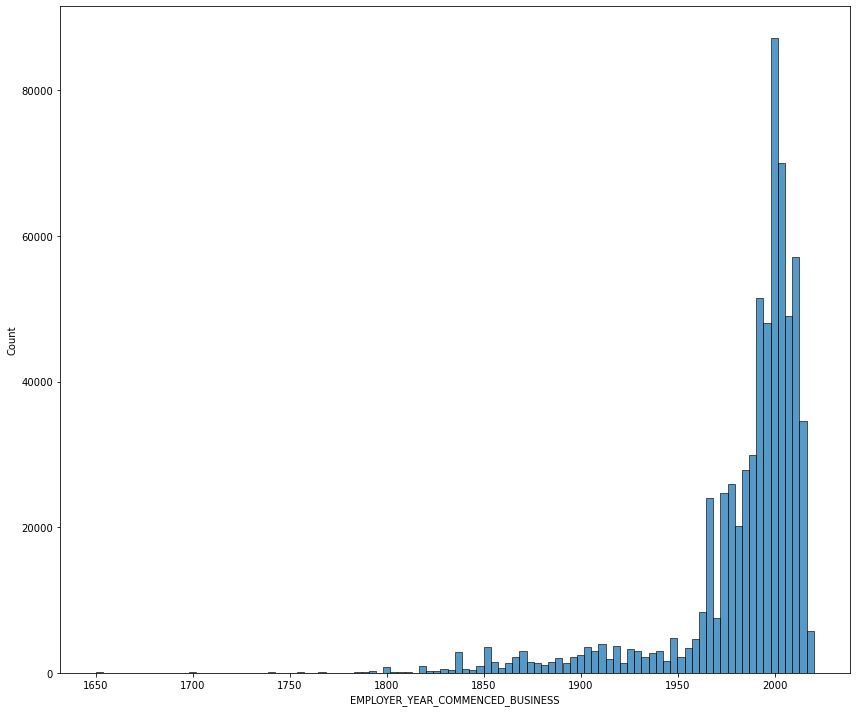

In [177]:
# DISTRIBUTION OF YEAR COMMENCED
# PLOT THE DIST OF YEAR COMMENCED
plt.figure(figsize = (12,10))
empcount = sns.histplot(x = df["EMPLOYER_YEAR_COMMENCED_BUSINESS"], bins = 100)
plt.tight_layout()

In [178]:
# CORRELATION ANALYSIS: EMPLOYER AGE WITH CASE STATUS: CASE BY CASE
st.linregress(x = df.dropna()["EMPLOYER_YEAR_COMMENCED_BUSINESS"], y = df.dropna()["CASE_STATUS"])
# DOES NOT SHOW MUCH, AGGREGATE MAY SHOW A DIFFERENT STORY

LinregressResult(slope=-0.00012523456524877788, intercept=1.1908691618288345, rvalue=-0.017231922717069886, pvalue=2.3918981501663466e-33, stderr=1.0407068916129492e-05, intercept_stderr=0.020674432483793522)

In [179]:
# NEW COLUMN: BREAKING UP THE COMPANIES BY AGE
df["EMPLOYER_AGE"] = np.nan
df["EMPLOYER_AGE"] = np.where((df["YEAR"]-df["EMPLOYER_YEAR_COMMENCED_BUSINESS"])<15,"YOUNG",df["EMPLOYER_AGE"])
df["EMPLOYER_AGE"] = np.where(((df["YEAR"]-df["EMPLOYER_YEAR_COMMENCED_BUSINESS"])>=15)&((df["YEAR"]-df["EMPLOYER_YEAR_COMMENCED_BUSINESS"])<30),"MEDIUM",df["EMPLOYER_AGE"])
df["EMPLOYER_AGE"] = np.where((df["YEAR"]-df["EMPLOYER_YEAR_COMMENCED_BUSINESS"])>=30,"OLD",df["EMPLOYER_AGE"])

Text(0.5, 1.0, 'Success Rates by Company Age, Over Time')

<Figure size 1200x1000 with 0 Axes>

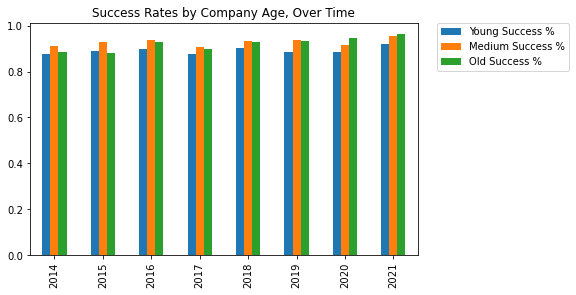

In [180]:
# CORRELATION ANALYSIS: AGGREGATE BY SIZE BRACKETS AND YEARLY
# PLOTTING SUCCESS RATES OVER TIME BY SIZE OF COMPANY

young = df[df["EMPLOYER_AGE"]=="YOUNG"]
mid = df[df["EMPLOYER_AGE"]=="MEDIUM"]
old = df[df["EMPLOYER_AGE"]=="OLD"]


youndf = pd.DataFrame()
middf = pd.DataFrame()
olddf = pd.DataFrame()
linregdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(young[(young["YEAR"]==yr[x])&(young["CASE_STATUS"]==1)])/len(young[young["YEAR"]==yr[x]])])
    med = pd.DataFrame([len(mid[(mid["YEAR"]==yr[x])&(mid["CASE_STATUS"]==1)])/len(mid[mid["YEAR"]==yr[x]])])
    oldy = pd.DataFrame([len(old[(old["YEAR"]==yr[x])&(old["CASE_STATUS"]==1)])/len(old[old["YEAR"]==yr[x]])])
    youndf = pd.concat([youndf,j])
    middf = pd.concat([middf,med])
    olddf = pd.concat([olddf,oldy])
    linregdf = pd.concat([youndf,middf,olddf], axis = 1)
    

linregdf.index = yr
linregdf.columns = ["Young Success %", "Medium Success %", "Old Success %"]
plt.figure(figsize = (12,10), dpi = 100)
linregdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Company Age, Over Time")

Text(0.5, 1.0, 'Application Rates by Company Age, Over Time')

<Figure size 1200x1000 with 0 Axes>

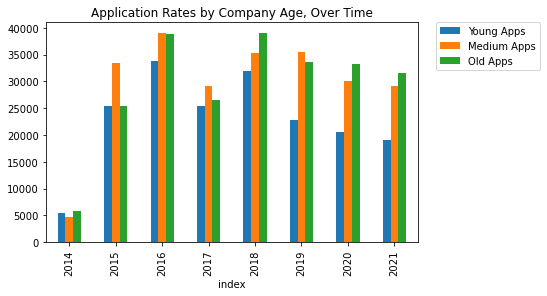

In [181]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
youngapps = []
midapps = []
oldapps = []

for x in range(len(yr)):
    y = (young["YEAR"]==yr[x]).sum()
    m = (mid["YEAR"]==yr[x]).sum()
    o = (old["YEAR"]==yr[x]).sum()
    youngapps.append(y)
    midapps.append(m)
    oldapps.append(o)
linregdf = linregdf.reset_index()
linregdf["Young Apps"] = pd.DataFrame(youngapps)
linregdf["Medium Apps"] = pd.DataFrame(midapps)
linregdf["Old Apps"] = pd.DataFrame(oldapps)
linregdf = linregdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY SIZE OF COMPANY
plt.figure(figsize = (12,10), dpi = 100)
linregdf.reset_index().plot(x = "index", y = ["Young Apps","Medium Apps","Old Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Company Age, Over Time")

In [182]:
# P VALUE PER YEAR
young_med = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Young Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Medium Success %"]
    sample1_size = linregdf.loc[yr[x]]["Young Apps"]
    sample2_size = linregdf.loc[yr[x]]["Medium Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    young_med.append(pval)

pvaldf = pd.DataFrame(young_med)

young_old = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Young Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Old Success %"]
    sample1_size = linregdf.loc[yr[x]]["Young Apps"]
    sample2_size = linregdf.loc[yr[x]]["Old Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    young_old.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(young_old)], axis = 1)

med_old = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Medium Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Old Success %"]
    sample1_size = linregdf.loc[yr[x]]["Medium Apps"]
    sample2_size = linregdf.loc[yr[x]]["Old Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    med_old.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(med_old)], axis = 1)
pvaldf.columns = ["Young_Med","Young_Old","Med_Old"]
pvaldf.index = yr
linregdf[["Young_Med","Young_Old","Med_Old"]] = pvaldf[["Young_Med","Young_Old","Med_Old"]]
linregdf

,Young Success %,Medium Success %,Old Success %,Young Apps,Medium Apps,Old Apps,Young_Med,Young_Old,Med_Old
index,,,,,,,,,
2014,0.876116,0.913043,0.886763,5489,4761,5749,1.553095e-09,8.080249e-02,8.816962e-06
2015,0.890256,0.926403,0.882519,25432,33398,25485,2.039374e-52,5.945324e-03,4.950805e-74
2016,0.899320,0.935723,0.930469,33810,39050,38918,5.342377e-72,1.531374e-51,3.324268e-03
2017,0.876086,0.908153,0.898001,25445,29179,26510,9.896690e-34,2.889631e-15,5.146501e-05
2018,0.901552,0.931507,0.928894,31885,35303,38956,5.305244e-45,3.578606e-39,1.630143e-01
2019,0.882895,0.936659,0.931525,22783,35443,33589,7.460648e-115,7.122449e-89,6.559894e-03
2020,0.883808,0.916943,0.944712,20492,30124,33262,2.806872e-35,2.077624e-143,1.860927e-43
2021,0.917653,0.953702,0.963049,19102,29094,31501,3.292403e-59,3.564071e-106,8.035974e-09


In [183]:
# LINEAR REGRESSION BETWEEN COMPANY AGE AND SUCCESS RATE OVER TIME: YOUNG COMPANY
print("Young Company Success Rate Over Time Slope:",round(st.linregress(y = linregdf["Young Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = linregdf["Young Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Young Success %"], x = yr).rvalue,4),"\nWeak growth, .25% growth in success rate a year, and not a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY AGE AND APPLICATIONS OVER TIME: YOUNG COMPANY
print("\nYoung Company Application Rate Over Time Slope:",round(st.linregress(y = linregdf["Young Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = linregdf["Young Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Young Apps"], x = yr).rvalue,4),"\nWeak growth, 531 applications a year, and not a statistically significant slope.")

Young Company Success Rate Over Time Slope: 0.002794 , P Val: 0.2342 , R Val: 0.4751 
Weak growth, .25% growth in success rate a year, and not a statistically significant slope.

Young Company Application Rate Over Time Slope: 523.214 , P Val: 0.7292 , R Val: 0.1465 
Weak growth, 531 applications a year, and not a statistically significant slope.


In [184]:
# LINEAR REGRESSION BETWEEN COMPANY AGE AND SUCCESS RATE OVER TIME: MEDIUM COMPANY
print("Medium Company Success Rate Over Time Slope:",round(st.linregress(y = linregdf["Medium Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = linregdf["Medium Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Medium Success %"], x = yr).rvalue,4),"\Moderate growth, .29% growth in success rate a year, and not a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY AGE AND APPLICATIONS OVER TIME: MEDIUM COMPANY
print("\nMedium Company Application Rate Over Time Slope:",round(st.linregress(y = linregdf["Medium Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = linregdf["Medium Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Medium Apps"], x = yr).rvalue,4),"\Moderate growth, 1786 applications a year, and not a statistically significant slope.")

Medium Company Success Rate Over Time Slope: 0.003137 , P Val: 0.1901 , R Val: 0.5164 \Moderate growth, .29% growth in success rate a year, and not a statistically significant slope.

Medium Company Application Rate Over Time Slope: 1776.952 , P Val: 0.3128 , R Val: 0.4102 \Moderate growth, 1786 applications a year, and not a statistically significant slope.


In [185]:
# LINEAR REGRESSION BETWEEN COMPANY AGE AND SUCCESS RATE OVER TIME: OLD COMPANY
print("Old Company Success Rate Over Time Slope:",round(st.linregress(y = linregdf["Old Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = linregdf["Old Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Old Success %"], x = yr).rvalue,4),"\nVery strong growth, 1% growth in success rate a year, and a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY AGE AND APPLICATIONS OVER TIME: OLD COMPANY
print("\nOld Company Application Rate Over Time Slope:",round(st.linregress(y = linregdf["Old Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = linregdf["Old Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Old Apps"], x = yr).rvalue,4),"\nModerate growth, 2578 applications a year, and not a statistically significant slope.")

Old Company Success Rate Over Time Slope: 0.010465 , P Val: 0.0029 , R Val: 0.8925 
Very strong growth, 1% growth in success rate a year, and a statistically significant slope.

Old Company Application Rate Over Time Slope: 2566.762 , P Val: 0.1257 , R Val: 0.5875 
Moderate growth, 2578 applications a year, and not a statistically significant slope.


In [186]:
# GETTING THE TOTAL PVAL
linregdf.loc["ALL YRS"] = linregdf.sum()
youngsuc = []
medsuc = []
oldsuc = []
for x in range(len(yr)):
    y = linregdf.loc[yr[x]].iloc[0]*linregdf.loc[yr[x]].iloc[3]
    m = linregdf.loc[yr[x]].iloc[1]*linregdf.loc[yr[x]].iloc[4]
    o = linregdf.loc[yr[x]].iloc[2]*linregdf.loc[yr[x]].iloc[5]
    youngsuc.append(y)
    medsuc.append(m)
    oldsuc.append(o)
linregdf.loc["ALL YRS"].iloc[0] = sum(youngsuc)/linregdf.loc["ALL YRS"].iloc[3]
linregdf.loc["ALL YRS"].iloc[1] = sum(medsuc)/linregdf.loc["ALL YRS"].iloc[4]
linregdf.loc["ALL YRS"].iloc[2] = sum(oldsuc)/linregdf.loc["ALL YRS"].iloc[5]


for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample1_size = linregdf.loc["ALL YRS"].iloc[3]
    sample2_size = linregdf.loc["ALL YRS"].iloc[4]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[6] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[3]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[7] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[8] = pval
linregdf = linregdf.head(9).style.format("{:,.2f}")
linregdf

,Young Success %,Medium Success %,Old Success %,Young Apps,Medium Apps,Old Apps,Young_Med,Young_Old,Med_Old
index,,,,,,,,,
2014,0.88,0.91,0.89,"5,489.00","4,761.00","5,749.00",0.00,0.08,0.00
2015,0.89,0.93,0.88,"25,432.00","33,398.00","25,485.00",0.00,0.01,0.00
2016,0.90,0.94,0.93,"33,810.00","39,050.00","38,918.00",0.00,0.00,0.00
2017,0.88,0.91,0.90,"25,445.00","29,179.00","26,510.00",0.00,0.00,0.00
2018,0.90,0.93,0.93,"31,885.00","35,303.00","38,956.00",0.00,0.00,0.16
2019,0.88,0.94,0.93,"22,783.00","35,443.00","33,589.00",0.00,0.00,0.01
2020,0.88,0.92,0.94,"20,492.00","30,124.00","33,262.00",0.00,0.00,0.00
2021,0.92,0.95,0.96,"19,102.00","29,094.00","31,501.00",0.00,0.00,0.00
ALL YRS,0.89,0.93,0.93,"184,438.00","236,352.00","233,970.00",0.00,0.00,0.00


In [187]:
# Top 15 NAICS of all time 2014-2021
allcode = pd.DataFrame(df["NAICS_CODE"].value_counts()[:15]).reset_index()
allcode.columns = ["ACode","COUNT ACode"]
succode = pd.DataFrame(df[df["CASE_STATUS"]==1]["NAICS_CODE"].value_counts()[:15]).reset_index()
succode.columns = ["SCode","COUNT SCode"]
pd.concat([allcode,succode], axis = 1)

,ACode,COUNT ACode,SCode,COUNT SCode
0,541511,134594,541511,125027
1,541512,59144,541512,57411
2,454111,23742,454111,23272
3,611310,20650,611310,19574
4,541519,16569,541519,15704
5,511210,15404,511210,14697
6,51121,14952,51121,14471
7,334111,14581,334111,14204
8,3344,13009,3344,11809
9,311615,11693,541330,10683


In [188]:
# Grabbing the top 15 for each year codes: only succesful applications
top15scode = pd.DataFrame()
def grab (year):
    return df[(df["YEAR"]==year)&(df["CASE_STATUS"]==1)]["NAICS_CODE"].value_counts()[:15]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top15scode = pd.concat([top15scode,j], axis = 1)
top15scode.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS CODE NOT IN THE TOP 15?: TOP 10 CONSISTENT CODES...
kingcons = top15scode.isnull().replace(False,0).replace(True,1)
kingcons["Yrs not in Top 15"] = top15scode.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingcons["Yrs not in Top 15"].sort_values()[:10]

541511    0
523110    0
54151     0
541330    0
454111    0
511210    0
334111    0
541512    0
611310    0
541519    0
Name: Yrs not in Top 15, dtype: int64

In [189]:
# Grabbing the top 15 for each year codes: total applications
top15acode = pd.DataFrame()
def grab (year):
    return df[df["YEAR"]==year]["NAICS_CODE"].value_counts()[:15]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top15acode = pd.concat([top15acode,j], axis = 1)
top15acode.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS CODE NOT IN THE TOP 15?: TOP 10 CONSISTENT CODES...
kingconsA = top15acode.isnull().replace(False,0).replace(True,1)
kingconsA["Yrs not in Top 15"] = top15acode.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingconsA["Yrs not in Top 15"].sort_values()[:10]

541511    0
523110    0
54151     0
454111    0
541330    0
511210    0
334111    0
541512    0
611310    0
541519    0
Name: Yrs not in Top 15, dtype: int64

In [190]:
# DIVING DEEPER INTO THE TOP CODES!
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = "541511"
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY PW LEVEL
topstate = df[df["NAICS_CODE"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
NJ    LEVEL I                  995     71200.0                 11.0   
      LEVEL II               10512     87464.0                 10.0   
      LEVEL III               7929    103626.0                 10.0   
      LEVEL IV                5942    122984.5                 12.0   
CA    LEVEL I                 1981    105000.0                  5.0   
      LEVEL II                9498    119122.0                  6.0   
      LEVEL III               4547    131165.0                  8.0   
      LEVEL IV                5796    142000.0                 12.0   
TX    LEVEL I                  942     68162.0                 10.0   
      LEVEL II                9127     85440.0                 10.0   
      LEVEL III               4896     96470.0                 11.0   
      LEVEL IV                3262    114899.0                 12.0   
NY    LEVEL I                  300     82000.0                  6.0   
      LEVEL II                1890     92300.0                  9.0   
      LEVEL III               1331    111120.0                 11.0   
      LEVEL IV                7516    125000.0                 11.0   
MI    LEVEL I                  142     65808.5                  8.0   
      LEVEL II                1900     71635.0                  8.0   
      LEVEL III               2694     87455.0                  9.0   
      LEVEL IV                1793    103000.0                 11.0   
MA    LEVEL I                  266   75868.825                  7.0   
      LEVEL II                1894     88265.0                  6.0   
      LEVEL III               2335    110240.0                 10.0   
      LEVEL IV                1648    122500.0                 12.0   
IL    LEVEL I                  262     67309.0                  8.0   
      LEVEL II                1541     80912.0                  8.0   
      LEVEL III               2784     97000.0                 11.0   
      LEVEL IV                1318    111218.0                 12.0   
VA    LEVEL I                  395     72000.0                  9.0   
      LEVEL II                1957     90646.0                  7.0   
      LEVEL III               1704    110490.0                  6.0   
      LEVEL IV                1264    127379.0                 11.0   
PA    LEVEL I                  135     70000.0                  8.0   
      LEVEL II                1522     81086.5                  9.0   
      LEVEL III               1300    100006.0                 10.0   
      LEVEL IV                2121    101712.0                 11.0   
GA    LEVEL I                  272     65000.0                  9.0   
      LEVEL II                1703     79400.0                  7.0   
      LEVEL III               1173     95306.0                  6.0   
      LEVEL IV                1727    112000.0                 12.0   
FL    LEVEL I                  159     61755.0                 10.0   
      LEVEL II                 811     73112.0                  7.0   
      LEVEL III                867     88005.0                  9.0   
      LEVEL IV                 640    104479.0                 12.0   
WA    LEVEL I                  196     93402.5                  7.0   
      LEVEL II                1097    112549.0                  9.0   
      LEVEL III                409    123000.0                  9.0   
      LEVEL IV                 672    132966.0                 11.0   
NC    LEVEL I                   89     75000.0                  6.0   
      LEVEL II                 662     85987.0                  6.0   
      LEVEL III                389    100500.0                  8.0   
      LEVEL IV                 527    112840.0                 12.0   
MD    LEVEL I                  108     71141.0                  8.0   
      LEVEL II                 582     90688.0                  8.0   
      LEVEL III                547    10

In [191]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["NAICS_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
NJ    HIGH SCHOOL                 14    103921.5                 23.5   
      ASSOCIATE'S                108     81934.0                 16.0   
      BACHELOR'S               12562    100000.0                 12.0   
      MASTER'S                 12633     96600.0                  7.0   
      DOCTORATE                   21    105500.0                  4.0   
...                              ...         ...                  ...   
OH    ASSOCIATE'S                  9     93891.0                 20.0   
      BACHELOR'S                 753     98000.0                 12.0   
      MASTER'S                   797     90584.0                  6.0   
      DOCTORATE                    7     82742.0                  3.0   
      OTHER                       15     85000.0                 13.0   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
NJ    HIGH SCHOOL                 230.0  
      ASSOCIATE'S                 202.5  
      BACHELOR'S                  142.0  
      MASTER'S               148.406308  
      DOCTORATE                   112.0  
...                                 ...  
OH    ASSOCIATE'S            180.418032  
      BACHELOR'S                  129.0  
      MASTER'S               142.423113  
      DOCTORATE                   142.0  
      OTHER                  104.579757  

[90 rows x 4 columns]

In [192]:
# NEW COLUMN: 1 is in the top 15 of the YEAR, 0 is not: Applications
filler = pd.DataFrame()
for x in range(len(yr)):
    listy = top15acode[yr[x]].dropna().index.tolist()
    filler = pd.concat([filler,pd.DataFrame((df[df["YEAR"]==yr[x]]["NAICS_CODE"].isin(listy)).replace(True,1).replace(False,0))])

filler = filler.reset_index().sort_values(by = "index").set_index("index")
filler.columns = ["TOP15CODE"]
df["TOP15CODE"] = filler

In [193]:
# CORRELATION ANALYSIS: NUMBER OF EMPLOYEEs WITH CASE STATUS: CASE BY CASE
st.linregress(x = df.dropna()["TOP15CODE"], y = df.dropna()["CASE_STATUS"])
# DOES NOT SHOW MUCH, AGGREGATE MAY SHOW A DIFFERENT STORY

LinregressResult(slope=0.01437558495168108, intercept=0.933312527109804, rvalue=0.029993686585417477, pvalue=1.9921167824946577e-97, stderr=0.0006861241148393712, intercept_stderr=0.000536860100721036)

Text(0.5, 1.0, 'Success Rates by Companies Codes in the Top 15 and not in the Top 15, Over Time')

<Figure size 1200x1000 with 0 Axes>

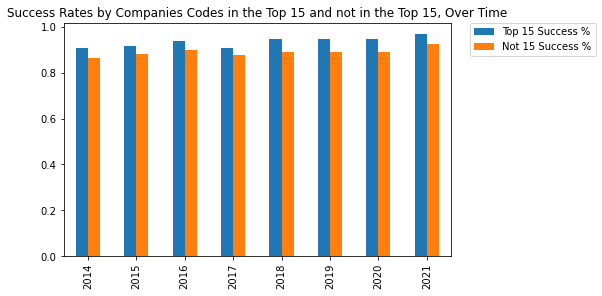

In [194]:
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY TOP 15 COMPANY (IN TERMS OF ANNUAL APPLICATIONS)
top15 = df[df["TOP15CODE"]==1]
not15 = df[df["TOP15CODE"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
lanalysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    lanalysisdf = pd.concat([topdf,notdf], axis = 1)

lanalysisdf.index = yr
lanalysisdf.columns = ["Top 15 Success %", "Not 15 Success %"]
plt.figure(figsize = (12,10), dpi = 100)
lanalysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Companies Codes in the Top 15 and not in the Top 15, Over Time")


Text(0.5, 1.0, 'Application Rates by Companies Codes in the Top 15 and not in the Top 15, Over Time')

<Figure size 1200x1000 with 0 Axes>

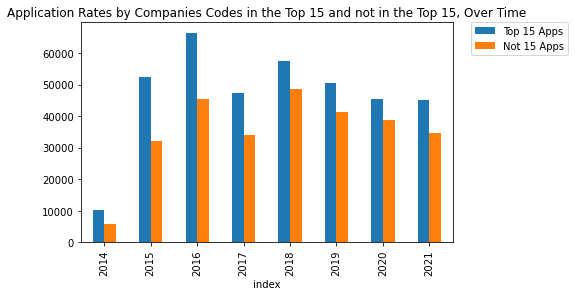

In [195]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
lanalysisdf = lanalysisdf.reset_index()
lanalysisdf["Top 15 Apps"] = pd.DataFrame(top15apps)
lanalysisdf["Not 15 Apps"] = pd.DataFrame(not15apps)
lanalysisdf = lanalysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
lanalysisdf.reset_index().plot(x = "index", y = ["Top 15 Apps","Not 15 Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Companies Codes in the Top 15 and not in the Top 15, Over Time")


In [196]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = lanalysisdf.loc[yr[x]]["Top 15 Success %"]
    sample2_phat = lanalysisdf.loc[yr[x]]["Not 15 Success %"]
    sample1_size = lanalysisdf.loc[yr[x]]["Top 15 Apps"]
    sample2_size = lanalysisdf.loc[yr[x]]["Not 15 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Top 15 Vs. Not Top 15"]
pvaldf.index = yr
lanalysisdf["PVAL Success %"] = pvaldf["Top 15 Vs. Not Top 15"]

In [197]:
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: TOP 15 COMPANY
print("Top 15 Company Codes Success Rate Over Time Slope:",round(st.linregress(y = lanalysisdf["Top 15 Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = lanalysisdf["Top 15 Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = lanalysisdf["Top 15 Success %"], x = yr).rvalue,4),"\nStrong growth, .75% growth in success rate a year, and a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: TOP 15 COMPANY
print("\nTop 15 Company Codes Application Rate Over Time Slope:",round(st.linregress(y = lanalysisdf["Top 15 Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = lanalysisdf["Top 15 Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = lanalysisdf["Top 15 Apps"], x = yr).rvalue,4),"\nModerate growth, 2068 applications a year, and not a statistically significant slope.")

# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: NOT TOP 15 COMPANY
print("\n\nNot Top 15 Company Codes Success Rate Over Time Slope:",round(st.linregress(y = lanalysisdf["Not 15 Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = lanalysisdf["Not 15 Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = lanalysisdf["Not 15 Success %"], x = yr).rvalue,4),"\nStrong growth, .47% growth in success rate a year, and a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: NOT TOP 15 COMPANY
print("\nNot Top 15 Company Codes Application Rate Over Time Slope:",round(st.linregress(y = lanalysisdf["Not 15 Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = lanalysisdf["Not 15 Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = lanalysisdf["Not 15 Apps"], x = yr).rvalue,4),"\nWeak growth, 2828 applications a year, but not a statistically significant slope.")


Top 15 Company Codes Success Rate Over Time Slope: 0.007902 , P Val: 0.0068 , R Val: 0.8554 
Strong growth, .75% growth in success rate a year, and a statistically significant slope.

Top 15 Company Codes Application Rate Over Time Slope: 2055.107 , P Val: 0.4603 , R Val: 0.3065 
Moderate growth, 2068 applications a year, and not a statistically significant slope.


Not Top 15 Company Codes Success Rate Over Time Slope: 0.005047 , P Val: 0.0445 , R Val: 0.7189 
Strong growth, .47% growth in success rate a year, and a statistically significant slope.

Not Top 15 Company Codes Application Rate Over Time Slope: 2811.821 , P Val: 0.1822 , R Val: 0.5243 
Weak growth, 2828 applications a year, but not a statistically significant slope.


In [198]:
# GETTING THE TOTAL PVAL
lanalysisdf.loc["ALL YRS"] = lanalysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = lanalysisdf.loc[yr[x]].iloc[0]*lanalysisdf.loc[yr[x]].iloc[2]
    n15 = lanalysisdf.loc[yr[x]].iloc[1]*lanalysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
lanalysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/lanalysisdf.loc["ALL YRS"].iloc[2]
lanalysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/lanalysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = lanalysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = lanalysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = lanalysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = lanalysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
lanalysisdf.loc["ALL YRS"].iloc[4] = pval

lanalysisdf = lanalysisdf.head(9).style.format("{:,.2f}")
lanalysisdf

,Top 15 Success %,Not 15 Success %,Top 15 Apps,Not 15 Apps,PVAL Success %
index,,,,,
2014,0.91,0.86,"10,179.00","5,820.00",0.00
2015,0.91,0.88,"52,288.00","32,027.00",0.00
2016,0.94,0.90,"66,371.00","45,407.00",0.00
2017,0.91,0.88,"47,232.00","33,902.00",0.00
2018,0.95,0.89,"57,562.00","48,582.00",0.00
2019,0.95,0.89,"50,465.00","41,350.00",0.00
2020,0.95,0.89,"45,262.00","38,616.00",0.00
2021,0.97,0.92,"45,200.00","34,497.00",0.00
ALL YRS,0.94,0.89,"374,559.00","280,201.00",0.00


In [199]:
#### APPLICATION / JOB RELATED #####

Text(0.5, 1.0, 'Annual Wages by Percentiles, Over Time')

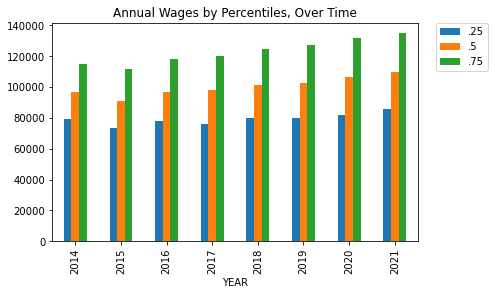

In [200]:
# GROUPBY YEAR AND PLOT THE .25, .5, and .75 WO_A
wages = pd.DataFrame([df.groupby("YEAR")["WO_A"].quantile(.25),df.groupby("YEAR")["WO_A"].quantile(.5),
 df.groupby("YEAR")["WO_A"].quantile(.75)]).transpose()
wages.columns = [".25",".5",".75"]
wages.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Annual Wages by Percentiles, Over Time")

In [201]:
# CORRELATION ANALYSIS: Wage offered and success
st.linregress(x = df.dropna()["WO_A"], y = df.dropna()["CASE_STATUS"])
# DOES NOT SHOW MUCH, AGGREGATE MAY SHOW A DIFFERENT STORY

LinregressResult(slope=4.1156818591638955e-07, intercept=0.8972001579576157, rvalue=0.0598361439336915, pvalue=0.0, stderr=9.833356453754695e-09, intercept_stderr=0.0011238291432392699)

In [202]:
# CREATING A NEW COLUMN: WAGE GROUP, SPLITS WAGES INTO THIRDS
high = df.groupby("YEAR")["WO_A"].quantile(2/3).tolist()
low = df.groupby("YEAR")["WO_A"].quantile(1/3).tolist()
df["WAGE_GROUP"] = np.nan
for x in range(len(yr)):
    df["WAGE_GROUP"] = np.where((df["YEAR"]==yr[x])&(df["WO_A"]<low[x]),"LOW",df["WAGE_GROUP"])
    df["WAGE_GROUP"] = np.where((df["YEAR"]==yr[x])&(df["WO_A"]>=low[x])&(df["WO_A"]<high[x]),"MED",df["WAGE_GROUP"])
    df["WAGE_GROUP"] = np.where((df["YEAR"]==yr[x])&(df["WO_A"]>=high[x]),"HIGH",df["WAGE_GROUP"])

Text(0.5, 1.0, 'Success Rates by Wage Bracket, Over Time')

<Figure size 1200x1000 with 0 Axes>

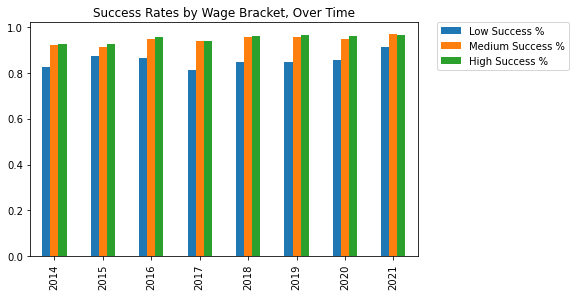

In [203]:
# CORRELATION ANALYSIS: AGGREGATE BY WAGE GROUP
# PLOTTING SUCCESS RATES OVER TIME BY WAGE GROUP

young = df[df["WAGE_GROUP"]=="LOW"]
mid = df[df["WAGE_GROUP"]=="MED"]
old = df[df["WAGE_GROUP"]=="HIGH"]


youndf = pd.DataFrame()
middf = pd.DataFrame()
olddf = pd.DataFrame()
linregdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(young[(young["YEAR"]==yr[x])&(young["CASE_STATUS"]==1)])/len(young[young["YEAR"]==yr[x]])])
    med = pd.DataFrame([len(mid[(mid["YEAR"]==yr[x])&(mid["CASE_STATUS"]==1)])/len(mid[mid["YEAR"]==yr[x]])])
    oldy = pd.DataFrame([len(old[(old["YEAR"]==yr[x])&(old["CASE_STATUS"]==1)])/len(old[old["YEAR"]==yr[x]])])
    youndf = pd.concat([youndf,j])
    middf = pd.concat([middf,med])
    olddf = pd.concat([olddf,oldy])
    linregdf = pd.concat([youndf,middf,olddf], axis = 1)
    

linregdf.index = yr
linregdf.columns = ["Low Success %", "Medium Success %", "High Success %"]
plt.figure(figsize = (12,10), dpi = 100)
linregdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Wage Bracket, Over Time")

In [204]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
youngapps = []
midapps = []
oldapps = []

for x in range(len(yr)):
    y = (young["YEAR"]==yr[x]).sum()
    m = (mid["YEAR"]==yr[x]).sum()
    o = (old["YEAR"]==yr[x]).sum()
    youngapps.append(y)
    midapps.append(m)
    oldapps.append(o)
linregdf = linregdf.reset_index()
linregdf["Low Apps"] = pd.DataFrame(youngapps)
linregdf["Medium Apps"] = pd.DataFrame(midapps)
linregdf["High Apps"] = pd.DataFrame(oldapps)
linregdf = linregdf.set_index("index")

# P VALUE PER YEAR
young_med = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Low Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Medium Success %"]
    sample1_size = linregdf.loc[yr[x]]["Low Apps"]
    sample2_size = linregdf.loc[yr[x]]["Medium Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    young_med.append(pval)

pvaldf = pd.DataFrame(young_med)

young_old = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Low Success %"]
    sample2_phat = linregdf.loc[yr[x]]["High Success %"]
    sample1_size = linregdf.loc[yr[x]]["Low Apps"]
    sample2_size = linregdf.loc[yr[x]]["High Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    young_old.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(young_old)], axis = 1)

med_old = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Medium Success %"]
    sample2_phat = linregdf.loc[yr[x]]["High Success %"]
    sample1_size = linregdf.loc[yr[x]]["Medium Apps"]
    sample2_size = linregdf.loc[yr[x]]["High Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    med_old.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(med_old)], axis = 1)
pvaldf.columns = ["Low_Med","Low_High","Med_High"]
pvaldf.index = yr
linregdf[["Low_Med","Low_High","Med_High"]] = pvaldf[["Low_Med","Low_High","Med_High"]]

In [205]:
# LINEAR REGRESSION BETWEEN COMPANY AGE AND SUCCESS RATE OVER TIME: Low Wage
print("Low Wage Success Rate Over Time Slope:",round(st.linregress(y = linregdf["Low Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = linregdf["Low Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Low Success %"], x = yr).rvalue,4),"\nModerate growth, .56% growth in success rate a year, and not a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY AGE AND APPLICATIONS OVER TIME: Low Wage
print("\nLow Wage Application Rate Over Time Slope:",round(st.linregress(y = linregdf["Low Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = linregdf["Low Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Low Apps"], x = yr).rvalue,4),"\nWeak growth, 1633 applications a year, and not a statistically significant slope.")

# LINEAR REGRESSION BETWEEN COMPANY AGE AND SUCCESS RATE OVER TIME: MEDIUM Wage
print("\n\nMedium Wage Success Rate Over Time Slope:",round(st.linregress(y = linregdf["Medium Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = linregdf["Medium Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Medium Success %"], x = yr).rvalue,4),"\nStrong growth, .64% growth in success rate a year, and a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY AGE AND APPLICATIONS OVER TIME: MEDIUM Wage
print("\nMedium Wage Application Rate Over Time Slope:",round(st.linregress(y = linregdf["Medium Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = linregdf["Medium Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["Medium Apps"], x = yr).rvalue,4),"\nModerate growth, 1688 applications a year, and not a statistically significant slope.")

# LINEAR REGRESSION BETWEEN COMPANY AGE AND SUCCESS RATE OVER TIME: OLD COMPANY
print("\n\nHigh Wage Success Rate Over Time Slope:",round(st.linregress(y = linregdf["High Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = linregdf["High Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["High Success %"], x = yr).rvalue,4),"\nStrong growth, .67% growth in success rate a year, and a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY AGE AND APPLICATIONS OVER TIME: OLD COMPANY
print("\nHigh Wage Application Rate Over Time Slope:",round(st.linregress(y = linregdf["High Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = linregdf["High Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = linregdf["High Apps"], x = yr).rvalue,4),"\nModerate growth, 1575 applications a year, and not a statistically significant slope.")

Low Wage Success Rate Over Time Slope: 0.006031 , P Val: 0.2241 , R Val: 0.4841 
Moderate growth, .56% growth in success rate a year, and not a statistically significant slope.

Low Wage Application Rate Over Time Slope: 1614.964 , P Val: 0.3139 , R Val: 0.4094 
Weak growth, 1633 applications a year, and not a statistically significant slope.


Medium Wage Success Rate Over Time Slope: 0.006533 , P Val: 0.0093 , R Val: 0.8384 
Strong growth, .64% growth in success rate a year, and a statistically significant slope.

Medium Wage Application Rate Over Time Slope: 1682.321 , P Val: 0.2887 , R Val: 0.4292 
Moderate growth, 1688 applications a year, and not a statistically significant slope.


High Wage Success Rate Over Time Slope: 0.00584 , P Val: 0.0092 , R Val: 0.8392 
Strong growth, .67% growth in success rate a year, and a statistically significant slope.

High Wage Application Rate Over Time Slope: 1569.643 , P Val: 0.3398 , R Val: 0.3898 
Moderate growth, 1575 applications a year, a

In [206]:
# GETTING THE TOTAL PVAL
linregdf.loc["ALL YRS"] = linregdf.sum()
youngsuc = []
medsuc = []
oldsuc = []
for x in range(len(yr)):
    y = linregdf.loc[yr[x]].iloc[0]*linregdf.loc[yr[x]].iloc[3]
    m = linregdf.loc[yr[x]].iloc[1]*linregdf.loc[yr[x]].iloc[4]
    o = linregdf.loc[yr[x]].iloc[2]*linregdf.loc[yr[x]].iloc[5]
    youngsuc.append(y)
    medsuc.append(m)
    oldsuc.append(o)
linregdf.loc["ALL YRS"].iloc[0] = sum(youngsuc)/linregdf.loc["ALL YRS"].iloc[3]
linregdf.loc["ALL YRS"].iloc[1] = sum(medsuc)/linregdf.loc["ALL YRS"].iloc[4]
linregdf.loc["ALL YRS"].iloc[2] = sum(oldsuc)/linregdf.loc["ALL YRS"].iloc[5]


for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample1_size = linregdf.loc["ALL YRS"].iloc[3]
    sample2_size = linregdf.loc["ALL YRS"].iloc[4]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[6] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[3]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[7] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[8] = pval
linregdf = linregdf.head(9).style.format("{:,.2f}")
linregdf

,Low Success %,Medium Success %,High Success %,Low Apps,Medium Apps,High Apps,Low_Med,Low_High,Med_High
index,,,,,,,,,
2014,0.83,0.92,0.92,"5,329.00","5,333.00","5,337.00",0.00,0.00,0.73
2015,0.87,0.91,0.92,"27,918.00","27,773.00","28,624.00",0.00,0.00,0.00
2016,0.87,0.95,0.96,"36,948.00","36,728.00","38,102.00",0.00,0.00,0.00
2017,0.81,0.94,0.94,"27,040.00","26,915.00","27,179.00",0.00,0.00,0.53
2018,0.85,0.96,0.96,"35,367.00","35,187.00","35,590.00",0.00,0.00,0.00
2019,0.85,0.95,0.96,"30,599.00","30,596.00","30,620.00",0.00,0.00,0.00
2020,0.86,0.94,0.96,"27,939.00","27,979.00","27,960.00",0.00,0.00,0.00
2021,0.91,0.97,0.96,"26,225.00","26,820.00","26,652.00",0.00,0.00,0.00
ALL YRS,0.86,0.95,0.95,"217,365.00","217,331.00","220,064.00",0.00,0.00,0.00


In [207]:
# Distribution of people in the 66th percentile and above in Wages

joby = df[df["WAGE_GROUP"]=="HIGH"].groupby("WORKSITE_STATE")["CASE_STATUS"].value_counts()
jobyer = pd.DataFrame(joby.groupby(level=0).transform(lambda x: (x / x.sum()).round(2)))
jobyer.columns = ["Percent"]
f1 = jobyer.reset_index()["WORKSITE_STATE"].tolist()
t1 = jobyer.reset_index()["CASE_STATUS"].replace(1,"Accept").replace(0,"Reject").tolist()
idx1 = []
idx1.extend([tuple(a) for a in zip (f1,t1)])
jobyer.index = pd.MultiIndex.from_tuples(idx1)
jobyer = jobyer.reset_index()
jobyer = jobyer[jobyer["level_1"]=="Accept"]
jobyer = jobyer.drop("level_1",axis = 1)

jobycount = pd.DataFrame(df[df["WAGE_GROUP"]=="HIGH"].groupby("WORKSITE_STATE")["CASE_STATUS"].value_counts())
jobycount.columns = ["Count"]
jobycount = jobycount.reset_index()
jobycount = jobycount[jobycount["CASE_STATUS"]==1]
jobycount = jobycount["Count"]

jobyer = pd.concat([jobyer, jobycount], axis = 1)
jobyer.columns = ["State","Text","Count"]
jobyer["Text"] = jobyer["State"].astype(str)+": "+jobyer["Text"].astype(str)+" Percent Successful"
# Choropleth Map of JOB State Accept %
data = dict(type = "choropleth",
           locations = jobyer["State"],
           locationmode = "USA-states",
           z = jobyer["Count"].astype(float),
           text = jobyer["Text"],
           colorbar={"title":"Count"},
           colorscale = "sunset",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Distribution of Top 66 Percentile Wages",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [208]:
# PW_SOC_CODE ANALYSIS
# Top 5 PW_SOC of all time 2014-2021
allsoc = pd.DataFrame(df["PW_SOC_CODE"].value_counts()[:5]).reset_index()
allsoc.columns = ["ASoc","COUNT ASoc"]
sucsoc = pd.DataFrame(df[df["CASE_STATUS"]==1]["PW_SOC_CODE"].value_counts()[:5]).reset_index()
sucsoc.columns = ["SSoc","COUNT SSoc"]
pd.concat([allsoc,sucsoc], axis = 1)

,ASoc,COUNT ASoc,SSoc,COUNT SSoc
0,15-1132,209823,15-1132,199458
1,15-1133,62314,15-1133,59834
2,15-1121,59447,15-1121,56656
3,15-1199,24934,15-1199,23927
4,17-2072,19903,17-2072,18712


In [209]:
# Grabbing the top 5 for each year PW CODE: only succesful applications
top5semp = pd.DataFrame()
def grab (year):
    return df[(df["YEAR"]==year)&(df["CASE_STATUS"]==1)]["PW_SOC_CODE"].value_counts()[:5]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top5semp = pd.concat([top5semp,j], axis = 1)
top5semp.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS PW CODE NOT IN THE TOP 5?: TOP CONSISTENT COMPANIES...
kingcons = top5semp.isnull().replace(False,0).replace(True,1)
kingcons["Yrs not in Top 5"] = top5semp.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingcons["Yrs not in Top 5"].sort_values()[:10]


15-1132    0
15-1121    0
15-1133    0
17-2072    2
15-1199    3
11-2100    6
15-2041    6
11-3021    7
Name: Yrs not in Top 5, dtype: int64

In [210]:
# Grabbing the top 5 for each year PW CODE: total applications
top5aemp = pd.DataFrame()
def grab (year):
    return df[df["YEAR"]==year]["PW_SOC_CODE"].value_counts()[:5]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top5aemp = pd.concat([top5aemp,j], axis = 1)
top5aemp.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS PW CODE NOT IN THE TOP 5?: TOP CONSISTENT COMPANIES...
kingconsA = top5aemp.isnull().replace(False,0).replace(True,1)
kingconsA["Yrs not in Top 5"] = top5aemp.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingconsA["Yrs not in Top 5"].sort_values()[:10]


15-1132    0
15-1121    0
15-1133    0
17-2072    2
15-1199    3
11-2100    6
15-2041    6
11-3021    7
Name: Yrs not in Top 5, dtype: int64

In [211]:
# DIVING DEEPER INTO THE TOP CODES!
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = "15-1132"
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY PW LEVEL
topstate = df[df["PW_SOC_CODE"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf


TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
CA    LEVEL I                 4944    113000.0                  4.0   
      LEVEL II               16594    120000.0                  5.0   
      LEVEL III               8308    133016.0                  6.0   
      LEVEL IV                9085    142168.0                 11.0   
TX    LEVEL I                 1084     72865.0                  9.0   
      LEVEL II               10506     90000.0                  9.0   
      LEVEL III               5745     97115.0                 10.0   
      LEVEL IV               12691     87422.0                 11.0   
NJ    LEVEL I                  778     73545.0                 10.0   
      LEVEL II                7849     92768.0                  9.0   
      LEVEL III               7514    111114.0                 10.0   
      LEVEL IV                5852    123594.0                 12.0   
WA    LEVEL I                 4266    113560.0                  4.0   
      LEVEL II                9936    114000.0                  4.0   
      LEVEL III               2900    133686.0                  9.0   
      LEVEL IV                1957    151274.0                 11.0   
NY    LEVEL I                  961    102040.0                  5.0   
      LEVEL II                4045     96600.0                  6.0   
      LEVEL III               1816    117030.0                  9.0   
      LEVEL IV                4265    135283.0                 12.0   
IL    LEVEL I                  705     71215.0                  9.0   
      LEVEL II                2551     83000.0                  8.0   
      LEVEL III               3400     96658.0                 10.0   
      LEVEL IV                2705    112000.0                 11.0   
MA    LEVEL I                  450     85095.0                  5.0   
      LEVEL II                2915     91874.0                  6.0   
      LEVEL III               2275    110250.0                 10.0   
      LEVEL IV                1964    127421.0                 11.0   
VA    LEVEL I                  477     75712.0                  6.0   
      LEVEL II                2818     93933.0                  8.0   
      LEVEL III               1736    113755.0                  7.0   
      LEVEL IV                1984   130025.21                 12.0   
MI    LEVEL I                  196    67999.94                  8.0   
      LEVEL II                1860     78125.0                  8.0   
      LEVEL III               2306     86715.0                  9.0   
      LEVEL IV                1639    101483.0                 12.0   
GA    LEVEL I                  365     73000.0                  9.0   
      LEVEL II                1757     84240.0                  8.0   
      LEVEL III               1301    103688.0                  7.0   
      LEVEL IV                2362    113800.0                 12.0   
PA    LEVEL I                  514     71386.0                  7.0   
      LEVEL II                1686     84552.0                  9.0   
      LEVEL III               1077    103563.0                 10.0   
      LEVEL IV                2550    103085.0                 11.0   
FL    LEVEL I                  629     74880.0                  9.0   
      LEVEL II                2218     74880.0                  9.0   
      LEVEL III               1085     90000.0                  9.0   
      LEVEL IV                1400    107806.0                 12.0   
NC    LEVEL I                  154     77000.0                  8.0   
      LEVEL II                1043     88190.0                  8.0   
      LEVEL III                850     98675.0                 10.0   
      LEVEL IV                1279    117333.0                 12.0   
OH    LEVEL I                  185     75000.0                  7.0   
      LEVEL II                 789     84000.0                  8.0   
      LEVEL III                667     9

In [212]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SOC_CODE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
CA    HIGH SCHOOL                 21    113750.0                 18.0   
      ASSOCIATE'S                 58    121118.5                 15.0   
      BACHELOR'S               16036    130000.0                 10.0   
      MASTER'S                 27380    124675.0                  5.0   
      DOCTORATE                 1634    135000.0                  3.0   
...                              ...         ...                  ...   
AZ    ASSOCIATE'S                  1     60258.0                  3.0   
      BACHELOR'S                1360    104031.0                 11.0   
      MASTER'S                  1038     91902.5                  7.0   
      DOCTORATE                    2    123370.0                  3.0   
      OTHER                       11    108514.0                 16.0   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
CA    HIGH SCHOOL                 156.0  
      ASSOCIATE'S                 172.0  
      BACHELOR'S              135.40147  
      MASTER'S                    141.0  
      DOCTORATE                   137.0  
...                                 ...  
AZ    ASSOCIATE'S                 252.0  
      BACHELOR'S                  126.0  
      MASTER'S               134.935521  
      DOCTORATE              133.049398  
      OTHER                       100.0  

[90 rows x 4 columns]

In [213]:
# NEW COLUMN: 1 is in the top 5 of the YEAR, 0 is not: Applications
filler = pd.DataFrame()
for x in range(len(yr)):
    listy = top5aemp[yr[x]].dropna().index.tolist()
    filler = pd.concat([filler,pd.DataFrame((df[df["YEAR"]==yr[x]]["PW_SOC_CODE"].isin(listy)).replace(True,1).replace(False,0))])

filler = filler.reset_index().sort_values(by = "index").set_index("index")
filler.columns = ["TOP5SOC"]
df["TOP5SOC"] = filler

In [214]:
# Distribution of the states worked in if within top 5 pw code

joby = df[df["TOP5SOC"]==1].groupby("WORKSITE_STATE")["CASE_STATUS"].value_counts()
jobyer = pd.DataFrame(joby.groupby(level=0).transform(lambda x: (x / x.sum()).round(2)))
jobyer.columns = ["Percent"]
f1 = jobyer.reset_index()["WORKSITE_STATE"].tolist()
t1 = jobyer.reset_index()["CASE_STATUS"].replace(1,"Accept").replace(0,"Reject").tolist()
idx1 = []
idx1.extend([tuple(a) for a in zip (f1,t1)])
jobyer.index = pd.MultiIndex.from_tuples(idx1)
jobyer = jobyer.reset_index()
jobyer = jobyer[jobyer["level_1"]=="Accept"]
jobyer = jobyer.drop("level_1",axis = 1)

jobycount = pd.DataFrame(df[df["TOP5SOC"]==1].groupby("WORKSITE_STATE")["CASE_STATUS"].value_counts())
jobycount.columns = ["Count"]
jobycount = jobycount.reset_index()
jobycount = jobycount[jobycount["CASE_STATUS"]==1]
jobycount = jobycount["Count"]

jobyer = pd.concat([jobyer, jobycount], axis = 1)
jobyer.columns = ["State","Text","Count"]
jobyer["Text"] = jobyer["State"].astype(str)+": "+jobyer["Text"].astype(str)+" Percent Successful"
# Choropleth Map of JOB State Accept %
data = dict(type = "choropleth",
           locations = jobyer["State"],
           locationmode = "USA-states",
           z = jobyer["Count"].astype(float),
           text = jobyer["Text"],
           colorbar={"title":"Count"},
           colorscale = "jet",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Distribution of Top 5 SOC Code",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [215]:
# CORRELATION ANALYSIS: TOP 5 PW CODE WITH CASE STATUS: CASE BY CASE
st.linregress(x = df.dropna()["TOP5SOC"], y = df.dropna()["CASE_STATUS"])
# DOES NOT SHOW MUCH, AGGREGATE MAY SHOW A DIFFERENT STORY

LinregressResult(slope=0.03375291696229249, intercept=0.9194033780987848, rvalue=0.06781213448811717, pvalue=0.0, stderr=0.0007112225046501629, intercept_stderr=0.000583393842199935)

Text(0.5, 1.0, 'Success Rates by Applicants in the Top 5 and not in the Top 5 Job Codes, Over Time')

<Figure size 1200x1000 with 0 Axes>

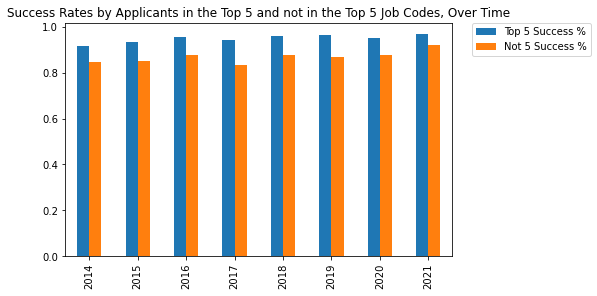

In [216]:
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY TOP 15 COMPANY (IN TERMS OF ANNUAL APPLICATIONS)
top15 = df[df["TOP5SOC"]==1]
not15 = df[df["TOP5SOC"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["Top 5 Success %", "Not 5 Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Applicants in the Top 5 and not in the Top 5 Job Codes, Over Time")

Text(0.5, 1.0, 'Application Rates by Companies in the Top 5 and not in the Top 5 Job Codes, Over Time')

<Figure size 1200x1000 with 0 Axes>

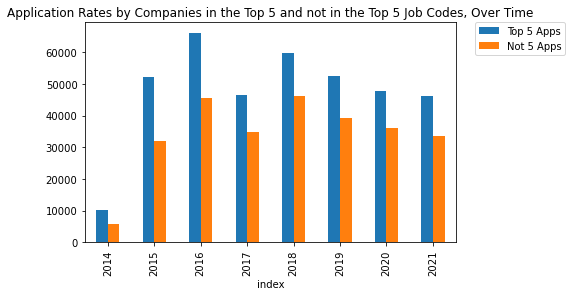

In [217]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["Top 5 Apps"] = pd.DataFrame(top15apps)
analysisdf["Not 5 Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["Top 5 Apps","Not 5 Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Companies in the Top 5 and not in the Top 5 Job Codes, Over Time")

In [218]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["Top 5 Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not 5 Success %"]
    sample1_size = analysisdf.loc[yr[x]]["Top 5 Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not 5 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Top 5 Vs. Not Top 5"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["Top 5 Vs. Not Top 5"]

In [219]:
# LINEAR REGRESSION BETWEEN Code AND SUCCESS RATE OVER TIME: TOP 5 Code
print("Top 5 Code Success Rate Over Time Slope:",round(st.linregress(y = analysisdf["Top 5 Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = analysisdf["Top 5 Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = analysisdf["Top 5 Success %"], x = yr).rvalue,4),"\nStrong growth, .56% growth in success rate a year, and a statistically significant slope.")
# LINEAR REGRESSION BETWEEN Code AND APPLICATIONS OVER TIME: TOP 5 Code
print("\nTop 5 Code Application Rate Over Time Slope:",round(st.linregress(y = analysisdf["Top 5 Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = analysisdf["Top 5 Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = analysisdf["Top 5 Apps"], x = yr).rvalue,4),"\nModerate growth, 2326 applications a year, but not a statistically significant slope.")

# LINEAR REGRESSION BETWEEN Code AND SUCCESS RATE OVER TIME: NOT TOP 5 Code
print("\n\nNot Top 5 Code Success Rate Over Time Slope:",round(st.linregress(y = analysisdf["Not 5 Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = analysisdf["Not 5 Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = analysisdf["Not 5 Success %"], x = yr).rvalue,4),"\nStrong growth, .79% growth in success rate a year, and a statistically significant slope.")
# LINEAR REGRESSION BETWEEN Code AND APPLICATIONS OVER TIME: NOT TOP 5 Code
print("\nNot Top 5 Code Application Rate Over Time Slope:",round(st.linregress(y = analysisdf["Not 5 Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = analysisdf["Not 5 Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = analysisdf["Not 5 Apps"], x = yr).rvalue,4),"\nModerate growth, 2570 applications a year, but not a statistically significant slope.")


Top 5 Code Success Rate Over Time Slope: 0.00585 , P Val: 0.0084 , R Val: 0.8443 
Strong growth, .56% growth in success rate a year, and a statistically significant slope.

Top 5 Code Application Rate Over Time Slope: 2412.345 , P Val: 0.3895 , R Val: 0.3541 
Moderate growth, 2326 applications a year, but not a statistically significant slope.


Not Top 5 Code Success Rate Over Time Slope: 0.00798 , P Val: 0.0406 , R Val: 0.7281 
Strong growth, .79% growth in success rate a year, and a statistically significant slope.

Not Top 5 Code Application Rate Over Time Slope: 2454.583 , P Val: 0.2322 , R Val: 0.4768 
Moderate growth, 2570 applications a year, but not a statistically significant slope.


In [220]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,Top 5 Success %,Not 5 Success %,Top 5 Apps,Not 5 Apps,PVAL Success %
index,,,,,
2014,0.92,0.85,"10,082.00","5,917.00",0.00
2015,0.93,0.85,"52,217.00","32,098.00",0.00
2016,0.96,0.87,"66,125.00","45,653.00",0.00
2017,0.94,0.83,"46,456.00","34,678.00",0.00
2018,0.96,0.88,"59,859.00","46,285.00",0.00
2019,0.96,0.87,"52,459.00","39,356.00",0.00
2020,0.95,0.88,"47,673.00","36,205.00",0.00
2021,0.97,0.92,"46,218.00","33,479.00",0.00
ALL YRS,0.95,0.87,"381,089.00","273,671.00",0.00


In [221]:
# Top 10 WORK STATE of all time 2014-2021
allsoc = pd.DataFrame(df["WORKSITE_STATE"].value_counts()[:10]).reset_index()
allsoc.columns = ["AState","COUNT AState"]
sucsoc = pd.DataFrame(df[df["CASE_STATUS"]==1]["WORKSITE_STATE"].value_counts()[:10]).reset_index()
sucsoc.columns = ["SState","COUNT SState"]
pd.concat([allsoc,sucsoc], axis = 1)

,AState,COUNT AState,SState,COUNT SState
0,CA,158469,CA,148082
1,TX,80063,TX,74040
2,NY,51545,NY,47928
3,NJ,47491,WA,44103
4,WA,45804,NJ,43551
5,IL,25217,IL,23397
6,MA,22847,MA,21478
7,MI,21313,MI,20028
8,FL,20241,VA,17632
9,GA,19775,FL,17548


In [222]:
# ACCEPT % BASED ON STATE WORKED IN

joby = df.groupby("WORKSITE_STATE")["CASE_STATUS"].value_counts()
jobyer = pd.DataFrame(joby.groupby(level=0).transform(lambda x: (x / x.sum()).round(2)))
jobyer.columns = ["Percent"]
f1 = jobyer.reset_index()["WORKSITE_STATE"].tolist()
t1 = jobyer.reset_index()["CASE_STATUS"].replace(1,"Accept").replace(0,"Reject").tolist()
idx1 = []
idx1.extend([tuple(a) for a in zip (f1,t1)])
jobyer.index = pd.MultiIndex.from_tuples(idx1)
jobyer = jobyer.reset_index()
jobyer = jobyer[jobyer["level_1"]=="Accept"]
jobyer = jobyer.drop("level_1",axis = 1)

jobycount = pd.DataFrame(df.groupby("WORKSITE_STATE")["CASE_STATUS"].value_counts())
jobycount.columns = ["Count"]
jobycount = jobycount.reset_index()
jobycount = jobycount[jobycount["CASE_STATUS"]==1]
jobycount = jobycount["Count"]

jobyer = pd.concat([jobyer, jobycount], axis = 1)
jobyer.columns = ["State","Percent","Count"]
jobyer["Count"] = jobyer["State"].astype(str)+": "+jobyer["Count"].astype(str)+" Successful Applications"
# Choropleth Map of JOB State Accept %
data = dict(type = "choropleth",
           locations = jobyer["State"],
           locationmode = "USA-states",
           z = jobyer["Percent"].astype(float),
           text = jobyer["Count"],
           colorbar={"title":"Percent Accepted"},
           colorscale = "earth",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Percent Accepted in States Worked In",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [223]:
# Grabbing the top 5 for each year state worked in: total applications
top5aemp = pd.DataFrame()
def grab (year):
    return df[df["YEAR"]==year]["WORKSITE_STATE"].value_counts()[:5]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top5aemp = pd.concat([top5aemp,j], axis = 1)
top5aemp.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS state NOT IN THE TOP 5?: TOP CONSISTENT states...
kingconsA = top5aemp.isnull().replace(False,0).replace(True,1)
kingconsA["Yrs not in Top 5"] = top5aemp.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingconsA["Yrs not in Top 5"].sort_values()[:10]


CA    0
TX    0
NJ    0
NY    0
WA    1
IL    7
Name: Yrs not in Top 5, dtype: int64

In [224]:
# NEW COLUMN: 1 is in the top 5 of the YEAR, 0 is not: Applications
filler = pd.DataFrame()
for x in range(len(yr)):
    listy = top5aemp[yr[x]].dropna().index.tolist()
    filler = pd.concat([filler,pd.DataFrame((df[df["YEAR"]==yr[x]]["WORKSITE_STATE"].isin(listy)).replace(True,1).replace(False,0))])

filler = filler.reset_index().sort_values(by = "index").set_index("index")
filler.columns = ["TOP5WORKSTATE"]
df["TOP5WORKSTATE"] = filler

In [225]:
# CORRELATION ANALYSIS: TOP 5 WORK STATE WITH CASE STATUS: CASE BY CASE
st.linregress(x = df.dropna()["TOP5WORKSTATE"], y = df.dropna()["CASE_STATUS"])
# DOES NOT SHOW MUCH, AGGREGATE MAY SHOW A DIFFERENT STORY

LinregressResult(slope=0.009987803028107494, intercept=0.9358798039665128, rvalue=0.020714823661740617, pvalue=2.0094903910629396e-47, stderr=0.0006903955364100613, intercept_stderr=0.0005454363568783675)

Text(0.5, 1.0, 'Success Rates by Applicants in the Top 5 and not in the Top 5 States, Over Time')

<Figure size 1200x1000 with 0 Axes>

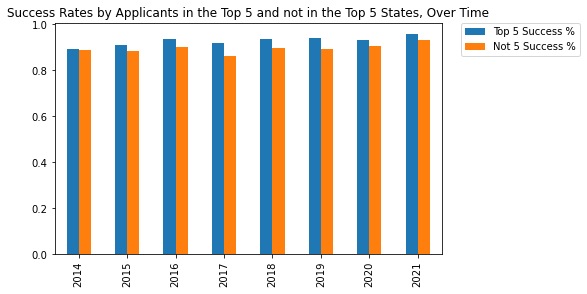

In [226]:
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY TOP 5 COMPANY (IN TERMS OF ANNUAL APPLICATIONS)
top15 = df[df["TOP5WORKSTATE"]==1]
not15 = df[df["TOP5WORKSTATE"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["Top 5 Success %", "Not 5 Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Applicants in the Top 5 and not in the Top 5 States, Over Time")


Text(0.5, 1.0, 'Application Rates by Companies in the Top 5 and not in the Top 5 States, Over Time')

<Figure size 1200x1000 with 0 Axes>

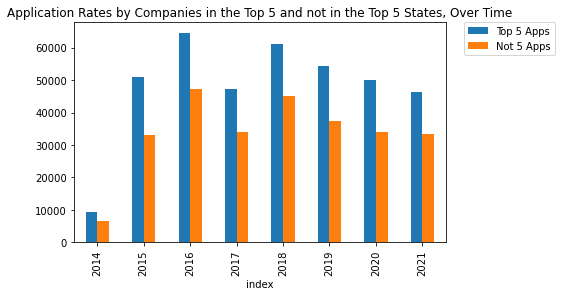

In [227]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["Top 5 Apps"] = pd.DataFrame(top15apps)
analysisdf["Not 5 Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 5 or NOT TOP 5
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["Top 5 Apps","Not 5 Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Companies in the Top 5 and not in the Top 5 States, Over Time")

In [228]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["Top 5 Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not 5 Success %"]
    sample1_size = analysisdf.loc[yr[x]]["Top 5 Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not 5 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Top 5 Vs. Not Top 5"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["Top 5 Vs. Not Top 5"]

In [229]:
# LINEAR REGRESSION BETWEEN TOP STATES AND SUCCESS RATE OVER TIME: TOP 5 STATES
print("top 5 success rate over time:",st.linregress(y = analysisdf["Top 5 Success %"], x = yr))
print("\ntop 5 applications over time:",st.linregress(y = analysisdf["Top 5 Apps"], x = yr))

print("\n\nnottop 5 success rate over time:",st.linregress(y = analysisdf["Not 5 Success %"], x = yr))
print("\nnot top 5 applications over time:",st.linregress(y = analysisdf["Not 5 Apps"], x = yr))

top 5 success rate over time: LinregressResult(slope=0.007105859520446345, intercept=-13.407552252916581, rvalue=0.8374632695019153, pvalue=0.009468752915204569, stderr=0.0018930422934449803, intercept_stderr=3.8192152900906344)

top 5 applications over time: LinregressResult(slope=2821.2261904761904, intercept=-5643819.214285714, rvalue=0.4093766201394572, pvalue=0.3138660420585565, stderr=2566.8949424818406, intercept_stderr=5178713.88628217)


nottop 5 success rate over time: LinregressResult(slope=0.00476712016102337, intercept=-8.721075956694092, rvalue=0.5749147934127896, pvalue=0.13601272076867046, stderr=0.0027697687870418433, intercept_stderr=5.588012131644142)

not top 5 applications over time: LinregressResult(slope=2045.702380952381, intercept=-4093364.1785714286, rvalue=0.40736642485510594, pvalue=0.3164828504378118, stderr=1872.3123977851158, intercept_stderr=3777392.6986248833)


In [230]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,Top 5 Success %,Not 5 Success %,Top 5 Apps,Not 5 Apps,PVAL Success %
index,,,,,
2014,0.89,0.89,"9,379.00","6,620.00",0.88
2015,0.91,0.89,"51,096.00","33,219.00",0.00
2016,0.94,0.90,"64,551.00","47,227.00",0.00
2017,0.92,0.86,"47,151.00","33,983.00",0.00
2018,0.94,0.90,"61,082.00","45,062.00",0.00
2019,0.94,0.89,"54,465.00","37,350.00",0.00
2020,0.93,0.90,"49,874.00","34,004.00",0.00
2021,0.96,0.93,"46,439.00","33,258.00",0.00
ALL YRS,0.93,0.90,"384,037.00","270,723.00",0.00


In [231]:
# Top 10 WORK Cities of all time 2014-2021
allsoc = pd.DataFrame(df["WORKSITE_CITY"].value_counts()[:10]).reset_index()
allsoc.columns = ["ACity","COUNT ACity"]
sucsoc = pd.DataFrame(df[df["CASE_STATUS"]==1]["WORKSITE_CITY"].value_counts()[:10]).reset_index()
sucsoc.columns = ["SCity","COUNT SCity"]
pd.concat([allsoc,sucsoc], axis = 1)

,ACity,COUNT ACity,SCity,COUNT SCity
0,NEW YORK,38688,NEW YORK,36688
1,SEATTLE,22467,SEATTLE,21991
2,SAN FRANCISCO,19619,SAN FRANCISCO,18680
3,COLLEGE STATION,18500,COLLEGE STATION,18418
4,REDMOND,16838,MOUNTAIN VIEW,16194
5,MOUNTAIN VIEW,16605,REDMOND,16072
6,SAN JOSE,16010,SAN JOSE,15331
7,SANTA CLARA,11945,SANTA CLARA,11196
8,CHICAGO,11013,CHICAGO,10419
9,SUNNYVALE,10753,SUNNYVALE,10284


In [232]:
# Grabbing the top 5 for each year state worked in: total applications
top5aemp = pd.DataFrame()
def grab (year):
    return df[df["YEAR"]==year]["WORKSITE_CITY"].value_counts()[:10]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top5aemp = pd.concat([top5aemp,j], axis = 1)
top5aemp.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS state NOT IN THE TOP 5?: TOP CONSISTENT states...
kingconsA = top5aemp.isnull().replace(False,0).replace(True,1)
kingconsA["Yrs not in Top 10"] = top5aemp.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingconsA["Yrs not in Top 10"].sort_values()[:10]


NEW YORK           0
SAN JOSE           0
MOUNTAIN VIEW      0
SAN FRANCISCO      0
SANTA CLARA        0
SUNNYVALE          0
SEATTLE            0
REDMOND            1
CHICAGO            3
COLLEGE STATION    4
Name: Yrs not in Top 10, dtype: int64

In [233]:
# NEW COLUMN: 1 is in the top 5 of the YEAR, 0 is not: Applications
filler = pd.DataFrame()
for x in range(len(yr)):
    listy = top5aemp[yr[x]].dropna().index.tolist()
    filler = pd.concat([filler,pd.DataFrame((df[df["YEAR"]==yr[x]]["WORKSITE_CITY"].isin(listy)).replace(True,1).replace(False,0))])

filler = filler.reset_index().sort_values(by = "index").set_index("index")
filler.columns = ["TOP10WORKCITY"]
df["TOP10WORKCITY"] = filler

In [234]:
# CORRELATION ANALYSIS: TOP 10 WORK CITY WITH CASE STATUS: CASE BY CASE
st.linregress(x = df.dropna()["TOP10WORKCITY"], y = df.dropna()["CASE_STATUS"])
# DOES NOT SHOW MUCH, AGGREGATE MAY SHOW A DIFFERENT STORY

LinregressResult(slope=0.032351719312194806, intercept=0.9315464495356112, rvalue=0.06497038877888679, pvalue=0.0, stderr=0.0007116489194524091, intercept_stderr=0.0004067231456352893)

Text(0.5, 1.0, 'Success Rates by Applicants in the Top 10 and not in the Top 10 Cities, Over Time')

<Figure size 1200x1000 with 0 Axes>

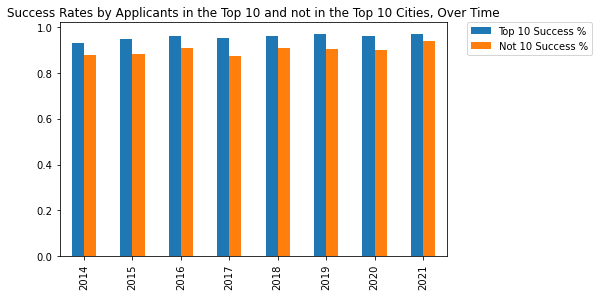

In [235]:
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY TOP 10 COMPANY (IN TERMS OF ANNUAL APPLICATIONS)
top15 = df[df["TOP10WORKCITY"]==1]
not15 = df[df["TOP10WORKCITY"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["Top 10 Success %", "Not 10 Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Applicants in the Top 10 and not in the Top 10 Cities, Over Time")

Text(0.5, 1.0, 'Application Rates by Companies in the Top 10 and not in the Top 10 Cities, Over Time')

<Figure size 1200x1000 with 0 Axes>

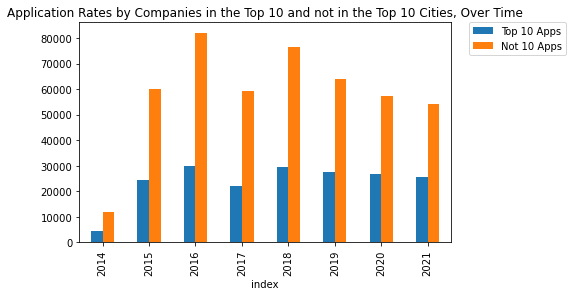

In [236]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["Top 10 Apps"] = pd.DataFrame(top15apps)
analysisdf["Not 10 Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 10 or NOT TOP 10
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["Top 10 Apps","Not 10 Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Companies in the Top 10 and not in the Top 10 Cities, Over Time")

In [237]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["Top 10 Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not 10 Success %"]
    sample1_size = analysisdf.loc[yr[x]]["Top 10 Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not 10 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Top 10 Vs. Not Top 10"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["Top 10 Vs. Not Top 10"]


In [238]:
# LINEAR REGRESSION BETWEEN TOP CITIES AND SUCCESS RATE OVER TIME: TOP 10 CITIES
print("top 10 success rate over time:",st.linregress(y = analysisdf["Top 10 Success %"], x = yr))
print("\ntop 10 applications over time:",st.linregress(y = analysisdf["Top 10 Apps"], x = yr))

print("\n\nnot top 10 success rate over time:",st.linregress(y = analysisdf["Not 10 Success %"], x = yr))
print("\nnot top 10 applications over time:",st.linregress(y = analysisdf["Not 10 Apps"], x = yr))

top 10 success rate over time: LinregressResult(slope=0.004480137999532093, intercept=-8.081942812323977, rvalue=0.8444158794401407, pvalue=0.008350865034566037, stderr=0.0011603030547901602, intercept_stderr=2.340912922726651)

top 10 applications over time: LinregressResult(slope=1917.702380952381, intercept=-3845249.4285714286, rvalue=0.5679508378857608, pvalue=0.14193496845624962, stderr=1134.5604546331185, intercept_stderr=2288977.193415741)


not top 10 success rate over time: LinregressResult(slope=0.006295013160281007, intercept=-11.801595231051445, rvalue=0.7376864027055625, pvalue=0.036711820413327156, stderr=0.0023520434577333376, intercept_stderr=4.745250736255614)

not top 10 applications over time: LinregressResult(slope=2949.2261904761904, intercept=-5891933.964285714, rvalue=0.342094905335987, pvalue=0.4068588311372496, stderr=3307.189564626402, intercept_stderr=6672259.249667129)


In [239]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,Top 10 Success %,Not 10 Success %,Top 10 Apps,Not 10 Apps,PVAL Success %
index,,,,,
2014,0.93,0.88,"4,306.00","11,693.00",0.00
2015,0.95,0.88,"24,313.00","60,002.00",0.00
2016,0.96,0.91,"29,715.00","82,063.00",0.00
2017,0.95,0.87,"21,968.00","59,166.00",0.00
2018,0.96,0.91,"29,693.00","76,451.00",0.00
2019,0.97,0.90,"27,660.00","64,155.00",0.00
2020,0.96,0.90,"26,614.00","57,264.00",0.00
2021,0.97,0.94,"25,452.00","54,245.00",0.00
ALL YRS,0.96,0.90,"189,721.00","465,039.00",0.00


In [240]:
# CREATING A NEW COLUMN: SPLITTING THE REQUIRED EDUCATION LEVEL INTO 4 GROUPS
df["REQ_EDU_GROUP"] = np.nan
for x in range(len(yr)):
    df["REQ_EDU_GROUP"] = np.where((df["MINIMUM_EDUCATION"]=="HIGH SCHOOL")|(df["MINIMUM_EDUCATION"]=="ASSOCIATE'S"),"LOWER",df["REQ_EDU_GROUP"])
    df["REQ_EDU_GROUP"] = np.where(df["MINIMUM_EDUCATION"]=="BACHELOR'S","COLLEGE",df["REQ_EDU_GROUP"])
    df["REQ_EDU_GROUP"] = np.where((df["MINIMUM_EDUCATION"]=="MASTER'S")|(df["MINIMUM_EDUCATION"]=="DOCTORATE"),"UPPER",df["REQ_EDU_GROUP"])
    df["REQ_EDU_GROUP"] = np.where((df["MINIMUM_EDUCATION"].isnull())|(df["MINIMUM_EDUCATION"]=="OTHER"),"OTHER",df["REQ_EDU_GROUP"])

Text(0.5, 1.0, 'Success Rates by Minimum Required Education, Over Time')

<Figure size 1200x1000 with 0 Axes>

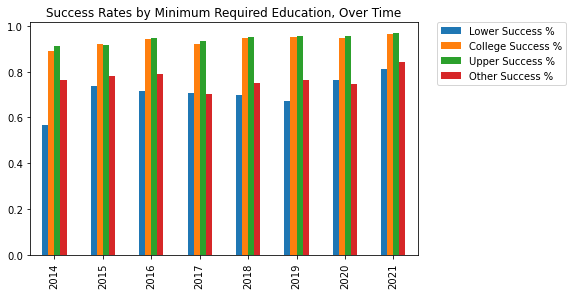

In [241]:
# MINIMUM EDUCATION REQUIRED ANALYSIS
# PLOTTING SUCCESS RATES OVER TIME BY MINIMUM EDUCATION REQUIRED

lower = df[df["REQ_EDU_GROUP"]=="LOWER"]
college = df[df["REQ_EDU_GROUP"]=="COLLEGE"]
upper = df[df["REQ_EDU_GROUP"]=="UPPER"]
other = df[df["REQ_EDU_GROUP"]=="OTHER"]



lowerdf = pd.DataFrame()
collegedf = pd.DataFrame()
upperdf = pd.DataFrame()
otherdf = pd.DataFrame()
linregdf = pd.DataFrame()

for x in range(len(yr)):
    lowe = pd.DataFrame([len(lower[(lower["YEAR"]==yr[x])&(lower["CASE_STATUS"]==1)])/len(lower[lower["YEAR"]==yr[x]])])
    coll = pd.DataFrame([len(college[(college["YEAR"]==yr[x])&(college["CASE_STATUS"]==1)])/len(college[college["YEAR"]==yr[x]])])
    upp = pd.DataFrame([len(upper[(upper["YEAR"]==yr[x])&(upper["CASE_STATUS"]==1)])/len(upper[upper["YEAR"]==yr[x]])])
    ott = pd.DataFrame([len(other[(other["YEAR"]==yr[x])&(other["CASE_STATUS"]==1)])/len(other[other["YEAR"]==yr[x]])])
    lowerdf = pd.concat([lowerdf,lowe])
    collegedf = pd.concat([collegedf,coll])
    upperdf = pd.concat([upperdf,upp])
    otherdf = pd.concat([otherdf, ott])
    linregdf = pd.concat([lowerdf,collegedf,upperdf,otherdf], axis = 1)
    

linregdf.index = yr
linregdf.columns = ["Lower Success %", "College Success %", "Upper Success %","Other Success %"]
plt.figure(figsize = (12,10), dpi = 100)
linregdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Minimum Required Education, Over Time")

Text(0.5, 1.0, 'Application Rates by Minimum Required Education, Over Time')

<Figure size 1200x1000 with 0 Axes>

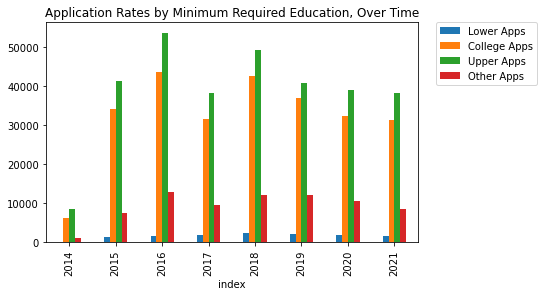

In [242]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
lowerapps = []
collegeapps = []
upperapps = []
otherapps = []

for x in range(len(yr)):
    l = (lower["YEAR"]==yr[x]).sum()
    c = (college["YEAR"]==yr[x]).sum()
    u = (upper["YEAR"]==yr[x]).sum()
    o = (other["YEAR"]==yr[x]).sum()
    lowerapps.append(l)
    collegeapps.append(c)
    upperapps.append(u)
    otherapps.append(o)
linregdf = linregdf.reset_index()
linregdf["Lower Apps"] = pd.DataFrame(lowerapps)
linregdf["College Apps"] = pd.DataFrame(collegeapps)
linregdf["Upper Apps"] = pd.DataFrame(upperapps)
linregdf["Other Apps"] = pd.DataFrame(otherapps)
linregdf = linregdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY EDUCATION LEVEL
plt.figure(figsize = (12,10), dpi = 100)
linregdf.reset_index().plot(x = "index", y = ["Lower Apps","College Apps","Upper Apps","Other Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Minimum Required Education, Over Time")

In [243]:
# P VALUE PER YEAR
lower_college = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Lower Success %"]
    sample2_phat = linregdf.loc[yr[x]]["College Success %"]
    sample1_size = linregdf.loc[yr[x]]["Lower Apps"]
    sample2_size = linregdf.loc[yr[x]]["College Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    lower_college.append(pval)

pvaldf = pd.DataFrame(lower_college)

lower_upper = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Lower Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Upper Success %"]
    sample1_size = linregdf.loc[yr[x]]["Lower Apps"]
    sample2_size = linregdf.loc[yr[x]]["Upper Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    lower_upper.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(lower_upper)], axis = 1)

lower_other = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Lower Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Other Success %"]
    sample1_size = linregdf.loc[yr[x]]["Lower Apps"]
    sample2_size = linregdf.loc[yr[x]]["Other Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    lower_other.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(lower_other)], axis = 1)

college_upper = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["College Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Upper Success %"]
    sample1_size = linregdf.loc[yr[x]]["College Apps"]
    sample2_size = linregdf.loc[yr[x]]["Upper Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    college_upper.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(college_upper)], axis = 1)

college_other = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["College Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Other Success %"]
    sample1_size = linregdf.loc[yr[x]]["College Apps"]
    sample2_size = linregdf.loc[yr[x]]["Other Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    college_other.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(college_other)], axis = 1)

upper_other = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Upper Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Other Success %"]
    sample1_size = linregdf.loc[yr[x]]["Upper Apps"]
    sample2_size = linregdf.loc[yr[x]]["Other Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    upper_other.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(upper_other)], axis = 1)

pvaldf.columns = ["Lower_College","Lower_Upper","Lower_Other","College_Upper","College_Other","Upper_Other"]
pvaldf.index = yr
linregdf[["Lower_College","Lower_Upper","Lower_Other","College_Upper","College_Other","Upper_Other"]] = pvaldf[["Lower_College","Lower_Upper","Lower_Other","College_Upper","College_Other","Upper_Other"]]

In [244]:
# LINEAR REGRESSION BETWEEN Minimum education required and success
print("Lower success rate over time:",st.linregress(y = linregdf["Lower Success %"], x = yr))
print("\nLower applications over time:",st.linregress(y = linregdf["Lower Apps"], x = yr))

print("\n\nCollege success rate over time:",st.linregress(y = linregdf["College Success %"], x = yr))
print("\nCollege applications over time:",st.linregress(y = linregdf["College Apps"], x = yr))

print("\n\nUpper success rate over time:",st.linregress(y = linregdf["Upper Success %"], x = yr))
print("\nUpper applications over time:",st.linregress(y = linregdf["Upper Apps"], x = yr))

print("\n\nOther success rate over time:",st.linregress(y = linregdf["Other Success %"], x = yr))
print("\nOther applications over time:",st.linregress(y = linregdf["Other Apps"], x = yr))

Lower success rate over time: LinregressResult(slope=0.019999489513015122, intercept=-39.64089832079937, rvalue=0.6889918348686509, pvalue=0.05875528834757528, stderr=0.008588728623002086, intercept_stderr=17.32777117182882)

Lower applications over time: LinregressResult(slope=186.66666666666666, intercept=-374994.75, rvalue=0.6614061100068067, pvalue=0.07407045300130942, stderr=86.4172425781731, intercept_stderr=174346.89934021945)


College success rate over time: LinregressResult(slope=0.008500887510197412, intercept=-16.216798003004985, rvalue=0.8674617891077945, pvalue=0.005257294410668302, stderr=0.001990374067242935, intercept_stderr=4.015582270367822)

College applications over time: LinregressResult(slope=1872.5595238095239, intercept=-3745531.2142857146, rvalue=0.3960573538315217, pvalue=0.3313956668820361, stderr=1772.357812961994, intercept_stderr=3575734.193691843)


Upper success rate over time: LinregressResult(slope=0.007449793131768392, intercept=-14.088023587588236, 

In [245]:
# GETTING THE TOTAL PVAL
linregdf.loc["ALL YRS"] = linregdf.sum()
lowersuc = []
collegesuc = []
uppersuc = []
othersuc = []

for x in range(len(yr)):
    l = linregdf.loc[yr[x]].iloc[0]*linregdf.loc[yr[x]].iloc[4]
    c = linregdf.loc[yr[x]].iloc[1]*linregdf.loc[yr[x]].iloc[5]
    u = linregdf.loc[yr[x]].iloc[2]*linregdf.loc[yr[x]].iloc[6]
    o = linregdf.loc[yr[x]].iloc[3]*linregdf.loc[yr[x]].iloc[7]
    lowersuc.append(l)
    collegesuc.append(c)
    uppersuc.append(u)
    othersuc.append(o)
    
linregdf.loc["ALL YRS"].iloc[0] = sum(lowersuc)/linregdf.loc["ALL YRS"].iloc[4]
linregdf.loc["ALL YRS"].iloc[1] = sum(collegesuc)/linregdf.loc["ALL YRS"].iloc[5]
linregdf.loc["ALL YRS"].iloc[2] = sum(uppersuc)/linregdf.loc["ALL YRS"].iloc[6]
linregdf.loc["ALL YRS"].iloc[3] = sum(othersuc)/linregdf.loc["ALL YRS"].iloc[7]

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[8] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[6]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[9] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[3]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[7]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[10] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[5]
    sample2_size = linregdf.loc["ALL YRS"].iloc[6]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[11] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[3]
    sample1_size = linregdf.loc["ALL YRS"].iloc[5]
    sample2_size = linregdf.loc["ALL YRS"].iloc[7]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[12] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[3]
    sample1_size = linregdf.loc["ALL YRS"].iloc[6]
    sample2_size = linregdf.loc["ALL YRS"].iloc[7]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[13] = pval

linregdf = linregdf.head(9).style.format("{:,.2f}")
linregdf

,Lower Success %,College Success %,Upper Success %,Other Success %,Lower Apps,College Apps,Upper Apps,Other Apps,Lower_College,Lower_Upper,Lower_Other,College_Upper,College_Other,Upper_Other
index,,,,,,,,,,,,,,
2014,0.57,0.89,0.91,0.76,102.00,"6,275.00","8,631.00",991.00,0.00,0.00,0.00,0.00,0.00,0.00
2015,0.74,0.92,0.92,0.78,"1,252.00","34,123.00","41,366.00","7,574.00",0.00,0.00,0.00,0.28,0.00,0.00
2016,0.71,0.94,0.95,0.79,"1,654.00","43,644.00","53,607.00","12,873.00",0.00,0.00,0.00,0.00,0.00,0.00
2017,0.71,0.92,0.93,0.70,"1,867.00","31,582.00","38,243.00","9,442.00",0.00,0.00,0.72,0.00,0.00,0.00
2018,0.70,0.95,0.95,0.75,"2,381.00","42,611.00","49,121.00","12,031.00",0.00,0.00,0.00,0.00,0.00,0.00
2019,0.67,0.95,0.96,0.76,"2,041.00","36,953.00","40,820.00","12,001.00",0.00,0.00,0.00,0.00,0.00,0.00
2020,0.76,0.95,0.95,0.75,"1,918.00","32,416.00","38,875.00","10,669.00",0.00,0.00,0.15,0.00,0.00,0.00
2021,0.81,0.96,0.97,0.84,"1,627.00","31,257.00","38,297.00","8,516.00",0.00,0.00,0.00,0.06,0.00,0.00
ALL YRS,0.72,0.94,0.95,0.77,"12,842.00","258,861.00","308,960.00","74,097.00",0.00,0.00,0.00,0.00,0.00,0.00


In [246]:
# DIVING DEEPER INTO THE MINIMUM REQUIRED EDUCATION LEVEL
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = "LOWER"
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY PW LEVEL
topstate = df[df["REQ_EDU_GROUP"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["REQ_EDU_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["REQ_EDU_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["REQ_EDU_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["REQ_EDU_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["REQ_EDU_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["REQ_EDU_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["REQ_EDU_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["REQ_EDU_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
CA    LEVEL I                 1831     24606.0                 15.0   
      LEVEL II                 497     37087.0                 11.0   
      LEVEL III                439     48000.0                 15.0   
      LEVEL IV                 410     55473.5                 18.0   
FL    LEVEL I                  516     31907.2                 17.0   
      LEVEL II                 144     47705.0                 16.0   
      LEVEL III                480     38305.0                 20.0   
      LEVEL IV                 314     49650.0                 21.0   
NJ    LEVEL I                  389     30000.0                 15.0   
      LEVEL II                 419     31949.0                 14.0   
      LEVEL III                170     48048.0                 14.5   
      LEVEL IV                 163     65000.0                 17.0   
NY    LEVEL I                  416     36774.5                 12.0   
      LEVEL II                 258     37793.5                 10.0   
      LEVEL III                217     45760.0                 15.0   
      LEVEL IV                 237     60000.0                 18.0   
TX    LEVEL I                  275     33675.0                 14.0   
      LEVEL II                 242     36000.0                 15.0   
      LEVEL III                189     58781.0                 15.0   
      LEVEL IV                 241     64896.0                 17.5   
IL    LEVEL I                  195     24544.0                 13.0   
      LEVEL II                 150     41932.5                 16.0   
      LEVEL III                112     41756.0                 16.5   
      LEVEL IV                 161     56000.0                 19.0   
VA    LEVEL I                  184     28475.0                 14.0   
      LEVEL II                 102     38210.0                 11.0   
      LEVEL III                101     50000.0                 14.0   
      LEVEL IV                 102     49740.0                 13.5   
GA    LEVEL I                  171     26749.0                 15.0   
      LEVEL II                 104     49629.0                 15.0   
      LEVEL III                100     47403.5                 17.0   
      LEVEL IV                  82     65500.0                 19.0   
AL    LEVEL I                   62     46738.0                 16.0   
      LEVEL II                  40     54250.0                 14.0   
      LEVEL III                118     60000.0                 21.0   
      LEVEL IV                  76     60000.0                 22.0   
MD    LEVEL I                  109     25189.0                 14.0   
      LEVEL II                  66     33269.6                 16.0   
      LEVEL III                 51     45157.0                 21.0   
      LEVEL IV                  64     51551.0                 20.0   
MA    LEVEL I                  101     27934.0                 12.0   
      LEVEL II                  43     72987.2                 12.0   
      LEVEL III                 21     56368.0                 17.0   
      LEVEL IV                  55     72800.0                 15.5   
MI    LEVEL I                  110     23379.2                 10.0   
      LEVEL II                  46     71661.5                 11.5   
      LEVEL III                 13     60000.0                 19.0   
      LEVEL IV                  32     87519.5                 17.5   
PA    LEVEL I                   36     50908.0                 15.0   
      LEVEL II                  33     74714.0                 15.0   
      LEVEL III                 27     56909.0                 17.0   
      LEVEL IV                  63     67600.0                 18.0   
GU    LEVEL I                   19     31408.0                 28.0   
      LEVEL II                   3     47486.0                 22.0   
      LEVEL III                 75     2

Text(0.5, 1.0, 'Success Rates by PW Skill Level, Over Time')

<Figure size 1200x1000 with 0 Axes>

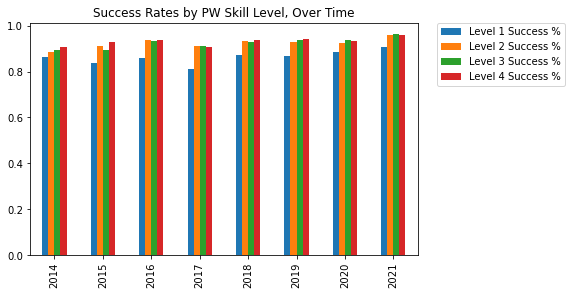

In [247]:
# PW LEVEL DISTRIBUTION ANALYSIS
# PLOTTING SUCCESS RATES OVER TIME BY PW LEVEL SKILL

lower = df[df["PW_SKILL_LEVEL"]=="LEVEL I"]
college = df[df["PW_SKILL_LEVEL"]=="LEVEL II"]
upper = df[df["PW_SKILL_LEVEL"]=="LEVEL III"]
other = df[df["PW_SKILL_LEVEL"]=="LEVEL IV"]



lowerdf = pd.DataFrame()
collegedf = pd.DataFrame()
upperdf = pd.DataFrame()
otherdf = pd.DataFrame()
linregdf = pd.DataFrame()

for x in range(len(yr)):
    lowe = pd.DataFrame([len(lower[(lower["YEAR"]==yr[x])&(lower["CASE_STATUS"]==1)])/len(lower[lower["YEAR"]==yr[x]])])
    coll = pd.DataFrame([len(college[(college["YEAR"]==yr[x])&(college["CASE_STATUS"]==1)])/len(college[college["YEAR"]==yr[x]])])
    upp = pd.DataFrame([len(upper[(upper["YEAR"]==yr[x])&(upper["CASE_STATUS"]==1)])/len(upper[upper["YEAR"]==yr[x]])])
    ott = pd.DataFrame([len(other[(other["YEAR"]==yr[x])&(other["CASE_STATUS"]==1)])/len(other[other["YEAR"]==yr[x]])])
    lowerdf = pd.concat([lowerdf,lowe])
    collegedf = pd.concat([collegedf,coll])
    upperdf = pd.concat([upperdf,upp])
    otherdf = pd.concat([otherdf, ott])
    linregdf = pd.concat([lowerdf,collegedf,upperdf,otherdf], axis = 1)
    

linregdf.index = yr
linregdf.columns = ["Level 1 Success %", "Level 2 Success %", "Level 3 Success %","Level 4 Success %"]
plt.figure(figsize = (12,10), dpi = 100)
linregdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by PW Skill Level, Over Time")

Text(0.5, 1.0, 'Application Rates by PW Skill Level, Over Time')

<Figure size 1200x1000 with 0 Axes>

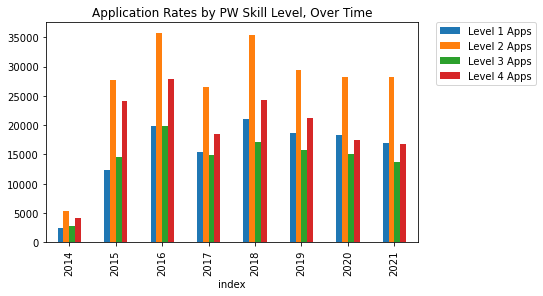

In [248]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
lowerapps = []
collegeapps = []
upperapps = []
otherapps = []

for x in range(len(yr)):
    l = (lower["YEAR"]==yr[x]).sum()
    c = (college["YEAR"]==yr[x]).sum()
    u = (upper["YEAR"]==yr[x]).sum()
    o = (other["YEAR"]==yr[x]).sum()
    lowerapps.append(l)
    collegeapps.append(c)
    upperapps.append(u)
    otherapps.append(o)
linregdf = linregdf.reset_index()
linregdf["Level 1 Apps"] = pd.DataFrame(lowerapps)
linregdf["Level 2 Apps"] = pd.DataFrame(collegeapps)
linregdf["Level 3 Apps"] = pd.DataFrame(upperapps)
linregdf["Level 4 Apps"] = pd.DataFrame(otherapps)
linregdf = linregdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY SKILL LEVEL
plt.figure(figsize = (12,10), dpi = 100)
linregdf.reset_index().plot(x = "index", y = ["Level 1 Apps","Level 2 Apps","Level 3 Apps","Level 4 Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by PW Skill Level, Over Time")

In [249]:
# P VALUE PER YEAR
lower_college = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Level 1 Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Level 2 Success %"]
    sample1_size = linregdf.loc[yr[x]]["Level 1 Apps"]
    sample2_size = linregdf.loc[yr[x]]["Level 2 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    lower_college.append(pval)

pvaldf = pd.DataFrame(lower_college)

lower_upper = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Level 1 Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Level 3 Success %"]
    sample1_size = linregdf.loc[yr[x]]["Level 1 Apps"]
    sample2_size = linregdf.loc[yr[x]]["Level 3 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    lower_upper.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(lower_upper)], axis = 1)

lower_other = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Level 1 Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Level 4 Success %"]
    sample1_size = linregdf.loc[yr[x]]["Level 1 Apps"]
    sample2_size = linregdf.loc[yr[x]]["Level 4 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    lower_other.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(lower_other)], axis = 1)

college_upper = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Level 2 Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Level 3 Success %"]
    sample1_size = linregdf.loc[yr[x]]["Level 2 Apps"]
    sample2_size = linregdf.loc[yr[x]]["Level 3 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    college_upper.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(college_upper)], axis = 1)

college_other = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Level 2 Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Level 4 Success %"]
    sample1_size = linregdf.loc[yr[x]]["Level 2 Apps"]
    sample2_size = linregdf.loc[yr[x]]["Level 4 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    college_other.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(college_other)], axis = 1)

upper_other = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Level 3 Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Level 4 Success %"]
    sample1_size = linregdf.loc[yr[x]]["Level 3 Apps"]
    sample2_size = linregdf.loc[yr[x]]["Level 4 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    upper_other.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(upper_other)], axis = 1)

pvaldf.columns = ["L1_L2","L1_L3","L1_L4","L2_L3","L2_L4","L3_L4"]
pvaldf.index = yr
linregdf[["L1_L2","L1_L3","L1_L4","L2_L3","L2_L4","L3_L4"]] = pvaldf[["L1_L2","L1_L3","L1_L4","L2_L3","L2_L4","L3_L4"]]

In [250]:
# LINEAR REGRESSION BETWEEN PW SKILL LEVEL and success
print("Level 1 success rate over time:",st.linregress(y = linregdf["Level 1 Success %"], x = yr))
print("\nLevel 1 applications over time:",st.linregress(y = linregdf["Level 1 Apps"], x = yr))

print("\n\nLevel 2 success rate over time:",st.linregress(y = linregdf["Level 2 Success %"], x = yr))
print("\nLevel 2 applications over time:",st.linregress(y = linregdf["Level 2 Apps"], x = yr))

print("\n\nLevel 3 success rate over time:",st.linregress(y = linregdf["Level 3 Success %"], x = yr))
print("\nLevel 3 applications over time:",st.linregress(y = linregdf["Level 3 Apps"], x = yr))

print("\n\nLevel 4 success rate over time:",st.linregress(y = linregdf["Level 4 Success %"], x = yr))
print("\nLevel 4 applications over time:",st.linregress(y = linregdf["Level 4 Apps"], x = yr))

Level 1 success rate over time: LinregressResult(slope=0.007382000452535047, intercept=-14.030415440771298, rvalue=0.627234798030829, pvalue=0.09598912773661288, stderr=0.003742062969351918, intercept_stderr=7.54961690952109)

Level 1 applications over time: LinregressResult(slope=1590.0, intercept=-3192226.25, rvalue=0.6496101753993534, pvalue=0.08126433225810413, stderr=759.6876851497949, intercept_stderr=1532670.8932306184)


Level 2 success rate over time: LinregressResult(slope=0.006889491814806313, intercept=-12.975479525341374, rvalue=0.7893960228846025, pvalue=0.01981955861152047, stderr=0.002187273782231075, intercept_stderr=4.412827701545532)

Level 2 applications over time: LinregressResult(slope=1821.4761904761904, intercept=-3647731.214285714, rvalue=0.47044386985627323, pvalue=0.23942340609040205, stderr=1394.8268062200275, intercept_stderr=2814064.8963787374)


Level 3 success rate over time: LinregressResult(slope=0.008915498463876044, intercept=-17.062852431344304, rva

In [251]:
# GETTING THE TOTAL PVAL
linregdf.loc["ALL YRS"] = linregdf.sum()
lowersuc = []
collegesuc = []
uppersuc = []
othersuc = []

for x in range(len(yr)):
    l = linregdf.loc[yr[x]].iloc[0]*linregdf.loc[yr[x]].iloc[4]
    c = linregdf.loc[yr[x]].iloc[1]*linregdf.loc[yr[x]].iloc[5]
    u = linregdf.loc[yr[x]].iloc[2]*linregdf.loc[yr[x]].iloc[6]
    o = linregdf.loc[yr[x]].iloc[3]*linregdf.loc[yr[x]].iloc[7]
    lowersuc.append(l)
    collegesuc.append(c)
    uppersuc.append(u)
    othersuc.append(o)
    
linregdf.loc["ALL YRS"].iloc[0] = sum(lowersuc)/linregdf.loc["ALL YRS"].iloc[4]
linregdf.loc["ALL YRS"].iloc[1] = sum(collegesuc)/linregdf.loc["ALL YRS"].iloc[5]
linregdf.loc["ALL YRS"].iloc[2] = sum(uppersuc)/linregdf.loc["ALL YRS"].iloc[6]
linregdf.loc["ALL YRS"].iloc[3] = sum(othersuc)/linregdf.loc["ALL YRS"].iloc[7]

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[8] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[6]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[9] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[3]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[7]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[10] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[5]
    sample2_size = linregdf.loc["ALL YRS"].iloc[6]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[11] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[3]
    sample1_size = linregdf.loc["ALL YRS"].iloc[5]
    sample2_size = linregdf.loc["ALL YRS"].iloc[7]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[12] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[3]
    sample1_size = linregdf.loc["ALL YRS"].iloc[6]
    sample2_size = linregdf.loc["ALL YRS"].iloc[7]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[13] = pval

linregdf = linregdf.head(9).style.format("{:,.2f}")
linregdf

,Level 1 Success %,Level 2 Success %,Level 3 Success %,Level 4 Success %,Level 1 Apps,Level 2 Apps,Level 3 Apps,Level 4 Apps,L1_L2,L1_L3,L1_L4,L2_L3,L2_L4,L3_L4
index,,,,,,,,,,,,,,
2014,0.87,0.89,0.89,0.91,"2,367.00","5,283.00","2,764.00","4,170.00",0.01,0.00,0.00,0.41,0.00,0.04
2015,0.84,0.91,0.89,0.93,"12,320.00","27,775.00","14,572.00","24,198.00",0.00,0.00,0.00,0.00,0.00,0.00
2016,0.86,0.94,0.93,0.94,"19,866.00","35,777.00","19,949.00","27,931.00",0.00,0.00,0.00,0.05,0.12,0.00
2017,0.81,0.91,0.91,0.91,"15,387.00","26,537.00","14,937.00","18,431.00",0.00,0.00,0.00,0.88,0.09,0.19
2018,0.87,0.93,0.93,0.94,"21,018.00","35,418.00","17,207.00","24,355.00",0.00,0.00,0.00,0.05,0.00,0.00
2019,0.87,0.93,0.94,0.94,"18,645.00","29,505.00","15,745.00","21,312.00",0.00,0.00,0.00,0.00,0.00,0.11
2020,0.89,0.92,0.94,0.93,"18,274.00","28,286.00","15,147.00","17,442.00",0.00,0.00,0.00,0.00,0.00,0.31
2021,0.91,0.96,0.96,0.96,"16,913.00","28,195.00","13,633.00","16,781.00",0.00,0.00,0.00,0.12,0.11,0.01
ALL YRS,0.86,0.93,0.93,0.93,"124,790.00","216,776.00","113,954.00","154,620.00",0.00,0.00,0.00,0.22,0.00,0.00


In [252]:
# DEEPER DIVE INTO ALL PW SKILL LEVELS!
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY EDU LEVEL
code = "LEVEL IV"
# CHANGE THIS FOR ANY CODE
topstate = df[df["PW_SKILL_LEVEL"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["PW_SKILL_LEVEL"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SKILL_LEVEL"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["PW_SKILL_LEVEL"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SKILL_LEVEL"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["PW_SKILL_LEVEL"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SKILL_LEVEL"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["PW_SKILL_LEVEL"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PW_SKILL_LEVEL"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
CA    HIGH SCHOOL                266     54007.5                 22.0   
      ASSOCIATE'S                168     81163.0                 16.0   
      BACHELOR'S               16319    142064.0                 13.0   
      MASTER'S                 10771    145870.0                  9.0   
      DOCTORATE                  671    151653.0                  7.0   
...                              ...         ...                  ...   
MN    ASSOCIATE'S                  9     54100.0                 12.0   
      BACHELOR'S                1297    108638.0                 12.0   
      MASTER'S                   578    108638.0                  9.5   
      DOCTORATE                   20    96231.02                  5.5   
      OTHER                       33    113734.0                 13.0   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
CA    HIGH SCHOOL                 208.0  
      ASSOCIATE'S                 187.0  
      BACHELOR'S                  140.0  
      MASTER'S                    141.0  
      DOCTORATE                   143.0  
...                                 ...  
MN    ASSOCIATE'S                 215.0  
      BACHELOR'S             123.527072  
      MASTER'S               121.753675  
      DOCTORATE                   137.5  
      OTHER                       150.0  

[90 rows x 4 columns]

In [253]:
# PROFESSIONAL OCCUPATION?
# DIVING DEEPER INTO IF PROFESSIONAL OCCUPATION!
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = 1
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY PW LEVEL
topstate = df[df["PROFESSIONAL_OCCUPATION"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
CA    LEVEL I                20703     98842.0                  5.0   
      LEVEL II               56911    118186.0                  5.0   
      LEVEL III              22860    132184.0                  7.0   
      LEVEL IV               28883    144200.0                 11.0   
TX    LEVEL I                 6031     69360.0                  7.0   
      LEVEL II               25367     83491.0                  9.0   
      LEVEL III              12289     96470.0                 10.0   
      LEVEL IV               23752     93475.0                 11.0   
NY    LEVEL I                 7127     85000.0                  6.0   
      LEVEL II               13838     99736.0                  6.0   
      LEVEL III               6297    117624.0                  7.0   
      LEVEL IV               17199    134930.0                 10.0   
NJ    LEVEL I                 3083     71552.0                  8.0   
      LEVEL II               16832     87506.0                  9.0   
      LEVEL III              13207    104936.0                 10.0   
      LEVEL IV               10784    123490.0                 12.0   
WA    LEVEL I                 8638   111274.75                  4.0   
      LEVEL II               23959    105000.0                  4.0   
      LEVEL III               5537    130000.0                  9.0   
      LEVEL IV                4818    140000.0                 12.0   
IL    LEVEL I                 3066     74740.0                  7.0   
      LEVEL II                6620     83366.0                  7.0   
      LEVEL III               5709     96000.0                 10.0   
      LEVEL IV                6757    112757.0                 11.0   
MA    LEVEL I                 2563     85000.0                  6.0   
      LEVEL II                7539     95000.0                  6.0   
      LEVEL III               4427    110250.0                  9.0   
      LEVEL IV                5477    124500.0                 11.0   
MI    LEVEL I                 2583     82000.0                  8.0   
      LEVEL II                6624     80083.0                  7.0   
      LEVEL III               5566     90522.0                  8.0   
      LEVEL IV                5218    104520.0                 12.0   
FL    LEVEL I                 3340     64000.0                  9.0   
      LEVEL II                5361     74880.0                  8.0   
      LEVEL III               2531     89669.0                  9.0   
      LEVEL IV                4325    107578.0                 12.0   
VA    LEVEL I                 2174     77000.0                  6.0   
      LEVEL II                5593     92019.0                  7.0   
      LEVEL III               3351    109000.0                  7.0   
      LEVEL IV                3826    127379.0                 11.0   
GA    LEVEL I                 1744     67246.0                  7.0   
      LEVEL II                4048     82098.0                  7.0   
      LEVEL III               2483     96000.0                  7.0   
      LEVEL IV                5258    113693.0                 12.0   
PA    LEVEL I                 2052     75000.0                  7.0   
      LEVEL II                4127     83179.0                  8.0   
      LEVEL III               2245    99346.73                  9.0   
      LEVEL IV                4736  105317.745                 11.0   
NC    LEVEL I                 1043     77600.0                  8.0   
      LEVEL II                3131     89918.0                  7.0   
      LEVEL III               2106     97198.0                 10.0   
      LEVEL IV                3058    115149.0                 12.0   
OH    LEVEL I                 1187     80000.0                  7.0   
      LEVEL II                2385     81952.0                  7.0   
      LEVEL III               1404     9

In [254]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PROFESSIONAL_OCCUPATION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS    MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                            
CA    HIGH SCHOOL                208        82472.0                 22.0   
      ASSOCIATE'S                451        82264.0                 15.0   
      BACHELOR'S               48551       125050.0                 11.0   
      MASTER'S                 89143       120578.0                  5.0   
      DOCTORATE                 6883       132184.0                  3.0   
...                              ...            ...                  ...   
AZ    ASSOCIATE'S                 11        73694.0                 19.0   
      BACHELOR'S                2831        99902.0                 12.0   
      MASTER'S                  3382        83000.0                  5.0   
      DOCTORATE                  305        93059.0                  2.0   
      OTHER                      299  197921.278424                 10.0   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
CA    HIGH SCHOOL                 164.5  
      ASSOCIATE'S                 196.0  
      BACHELOR'S                  135.0  
      MASTER'S                    138.0  
      DOCTORATE                   140.0  
...                                 ...  
AZ    ASSOCIATE'S                 141.0  
      BACHELOR'S                  137.0  
      MASTER'S               142.185052  
      DOCTORATE                   139.0  
      OTHER                       135.0  

[90 rows x 4 columns]

Text(0.5, 1.0, 'Success Rates by Professional and not Professional Jobs, Over Time')

<Figure size 1200x1000 with 0 Axes>

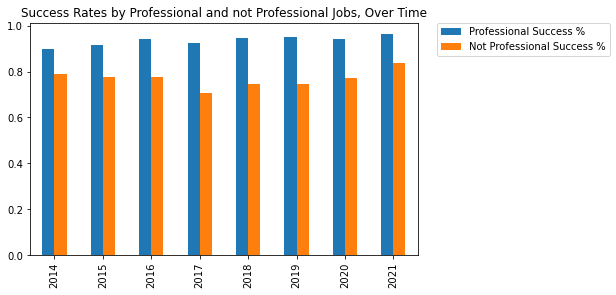

In [255]:
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY Professional Occupation or not (IN TERMS OF ANNUAL APPLICATIONS)

top15 = df[df["PROFESSIONAL_OCCUPATION"]==1]
not15 = df[df["PROFESSIONAL_OCCUPATION"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["Professional Success %", "Not Professional Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Professional and not Professional Jobs, Over Time")

Text(0.5, 1.0, 'Application Rates by Professional and not Professional Jobs, Over Time')

<Figure size 1200x1000 with 0 Axes>

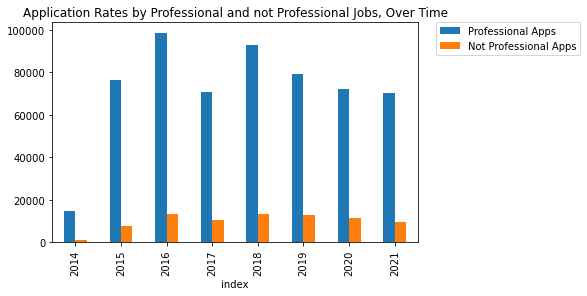

In [256]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["Professional Apps"] = pd.DataFrame(top15apps)
analysisdf["Not Professional Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY Professional or not
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["Professional Apps","Not Professional Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Professional and not Professional Jobs, Over Time")

In [257]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["Professional Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not Professional Success %"]
    sample1_size = analysisdf.loc[yr[x]]["Professional Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not Professional Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Professional Vs. Not Professional"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["Professional Vs. Not Professional"]

In [258]:
# LINEAR REGRESSION BETWEEN Professional Occupation AND SUCCESS RATE OVER TIME
print("Professional success rate over time:",st.linregress(y = analysisdf["Professional Success %"], x = yr))
print("\nProfessional applications over time:",st.linregress(y = analysisdf["Professional Apps"], x = yr))

print("\n\nNot professional success rate over time:",st.linregress(y = analysisdf["Not Professional Success %"], x = yr))
print("\nNot Professional applications over time:",st.linregress(y = analysisdf["Not Professional Apps"], x = yr))

Professional success rate over time: LinregressResult(slope=0.007693499368298568, intercept=-14.586256167135154, rvalue=0.8825290763808807, pvalue=0.003703919515641838, stderr=0.0016736140477340037, intercept_stderr=3.3765185188673965)

Professional applications over time: LinregressResult(slope=3925.0476190476193, intercept=-7846874.571428572, rvalue=0.37993035093981326, pvalue=0.3532142871565459, stderr=3901.343018606339, intercept_stderr=7870964.616133516)


Not professional success rate over time: LinregressResult(slope=0.0031022081394178787, intercept=-5.49081117509845, rvalue=0.19966407612717255, pvalue=0.6354605576588339, stderr=0.006215289430233296, intercept_stderr=12.539354512300875)

Not Professional applications over time: LinregressResult(slope=941.8809523809524, intercept=-1890308.8214285716, rvalue=0.568150370773558, pvalue=0.14176333511792438, stderr=556.9513009287239, intercept_stderr=1123649.9742812933)


In [259]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,Professional Success %,Not Professional Success %,Professional Apps,Not Professional Apps,PVAL Success %
index,,,,,
2014,0.90,0.79,"14,880.00","1,119.00",0.00
2015,0.92,0.78,"76,603.00","7,712.00",0.00
2016,0.94,0.78,"98,654.00","13,124.00",0.00
2017,0.92,0.71,"70,660.00","10,474.00",0.00
2018,0.95,0.74,"92,822.00","13,322.00",0.00
2019,0.95,0.74,"79,066.00","12,749.00",0.00
2020,0.94,0.77,"72,314.00","11,564.00",0.00
2021,0.96,0.84,"70,273.00","9,424.00",0.00
ALL YRS,0.94,0.76,"575,272.00","79,488.00",0.00


In [260]:
# MOST COMMON NEWSPAPER (FIRST) NAMES
print(df['FIRST_NEWSPAPER_NAME'].nunique(),"unique newspapers.")
print("After cleaning,",df['FIRST_NEWSPAPER_NAME'].str.replace('[^\w\s]','', regex = True).str.replace(" ","").str.replace("THE","").nunique(),"newspapers.")

6607 unique newspapers.
After cleaning, 3949 newspapers.


In [261]:
# NEW COLUMN, CLEANED UP VERSION OF NEWSPAPER NAMES: TOP 10 OR NOT
df["CLEANED_FNEWS"] = df['FIRST_NEWSPAPER_NAME'].str.replace('[^\w\s]','', regex = True).str.replace(" ","").str.replace("THE","")

# Top 10 WORK Cities of all time 2014-2021
allsoc = pd.DataFrame(df["CLEANED_FNEWS"].value_counts()[:10]).reset_index()
allsoc.columns = ["APaper","COUNT APaper"]
sucsoc = pd.DataFrame(df[df["CASE_STATUS"]==1]["CLEANED_FNEWS"].value_counts()[:10]).reset_index()
sucsoc.columns = ["SPaper","COUNT SPaper"]
pd.concat([allsoc,sucsoc], axis = 1)
# Grabbing the top 5 for each year state worked in: total applications
top5aemp = pd.DataFrame()
def grab (year):
    return df[df["YEAR"]==year]["CLEANED_FNEWS"].value_counts()[:10]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top5aemp = pd.concat([top5aemp,j], axis = 1)
top5aemp.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS state NOT IN THE TOP 5?: TOP CONSISTENT states...
kingconsA = top5aemp.isnull().replace(False,0).replace(True,1)
kingconsA["Yrs not in Top 10"] = top5aemp.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingconsA["Yrs not in Top 10"].sort_values()[:10]

STARLEDGER               0
SANFRANCISCOCHRONICLE    0
SEATTLETIMES             0
NEWYORKTIMES             0
DALLASMORNINGNEWS        0
WASHINGTONPOST           0
DETROITFREEPRESS         0
SANJOSEMERCURYNEWS       3
MERCURYNEWS              3
EAGLE                    4
Name: Yrs not in Top 10, dtype: int64

In [262]:
# NEW COLUMN: 1 is in the top 10 of the YEAR, 0 is not: Applications
filler = pd.DataFrame()
for x in range(len(yr)):
    listy = top5aemp[yr[x]].dropna().index.tolist()
    filler = pd.concat([filler,pd.DataFrame((df[df["YEAR"]==yr[x]]["CLEANED_FNEWS"].isin(listy)).replace(True,1).replace(False,0))])

filler = filler.reset_index().sort_values(by = "index").set_index("index")
filler.columns = ["TOP10NEWS"]
df["TOP10NEWS"] = filler

Text(0.5, 1.0, 'Success Rates by Top 10 and not Top 10 Newspapers, Over Time')

<Figure size 1200x1000 with 0 Axes>

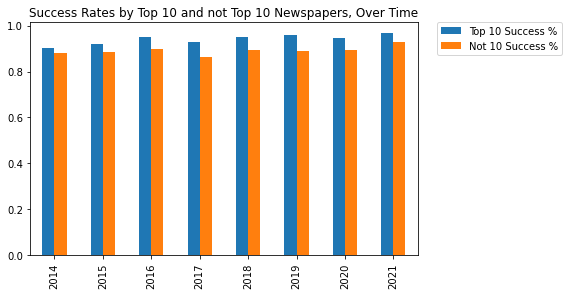

In [263]:
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY TOP 10 Newspaper (IN TERMS OF ANNUAL APPLICATIONS)

top15 = df[df["TOP10NEWS"]==1]
not15 = df[df["TOP10NEWS"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["Top 10 Success %", "Not 10 Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Top 10 and not Top 10 Newspapers, Over Time")

Text(0.5, 1.0, 'Application Rates by Top 10 or not Top 10 Newspapers, Over Time')

<Figure size 1200x1000 with 0 Axes>

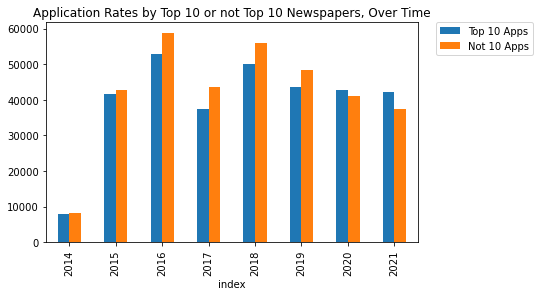

In [264]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["Top 10 Apps"] = pd.DataFrame(top15apps)
analysisdf["Not 10 Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["Top 10 Apps","Not 10 Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Top 10 or not Top 10 Newspapers, Over Time")

In [265]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["Top 10 Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not 10 Success %"]
    sample1_size = analysisdf.loc[yr[x]]["Top 10 Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not 10 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Top 10 Vs. Not 10"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["Top 10 Vs. Not 10"]

In [266]:
# LINEAR REGRESSION BETWEEN Professional Occupation AND SUCCESS RATE OVER TIME
print("Top 10 success rate over time:",st.linregress(y = analysisdf["Top 10 Success %"], x = yr))
print("\nTop 10 applications over time:",st.linregress(y = analysisdf["Top 10 Apps"], x = yr))

print("\n\nNot 10 success rate over time:",st.linregress(y = analysisdf["Not 10 Success %"], x = yr))
print("\nNot 10 applications over time:",st.linregress(y = analysisdf["Not 10 Apps"], x = yr))

Top 10 success rate over time: LinregressResult(slope=0.007340073098903109, intercept=-13.867980008496655, rvalue=0.8528301163173228, pvalue=0.007115178125039559, stderr=0.0018348032697211695, intercept_stderr=3.7017179839521894)

Top 10 applications over time: LinregressResult(slope=2737.9761904761904, intercept=-5484049.964285714, rvalue=0.4852064605502594, pvalue=0.22294051090710754, stderr=2014.3615633351492, intercept_stderr=4063977.074944351)


Not 10 success rate over time: LinregressResult(slope=0.004645510989499856, intercept=-8.480833493976231, rvalue=0.6114212186201088, pvalue=0.10725617559907225, stderr=0.002454490978897126, intercept_stderr=4.951938743499545)

Not 10 applications over time: LinregressResult(slope=2128.9523809523807, intercept=-4253133.428571428, rvalue=0.3357389118585532, pvalue=0.41619570774866044, stderr=2438.477984435056, intercept_stderr=4919632.506337575)


In [267]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,Top 10 Success %,Not 10 Success %,Top 10 Apps,Not 10 Apps,PVAL Success %
index,,,,,
2014,0.90,0.88,"7,862.00","8,137.00",0.00
2015,0.92,0.88,"41,632.00","42,683.00",0.00
2016,0.95,0.90,"52,984.00","58,794.00",0.00
2017,0.93,0.87,"37,497.00","43,637.00",0.00
2018,0.95,0.89,"50,137.00","56,007.00",0.00
2019,0.96,0.89,"43,509.00","48,306.00",0.00
2020,0.95,0.89,"42,718.00","41,160.00",0.00
2021,0.97,0.93,"42,197.00","37,500.00",0.00
ALL YRS,0.95,0.89,"318,536.00","336,224.00",0.00


In [268]:
# FIRST AD TO DAYS
# CREATING A NEW COLUMN: AD GROUP, SPLITS DAYS INTO THIRDS
df["FIRST_AD_TO_APP_DAYS"] = df["FIRST_AD_TO_APP_DAYS"].replace("#VALUE!",np.nan).astype(float)
high = df.groupby("YEAR")["FIRST_AD_TO_APP_DAYS"].quantile(2/3).tolist()
low = df.groupby("YEAR")["FIRST_AD_TO_APP_DAYS"].quantile(1/3).tolist()
df["AD_GROUP"] = np.nan
for x in range(len(yr)):
    df["AD_GROUP"] = np.where((df["YEAR"]==yr[x])&(df["FIRST_AD_TO_APP_DAYS"]<low[x]),"FAST",df["AD_GROUP"])
    df["AD_GROUP"] = np.where((df["YEAR"]==yr[x])&(df["FIRST_AD_TO_APP_DAYS"]>=low[x])&(df["FIRST_AD_TO_APP_DAYS"]<high[x]),"MEDIUM",df["AD_GROUP"])
    df["AD_GROUP"] = np.where((df["YEAR"]==yr[x])&(df["FIRST_AD_TO_APP_DAYS"]>=high[x]),"SLOW",df["AD_GROUP"])

In [269]:
# DIVING DEEPER INTO THE TOP CODES!
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = "FAST"
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY PW LEVEL WITHIN AD GROUP
topstate = df[df["AD_GROUP"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
CA    LEVEL I                10143     75254.0                  6.0   
      LEVEL II               19217    116085.0                  5.0   
      LEVEL III               8669    130000.0                  7.0   
      LEVEL IV               11176    142064.0                 11.0   
TX    LEVEL I                 3189     52000.0                  7.0   
      LEVEL II                6058     82992.0                  7.5   
      LEVEL III               3070     97052.5                  9.0   
      LEVEL IV                5027    110760.0                 12.0   
NY    LEVEL I                 3459     70000.0                  6.0   
      LEVEL II                5181     96595.0                  6.0   
      LEVEL III               2501    113672.0                  7.0   
      LEVEL IV                6137    135283.0                 11.0   
NJ    LEVEL I                 1677     63170.0                  7.0   
      LEVEL II                5407     88483.0                  9.0   
      LEVEL III               4112    104936.0                  9.0   
      LEVEL IV                3814    123490.0                 12.0   
WA    LEVEL I                 1645    109100.0                  4.0   
      LEVEL II                4335    108000.0                  5.0   
      LEVEL III               1217    126000.0                  9.0   
      LEVEL IV                1506    134647.0                 12.0   
MI    LEVEL I                 1478     85000.0                  9.0   
      LEVEL II                2953     82555.0                  7.0   
      LEVEL III               2448     90721.5                  8.0   
      LEVEL IV                2054    104666.0                 12.0   
MA    LEVEL I                 1222    75550.46                  6.0   
      LEVEL II                2700     94203.0                  6.0   
      LEVEL III               2493    110000.0                  9.0   
      LEVEL IV                2184    122450.0                 11.0   
IL    LEVEL I                 1432     66082.0                  6.0   
      LEVEL II                2548     83500.0                  7.0   
      LEVEL III               1902     92952.0                  9.0   
      LEVEL IV                2539    112500.0                 11.0   
GA    LEVEL I                 2277     21986.0                  9.0   
      LEVEL II                1673     79394.0                  7.0   
      LEVEL III               1016     95306.0                  8.0   
      LEVEL IV                2106    112961.5                 12.0   
FL    LEVEL I                 1856     49400.0                  9.0   
      LEVEL II                1783     75000.0                  8.0   
      LEVEL III               1351     85000.0                 11.0   
      LEVEL IV                1768    102398.0                 12.0   
VA    LEVEL I                 1474     49743.0                  7.0   
      LEVEL II                2237     91166.0                  7.0   
      LEVEL III               1308    108139.0                  7.0   
      LEVEL IV                1535    125800.0                 12.0   
NC    LEVEL I                 1816     19780.8                  9.0   
      LEVEL II                1182     89253.0                  7.0   
      LEVEL III                665    100131.0                  9.5   
      LEVEL IV                1043    115000.0                 12.0   
PA    LEVEL I                  722     74045.0                  7.0   
      LEVEL II                1306     80142.0                  8.0   
      LEVEL III                533     96741.0                  9.0   
      LEVEL IV                1431    103314.0                 11.0   
OH    LEVEL I                 1013     28850.0                  8.0   
      LEVEL II                 836     80000.0                  7.0   
      LEVEL III                583     8

In [270]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY EDU LEVEL WITHIN AD GROUP
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["AD_GROUP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
CA    HIGH SCHOOL               1103     25022.0                 19.0   
      ASSOCIATE'S                441     46966.0                 12.0   
      BACHELOR'S               17762   123607.05                 11.0   
      MASTER'S                 28705    120931.0                  6.0   
      DOCTORATE                 2159    131726.0                  4.0   
...                              ...         ...                  ...   
MD    ASSOCIATE'S                 30     36608.0                 11.0   
      BACHELOR'S                 784     95970.5                 11.0   
      MASTER'S                  1406     94245.0                  6.0   
      DOCTORATE                   52    100572.5                  5.0   
      OTHER                      125    180000.0                  8.0   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
CA    HIGH SCHOOL                 187.0  
      ASSOCIATE'S                 192.0  
      BACHELOR'S             136.356395  
      MASTER'S                    140.0  
      DOCTORATE                   141.0  
...                                 ...  
MD    ASSOCIATE'S                 153.0  
      BACHELOR'S                  145.0  
      MASTER'S                    146.0  
      DOCTORATE              148.066065  
      OTHER                  138.630289  

[90 rows x 4 columns]

Text(0.5, 1.0, 'Success Rates by Time To Apply Since First Ad, Over Time')

<Figure size 1200x1000 with 0 Axes>

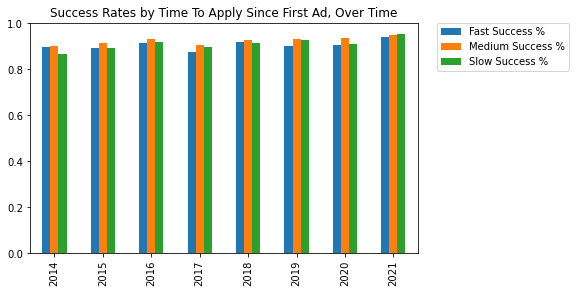

In [271]:
# CORRELATION ANALYSIS: AGGREGATE BY SIZE BRACKETS AND YEARLY
# PLOTTING SUCCESS RATES OVER TIME BY SIZE OF COMPANY

young = df[df["AD_GROUP"]=="FAST"]
mid = df[df["AD_GROUP"]=="MEDIUM"]
old = df[df["AD_GROUP"]=="SLOW"]


youndf = pd.DataFrame()
middf = pd.DataFrame()
olddf = pd.DataFrame()
linregdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(young[(young["YEAR"]==yr[x])&(young["CASE_STATUS"]==1)])/len(young[young["YEAR"]==yr[x]])])
    med = pd.DataFrame([len(mid[(mid["YEAR"]==yr[x])&(mid["CASE_STATUS"]==1)])/len(mid[mid["YEAR"]==yr[x]])])
    oldy = pd.DataFrame([len(old[(old["YEAR"]==yr[x])&(old["CASE_STATUS"]==1)])/len(old[old["YEAR"]==yr[x]])])
    youndf = pd.concat([youndf,j])
    middf = pd.concat([middf,med])
    olddf = pd.concat([olddf,oldy])
    linregdf = pd.concat([youndf,middf,olddf], axis = 1)
    

linregdf.index = yr
linregdf.columns = ["Fast Success %", "Medium Success %", "Slow Success %"]
plt.figure(figsize = (12,10), dpi = 100)
linregdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Time To Apply Since First Ad, Over Time")


Text(0.5, 1.0, 'Application Rates by Time To Apply Since First Ad, Over Time')

<Figure size 1200x1000 with 0 Axes>

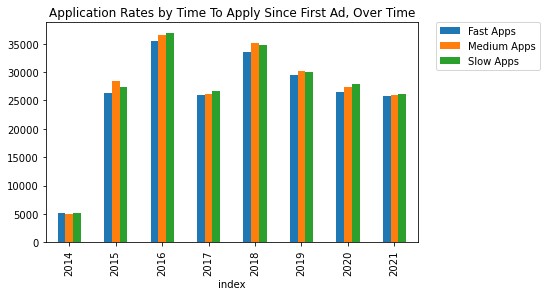

In [272]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
youngapps = []
midapps = []
oldapps = []

for x in range(len(yr)):
    y = (young["YEAR"]==yr[x]).sum()
    m = (mid["YEAR"]==yr[x]).sum()
    o = (old["YEAR"]==yr[x]).sum()
    youngapps.append(y)
    midapps.append(m)
    oldapps.append(o)
linregdf = linregdf.reset_index()
linregdf["Fast Apps"] = pd.DataFrame(youngapps)
linregdf["Medium Apps"] = pd.DataFrame(midapps)
linregdf["Slow Apps"] = pd.DataFrame(oldapps)
linregdf = linregdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY SIZE OF COMPANY
plt.figure(figsize = (12,10), dpi = 100)
linregdf.reset_index().plot(x = "index", y = ["Fast Apps","Medium Apps","Slow Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Time To Apply Since First Ad, Over Time")

In [273]:
# P VALUE PER YEAR
young_med = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Fast Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Medium Success %"]
    sample1_size = linregdf.loc[yr[x]]["Fast Apps"]
    sample2_size = linregdf.loc[yr[x]]["Medium Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    young_med.append(pval)

pvaldf = pd.DataFrame(young_med)

young_old = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Fast Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Slow Success %"]
    sample1_size = linregdf.loc[yr[x]]["Fast Apps"]
    sample2_size = linregdf.loc[yr[x]]["Slow Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    young_old.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(young_old)], axis = 1)

med_old = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Medium Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Slow Success %"]
    sample1_size = linregdf.loc[yr[x]]["Medium Apps"]
    sample2_size = linregdf.loc[yr[x]]["Slow Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    med_old.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(med_old)], axis = 1)
pvaldf.columns = ["Fast_Med","Fast_Slow","Med_Slow"]
pvaldf.index = yr
linregdf[["Fast_Med","Fast_Slow","Med_Slow"]] = pvaldf[["Fast_Med","Fast_Slow","Med_Slow"]]


In [274]:
# LINEAR REGRESSION BETWEEN Speed to Apply and success
print("Fast success rate over time:",st.linregress(y = linregdf["Fast Success %"], x = yr))
print("\nFast applications over time:",st.linregress(y = linregdf["Fast Apps"], x = yr))

print("\n\nMedium success rate over time:",st.linregress(y = linregdf["Medium Success %"], x = yr))
print("\nMedium applications over time:",st.linregress(y = linregdf["Medium Apps"], x = yr))

print("\n\nSlow success rate over time:",st.linregress(y = linregdf["Slow Success %"], x = yr))
print("\nSlow applications over time:",st.linregress(y = linregdf["Slow Apps"], x = yr))

Fast success rate over time: LinregressResult(slope=0.0043582594844744785, intercept=-7.886172701666327, rvalue=0.5501635269817459, pvalue=0.1576964552225531, stderr=0.00270060926415174, intercept_stderr=5.448482704228878)

Fast applications over time: LinregressResult(slope=1614.9285714285713, intercept=-3232069.3928571427, rvalue=0.42789137140297523, pvalue=0.29025354883098986, stderr=1392.6147722581304, intercept_stderr=2809602.1149824997)


Medium success rate over time: LinregressResult(slope=0.005639109122523196, intercept=-10.451625847794947, rvalue=0.8478912957845371, pvalue=0.007825173533774439, stderr=0.0014394942677889058, intercept_stderr=2.9041815582114454)

Medium applications over time: LinregressResult(slope=1571.3690476190477, intercept=-3143399.1785714286, rvalue=0.3984583155646068, pvalue=0.3282026408785536, stderr=1476.6490864195387, intercept_stderr=2979141.4531414327)


Slow success rate over time: LinregressResult(slope=0.008905288788355357, intercept=-17.0555334

In [275]:
# GETTING THE TOTAL PVAL
linregdf.loc["ALL YRS"] = linregdf.sum()
youngsuc = []
medsuc = []
oldsuc = []
for x in range(len(yr)):
    y = linregdf.loc[yr[x]].iloc[0]*linregdf.loc[yr[x]].iloc[3]
    m = linregdf.loc[yr[x]].iloc[1]*linregdf.loc[yr[x]].iloc[4]
    o = linregdf.loc[yr[x]].iloc[2]*linregdf.loc[yr[x]].iloc[5]
    youngsuc.append(y)
    medsuc.append(m)
    oldsuc.append(o)
linregdf.loc["ALL YRS"].iloc[0] = sum(youngsuc)/linregdf.loc["ALL YRS"].iloc[3]
linregdf.loc["ALL YRS"].iloc[1] = sum(medsuc)/linregdf.loc["ALL YRS"].iloc[4]
linregdf.loc["ALL YRS"].iloc[2] = sum(oldsuc)/linregdf.loc["ALL YRS"].iloc[5]


for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample1_size = linregdf.loc["ALL YRS"].iloc[3]
    sample2_size = linregdf.loc["ALL YRS"].iloc[4]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[6] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[3]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[7] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[8] = pval
linregdf = linregdf.head(9).style.format("{:,.2f}")
linregdf

,Fast Success %,Medium Success %,Slow Success %,Fast Apps,Medium Apps,Slow Apps,Fast_Med,Fast_Slow,Med_Slow
index,,,,,,,,,
2014,0.90,0.90,0.87,"5,087.00","5,019.00","5,181.00",0.79,0.00,0.00
2015,0.89,0.92,0.89,"26,337.00","28,361.00","27,430.00",0.00,0.62,0.00
2016,0.92,0.93,0.92,"35,504.00","36,531.00","36,909.00",0.00,0.02,0.00
2017,0.87,0.91,0.90,"26,009.00","26,126.00","26,714.00",0.00,0.00,0.00
2018,0.92,0.93,0.91,"33,620.00","35,117.00","34,685.00",0.00,0.03,0.00
2019,0.90,0.93,0.93,"29,477.00","30,127.00","29,931.00",0.00,0.00,0.23
2020,0.91,0.94,0.91,"26,544.00","27,400.00","27,916.00",0.00,0.28,0.00
2021,0.94,0.95,0.96,"25,814.00","26,022.00","26,203.00",0.00,0.00,0.00
ALL YRS,0.91,0.93,0.92,"208,392.00","214,703.00","214,969.00",0.00,0.00,0.00


Text(0.5, 1.0, 'Success Rates by advertisement with Referral Program or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

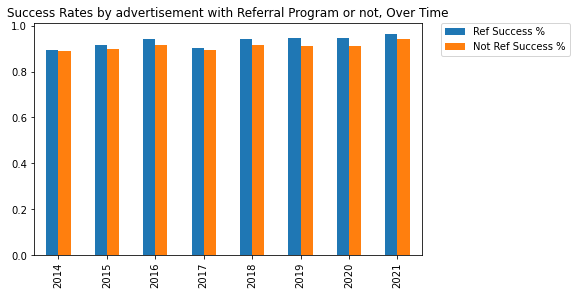

In [276]:
# EMPLOYEE REF PROGRAM
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY employee ref or not (IN TERMS OF ANNUAL APPLICATIONS)

top15 = df[df["EMPLOYEE_REF_PROG"]==1]
not15 = df[df["EMPLOYEE_REF_PROG"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["Ref Success %", "Not Ref Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by advertisement with Referral Program or not, Over Time")

Text(0.5, 1.0, 'Application Rates by advertisement with Referral Program or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

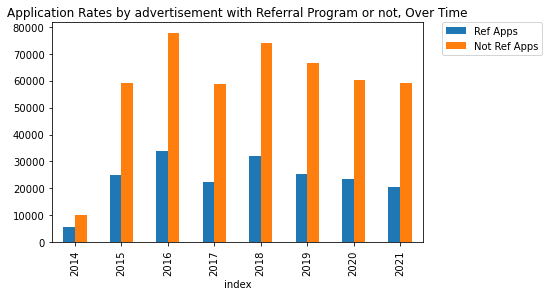

In [277]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["Ref Apps"] = pd.DataFrame(top15apps)
analysisdf["Not Ref Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["Ref Apps","Not Ref Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by advertisement with Referral Program or not, Over Time")

In [278]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["Ref Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not Ref Success %"]
    sample1_size = analysisdf.loc[yr[x]]["Ref Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not Ref Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Ref Vs. Not Ref"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["Ref Vs. Not Ref"]

In [279]:
# LINEAR REGRESSION BETWEEN Professional Occupation AND SUCCESS RATE OVER TIME
print("Ref success rate over time:",st.linregress(y = analysisdf["Ref Success %"], x = yr))
print("\nRef applications over time:",st.linregress(y = analysisdf["Ref Apps"], x = yr))

print("\n\nNot Ref success rate over time:",st.linregress(y = analysisdf["Not Ref Success %"], x = yr))
print("\nNot Ref applications over time:",st.linregress(y = analysisdf["Not Ref Apps"], x = yr))

Ref success rate over time: LinregressResult(slope=0.008517633019665908, intercept=-16.253340522093797, rvalue=0.8293626244982095, pvalue=0.010885783189670166, stderr=0.002342533562509839, intercept_stderr=4.726064510268739)

Ref applications over time: LinregressResult(slope=941.6428571428571, intercept=-1876191.4642857143, rvalue=0.2688590793684264, pvalue=0.5196555821588318, stderr=1377.1876689714054, intercept_stderr=2778477.9140290995)


Not Ref success rate over time: LinregressResult(slope=0.005341437347844598, intercept=-9.867355347807464, rvalue=0.767020965843767, pvalue=0.026348020423766244, stderr=0.0018241248083703228, intercept_stderr=3.6801741742829517)

Not Ref applications over time: LinregressResult(slope=3925.285714285714, intercept=-7860991.928571428, rvalue=0.4635529862146979, pvalue=0.24732274090221232, stderr=3063.119263318879, intercept_stderr=6179847.099215713)


In [280]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,Ref Success %,Not Ref Success %,Ref Apps,Not Ref Apps,PVAL Success %
index,,,,,
2014,0.89,0.89,"5,794.00","10,205.00",0.53
2015,0.91,0.90,"25,014.00","59,301.00",0.00
2016,0.94,0.91,"34,032.00","77,746.00",0.00
2017,0.90,0.89,"22,253.00","58,881.00",0.00
2018,0.94,0.91,"32,078.00","74,066.00",0.00
2019,0.95,0.91,"25,424.00","66,391.00",0.00
2020,0.95,0.91,"23,599.00","60,279.00",0.00
2021,0.96,0.94,"20,390.00","59,307.00",0.00
ALL YRS,0.94,0.91,"188,584.00","466,176.00",0.00


In [281]:
# DIVING DEEPER INTO THE REF PROGRAM!
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = 1
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY PW LEVEL
topstate = df[df["EMPLOYEE_REF_PROG"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
CA    LEVEL I                 5345     85000.0                  5.0   
      LEVEL II               13464    109762.0                  5.0   
      LEVEL III               5691    125000.0                  8.0   
      LEVEL IV               10134    139277.0                 11.0   
NY    LEVEL I                 2165     95000.0                  6.0   
      LEVEL II                5856    101254.0                  6.0   
      LEVEL III               3011    117630.0                  8.0   
      LEVEL IV               11777    133000.0                 11.0   
TX    LEVEL I                 1645     68162.0                  7.0   
      LEVEL II                6975     90002.0                 10.0   
      LEVEL III               4807     96470.0                 11.0   
      LEVEL IV                4464    116295.5                 12.0   
NJ    LEVEL I                 1105     72509.0                  9.0   
      LEVEL II                7292     90813.0                  9.0   
      LEVEL III               5232    109845.0                 10.0   
      LEVEL IV                4344    123490.0                 11.0   
MA    LEVEL I                  921    82102.81                  6.0   
      LEVEL II                4389     92914.0                  5.0   
      LEVEL III               2887    110250.0                  9.0   
      LEVEL IV                2803    124000.0                 11.0   
MI    LEVEL I                  836     70954.0                  7.0   
      LEVEL II                2677     80000.0                  7.0   
      LEVEL III               3410     90522.0                  8.0   
      LEVEL IV                2928    103750.0                 12.0   
IL    LEVEL I                  900     76005.0                  6.0   
      LEVEL II                2531     80912.0                  7.0   
      LEVEL III               2157     90000.0                  7.0   
      LEVEL IV                3067    111218.0                 11.0   
GA    LEVEL I                  520     63741.5                  8.0   
      LEVEL II                1498     77531.5                  7.0   
      LEVEL III               1056     96000.0                  7.0   
      LEVEL IV                2468    112486.0                 11.0   
FL    LEVEL I                  921     74880.0                  9.0   
      LEVEL II                2358     74880.0                 10.0   
      LEVEL III                941     88421.0                  9.0   
      LEVEL IV                1372    107050.0                 12.0   
VA    LEVEL I                  549     78000.0                  6.0   
      LEVEL II                1529     90646.0                  7.0   
      LEVEL III               1193    110490.0                  7.0   
      LEVEL IV                1742    127379.0                 11.0   
PA    LEVEL I                  460     72000.0                  8.0   
      LEVEL II                1129     76461.0                  8.0   
      LEVEL III                471     96429.0                  8.0   
      LEVEL IV                2364    102000.0                 11.0   
WA    LEVEL I                  307     85426.0                  6.0   
      LEVEL II                1207    107000.0                  8.0   
      LEVEL III                680  122537.735                 10.0   
      LEVEL IV                1215    133806.0                 11.0   
NC    LEVEL I                  242     75025.0                  7.0   
      LEVEL II                1149     89253.0                  8.0   
      LEVEL III                514    102648.0                  9.0   
      LEVEL IV                1090    115000.0                 12.0   
OH    LEVEL I                  223     70000.0                  6.0   
      LEVEL II                 952     77210.0                  8.0   
      LEVEL III                565     9

In [282]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYEE_REF_PROG"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
CA    HIGH SCHOOL                 52     96381.5                 21.0   
      ASSOCIATE'S                168     79250.0                 15.0   
      BACHELOR'S               14366    121306.0                 11.0   
      MASTER'S                 23103    115086.0                  6.0   
      DOCTORATE                 1485    125200.0                  4.0   
...                              ...         ...                  ...   
OR    ASSOCIATE'S                  4     89634.0                 16.5   
      BACHELOR'S                 340    106173.5                 12.0   
      MASTER'S                  1629     86195.0                  3.0   
      DOCTORATE                  773     97053.0                  1.0   
      OTHER                       36    130457.5                  9.0   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
CA    HIGH SCHOOL                 161.0  
      ASSOCIATE'S                 204.5  
      BACHELOR'S                  140.0  
      MASTER'S                    142.0  
      DOCTORATE                   143.0  
...                                 ...  
OR    ASSOCIATE'S            135.906163  
      BACHELOR'S             119.649664  
      MASTER'S               121.501528  
      DOCTORATE                   125.0  
      OTHER                       107.5  

[90 rows x 4 columns]

Text(0.5, 1.0, 'Success Rates by advertisement with Professional Organization or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

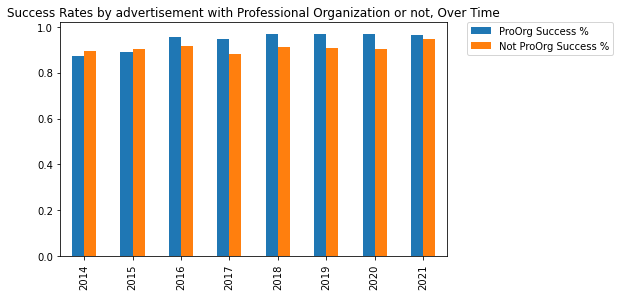

In [283]:
# ADVERTISEMENT THROUGH PROFESSIONAL ADVERTISEMENT?
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY employee ref or not (IN TERMS OF ANNUAL APPLICATIONS)

top15 = df[df["PRO_ORG_AD"]==1]
not15 = df[df["PRO_ORG_AD"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["ProOrg Success %", "Not ProOrg Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by advertisement with Professional Organization or not, Over Time")

Text(0.5, 1.0, 'Application Rates by advertisement with Professional Organization or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

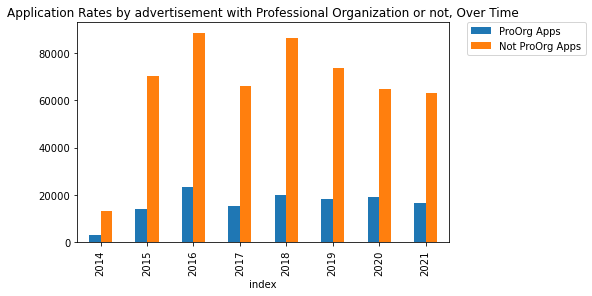

In [284]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["ProOrg Apps"] = pd.DataFrame(top15apps)
analysisdf["Not ProOrg Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["ProOrg Apps","Not ProOrg Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by advertisement with Professional Organization or not, Over Time")

In [285]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["ProOrg Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not ProOrg Success %"]
    sample1_size = analysisdf.loc[yr[x]]["ProOrg Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not ProOrg Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["ProOrg Vs. Not ProOrg"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["ProOrg Vs. Not ProOrg"]

In [286]:
# LINEAR REGRESSION BETWEEN Professional Advertisement AND SUCCESS RATE OVER TIME
print("ProOrg success rate over time:",st.linregress(y = analysisdf["ProOrg Success %"], x = yr))
print("\nProOrg applications over time:",st.linregress(y = analysisdf["ProOrg Apps"], x = yr))

print("\n\nNot ProOrg success rate over time:",st.linregress(y = analysisdf["Not ProOrg Success %"], x = yr))
print("\nNot ProOrg applications over time:",st.linregress(y = analysisdf["Not ProOrg Apps"], x = yr))

ProOrg success rate over time: LinregressResult(slope=0.013054651734399732, intercept=-25.394978980566844, rvalue=0.8282383018789962, pvalue=0.011092431104238172, stderr=0.0036059019948579264, intercept_stderr=7.274911966318399)

ProOrg applications over time: LinregressResult(slope=1302.9404761904761, intercept=-2612460.7857142854, rvalue=0.5250873836254573, pvalue=0.18146152034015062, stderr=862.1276714787244, intercept_stderr=1739343.6989354184)


Not ProOrg success rate over time: LinregressResult(slope=0.004333887589896002, intercept=-7.83543942220076, rvalue=0.5928206515589761, pvalue=0.12142799560904914, stderr=0.0024035601973951006, intercept_stderr=4.849185825552414)

Not ProOrg applications over time: LinregressResult(slope=3563.9880952380954, intercept=-7124722.607142857, rvalue=0.3747959899690394, pvalue=0.3602946045870789, stderr=3599.114719119844, intercept_stderr=7261218.628685793)


In [287]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,ProOrg Success %,Not ProOrg Success %,ProOrg Apps,Not ProOrg Apps,PVAL Success %
index,,,,,
2014,0.87,0.90,"2,959.00","13,040.00",0.00
2015,0.89,0.90,"14,198.00","70,117.00",0.00
2016,0.96,0.91,"23,345.00","88,433.00",0.00
2017,0.95,0.88,"15,310.00","65,824.00",0.00
2018,0.97,0.91,"19,960.00","86,184.00",0.00
2019,0.97,0.91,"18,281.00","73,534.00",0.00
2020,0.97,0.90,"19,174.00","64,704.00",0.00
2021,0.96,0.94,"16,546.00","63,151.00",0.00
ALL YRS,0.95,0.91,"129,773.00","524,987.00",0.00


In [288]:
# DIVING DEEPER INTO THE pro org ad
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = 1
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY PW LEVEL
topstate = df[df["PRO_ORG_AD"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
CA    LEVEL I                 7639    117251.0                  4.0   
      LEVEL II               20474    125000.0                  5.0   
      LEVEL III               8095    140000.0                  6.0   
      LEVEL IV                7922    154672.0                 11.0   
WA    LEVEL I                 5132    116907.7                  4.0   
      LEVEL II                8527    120540.0                  4.0   
      LEVEL III               3172    134735.0                  9.0   
      LEVEL IV                2273    153795.0                 12.0   
TX    LEVEL I                 1272     72000.0                  9.0   
      LEVEL II                5521     90646.0                 10.0   
      LEVEL III               3283     95285.0                 13.0   
      LEVEL IV                2576    117936.0                 12.0   
NY    LEVEL I                 1121    113050.0                  5.0   
      LEVEL II                2239    100526.0                  8.0   
      LEVEL III               1395    117030.0                  9.0   
      LEVEL IV                1451    137426.0                  8.0   
NJ    LEVEL I                  179     73445.0                 10.0   
      LEVEL II                1921     83741.0                 11.0   
      LEVEL III               1258    112341.0                 11.0   
      LEVEL IV                 949    126500.0                 11.0   
MA    LEVEL I                  496    114000.0                  6.0   
      LEVEL II                 871    100000.0                  6.0   
      LEVEL III               1499    110000.0                 10.0   
      LEVEL IV                 630    128000.0                 11.0   
IL    LEVEL I                  343     94000.0                  6.0   
      LEVEL II                 842     94413.6                  7.0   
      LEVEL III                648     97440.0                 10.0   
      LEVEL IV                 736    115000.0                 10.0   
OR    LEVEL I                  104     99882.0                  6.5   
      LEVEL II                1200     88234.0                  2.0   
      LEVEL III                784     94682.0                  2.0   
      LEVEL IV                 190    115939.0                 11.0   
MI    LEVEL I                  713     96613.8                 11.0   
      LEVEL II                 997     93510.0                  7.0   
      LEVEL III                262     95933.5                  8.0   
      LEVEL IV                 476    105019.0                 12.0   
PA    LEVEL I                  383    185000.0                  8.0   
      LEVEL II                 774     87235.0                  8.0   
      LEVEL III                567    104270.0                 10.0   
      LEVEL IV                 486    110000.0                 10.0   
NC    LEVEL I                  303     90000.0                  8.0   
      LEVEL II                 542     96772.0                  7.0   
      LEVEL III                359     97198.0                 11.0   
      LEVEL IV                 578    118630.0                 12.0   
FL    LEVEL I                  279     75000.0                  9.0   
      LEVEL II                 373     80082.0                  7.0   
      LEVEL III                246     90000.0                  9.0   
      LEVEL IV                 506    110000.0                 12.0   
VA    LEVEL I                  281     91624.0                  7.0   
      LEVEL II                 405     97094.0                  7.0   
      LEVEL III                324    110490.0                  5.0   
      LEVEL IV                 332    132329.5                 10.0   
GA    LEVEL I                  248     67725.0                  8.0   
      LEVEL II                 316     87000.0                  6.0   
      LEVEL III                140     9

In [289]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["PRO_ORG_AD"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
CA    HIGH SCHOOL                 24     93467.0                 18.0   
      ASSOCIATE'S                 47    121160.0                 14.0   
      BACHELOR'S               16057    133205.0                 10.0   
      MASTER'S                 33673    127937.5                  5.0   
      DOCTORATE                 3187    138000.0                  3.0   
...                              ...         ...                  ...   
AZ    ASSOCIATE'S                  1     65250.0                 19.0   
      BACHELOR'S                 184    101085.5                 13.5   
      MASTER'S                   595     78765.0                  3.0   
      DOCTORATE                  103     93371.0                  2.0   
      OTHER                       54    201984.0                 10.5   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
CA    HIGH SCHOOL                 178.5  
      ASSOCIATE'S            158.403437  
      BACHELOR'S                  132.0  
      MASTER'S               136.340926  
      DOCTORATE                   134.0  
...                                 ...  
AZ    ASSOCIATE'S                 189.0  
      BACHELOR'S                  154.0  
      MASTER'S                    167.0  
      DOCTORATE                   166.0  
      OTHER                   133.67316  

[90 rows x 4 columns]

In [290]:
# AP TO PW DETERMINE SPEED
# CREATING A NEW COLUMN: APP GROUP, SPLITS DAYS INTO THIRDS
df["APP_TO_PW_DETERMINE"] = df["APP_TO_PW_DETERMINE"].replace("#VALUE!",np.nan).astype(float)
high = df.groupby("YEAR")["APP_TO_PW_DETERMINE"].quantile(2/3).tolist()
low = df.groupby("YEAR")["APP_TO_PW_DETERMINE"].quantile(1/3).tolist()
df["APP_GROUP"] = np.nan
for x in range(len(yr)):
    df["APP_GROUP"] = np.where((df["YEAR"]==yr[x])&(df["APP_TO_PW_DETERMINE"]<low[x]),"FAST",df["APP_GROUP"])
    df["APP_GROUP"] = np.where((df["YEAR"]==yr[x])&(df["APP_TO_PW_DETERMINE"]>=low[x])&(df["APP_TO_PW_DETERMINE"]<high[x]),"MEDIUM",df["APP_GROUP"])
    df["APP_GROUP"] = np.where((df["YEAR"]==yr[x])&(df["APP_TO_PW_DETERMINE"]>=high[x]),"SLOW",df["APP_GROUP"])


Text(0.5, 1.0, 'Success Rates by Time To Apply Since PW Determine, Over Time')

<Figure size 1200x1000 with 0 Axes>

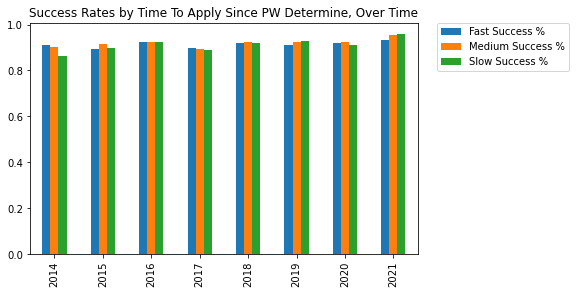

In [291]:
# CORRELATION ANALYSIS: AGGREGATE BY SIZE BRACKETS AND YEARLY
# PLOTTING SUCCESS RATES OVER TIME BY SIZE OF COMPANY

young = df[df["APP_GROUP"]=="FAST"]
mid = df[df["APP_GROUP"]=="MEDIUM"]
old = df[df["APP_GROUP"]=="SLOW"]


youndf = pd.DataFrame()
middf = pd.DataFrame()
olddf = pd.DataFrame()
linregdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(young[(young["YEAR"]==yr[x])&(young["CASE_STATUS"]==1)])/len(young[young["YEAR"]==yr[x]])])
    med = pd.DataFrame([len(mid[(mid["YEAR"]==yr[x])&(mid["CASE_STATUS"]==1)])/len(mid[mid["YEAR"]==yr[x]])])
    oldy = pd.DataFrame([len(old[(old["YEAR"]==yr[x])&(old["CASE_STATUS"]==1)])/len(old[old["YEAR"]==yr[x]])])
    youndf = pd.concat([youndf,j])
    middf = pd.concat([middf,med])
    olddf = pd.concat([olddf,oldy])
    linregdf = pd.concat([youndf,middf,olddf], axis = 1)
    

linregdf.index = yr
linregdf.columns = ["Fast Success %", "Medium Success %", "Slow Success %"]
plt.figure(figsize = (12,10), dpi = 100)
linregdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Time To Apply Since PW Determine, Over Time")


Text(0.5, 1.0, 'Application Rates by Time To Apply Since PW Determine, Over Time')

<Figure size 1200x1000 with 0 Axes>

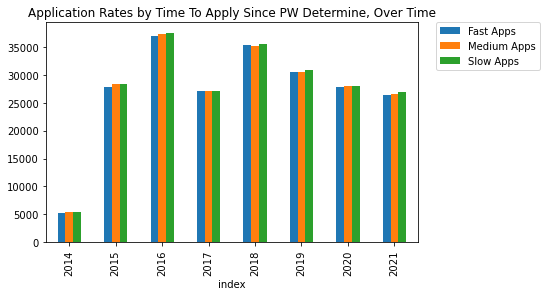

In [292]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
youngapps = []
midapps = []
oldapps = []

for x in range(len(yr)):
    y = (young["YEAR"]==yr[x]).sum()
    m = (mid["YEAR"]==yr[x]).sum()
    o = (old["YEAR"]==yr[x]).sum()
    youngapps.append(y)
    midapps.append(m)
    oldapps.append(o)
linregdf = linregdf.reset_index()
linregdf["Fast Apps"] = pd.DataFrame(youngapps)
linregdf["Medium Apps"] = pd.DataFrame(midapps)
linregdf["Slow Apps"] = pd.DataFrame(oldapps)
linregdf = linregdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY SIZE OF COMPANY
plt.figure(figsize = (12,10), dpi = 100)
linregdf.reset_index().plot(x = "index", y = ["Fast Apps","Medium Apps","Slow Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Time To Apply Since PW Determine, Over Time")


In [293]:
# P VALUE PER YEAR
young_med = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Fast Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Medium Success %"]
    sample1_size = linregdf.loc[yr[x]]["Fast Apps"]
    sample2_size = linregdf.loc[yr[x]]["Medium Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    young_med.append(pval)

pvaldf = pd.DataFrame(young_med)

young_old = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Fast Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Slow Success %"]
    sample1_size = linregdf.loc[yr[x]]["Fast Apps"]
    sample2_size = linregdf.loc[yr[x]]["Slow Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    young_old.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(young_old)], axis = 1)

med_old = []
for x in range(len(yr)):
    sample1_phat = linregdf.loc[yr[x]]["Medium Success %"]
    sample2_phat = linregdf.loc[yr[x]]["Slow Success %"]
    sample1_size = linregdf.loc[yr[x]]["Medium Apps"]
    sample2_size = linregdf.loc[yr[x]]["Slow Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    med_old.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(med_old)], axis = 1)
pvaldf.columns = ["Fast_Med","Fast_Slow","Med_Slow"]
pvaldf.index = yr
linregdf[["Fast_Med","Fast_Slow","Med_Slow"]] = pvaldf[["Fast_Med","Fast_Slow","Med_Slow"]]


In [294]:
# LINEAR REGRESSION BETWEEN Speed to Apply and success
print("Fast success rate over time:",st.linregress(y = linregdf["Fast Success %"], x = yr))
print("\nFast applications over time:",st.linregress(y = linregdf["Fast Apps"], x = yr))

print("\n\nMedium success rate over time:",st.linregress(y = linregdf["Medium Success %"], x = yr))
print("\nMedium applications over time:",st.linregress(y = linregdf["Medium Apps"], x = yr))

print("\n\nSlow success rate over time:",st.linregress(y = linregdf["Slow Success %"], x = yr))
print("\nSlow applications over time:",st.linregress(y = linregdf["Slow Apps"], x = yr))


Fast success rate over time: LinregressResult(slope=0.003378656117698397, intercept=-5.902374344604465, rvalue=0.644758934779172, pvalue=0.08433643037575893, stderr=0.0016352482982847348, intercept_stderr=3.299115569435251)

Fast applications over time: LinregressResult(slope=1638.25, intercept=-3278043.75, rvalue=0.4141227699783864, pvalue=0.3077286865234105, stderr=1470.0168356259765, intercept_stderr=2965760.878536101)


Medium success rate over time: LinregressResult(slope=0.005521080787136572, intercept=-10.218847979911029, rvalue=0.7637382370256863, pvalue=0.027403980425766847, stderr=0.0019050997838696343, intercept_stderr=3.8435412927105537)

Medium applications over time: LinregressResult(slope=1594.1904761904761, intercept=-3189017.5357142854, rvalue=0.4034037546602719, pvalue=0.3216714559036434, stderr=1476.2374684980668, intercept_stderr=2978311.013449301)


Slow success rate over time: LinregressResult(slope=0.009416402412818957, intercept=-18.085605598398303, rvalue=0.813

In [295]:
# GETTING THE TOTAL PVAL
linregdf.loc["ALL YRS"] = linregdf.sum()
youngsuc = []
medsuc = []
oldsuc = []
for x in range(len(yr)):
    y = linregdf.loc[yr[x]].iloc[0]*linregdf.loc[yr[x]].iloc[3]
    m = linregdf.loc[yr[x]].iloc[1]*linregdf.loc[yr[x]].iloc[4]
    o = linregdf.loc[yr[x]].iloc[2]*linregdf.loc[yr[x]].iloc[5]
    youngsuc.append(y)
    medsuc.append(m)
    oldsuc.append(o)
linregdf.loc["ALL YRS"].iloc[0] = sum(youngsuc)/linregdf.loc["ALL YRS"].iloc[3]
linregdf.loc["ALL YRS"].iloc[1] = sum(medsuc)/linregdf.loc["ALL YRS"].iloc[4]
linregdf.loc["ALL YRS"].iloc[2] = sum(oldsuc)/linregdf.loc["ALL YRS"].iloc[5]


for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample1_size = linregdf.loc["ALL YRS"].iloc[3]
    sample2_size = linregdf.loc["ALL YRS"].iloc[4]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[6] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[0]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[3]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[7] = pval

for x in range(len(yr)):
    sample1_phat = linregdf.loc["ALL YRS"].iloc[1]
    sample2_phat = linregdf.loc["ALL YRS"].iloc[2]
    sample1_size = linregdf.loc["ALL YRS"].iloc[4]
    sample2_size = linregdf.loc["ALL YRS"].iloc[5]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
linregdf.loc["ALL YRS"].iloc[8] = pval
linregdf = linregdf.head(9).style.format("{:,.2f}")
linregdf


,Fast Success %,Medium Success %,Slow Success %,Fast Apps,Medium Apps,Slow Apps,Fast_Med,Fast_Slow,Med_Slow
index,,,,,,,,,
2014,0.91,0.90,0.86,"5,215.00","5,362.00","5,419.00",0.13,0.00,0.00
2015,0.90,0.91,0.90,"27,741.00","28,270.00","28,301.00",0.00,0.38,0.00
2016,0.92,0.92,0.92,"36,956.00","37,309.00","37,513.00",0.58,0.29,0.61
2017,0.90,0.90,0.89,"27,019.00","27,047.00","27,068.00",0.26,0.00,0.06
2018,0.92,0.92,0.92,"35,361.00","35,187.00","35,596.00",0.01,0.73,0.02
2019,0.91,0.92,0.93,"30,479.00","30,493.00","30,840.00",0.00,0.00,0.29
2020,0.92,0.93,0.91,"27,863.00","27,939.00","28,072.00",0.07,0.00,0.00
2021,0.93,0.95,0.96,"26,371.00","26,487.00","26,839.00",0.00,0.00,0.00
ALL YRS,0.92,0.92,0.92,"217,005.00","218,094.00","219,648.00",0.00,0.00,0.00


In [298]:
### EMPLOYEE RELATED ANALYSIS ###

In [299]:
#CLASS OF ADMISSION
df["CLASS_OF_ADMISSION"].value_counts()[:15].iplot(kind = "bar")

Text(0.5, 1.0, 'Success Rates by H1B or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

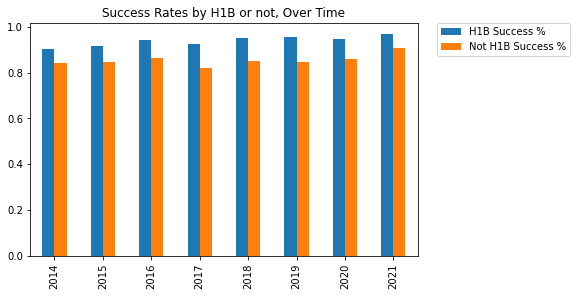

In [300]:
# H1B really different??
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY class (IN TERMS OF ANNUAL APPLICATIONS)

top15 = df[df["CLASS_OF_ADMISSION"]=="H-1B"]
not15 = df[df["CLASS_OF_ADMISSION"]!="H-1B"]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["H1B Success %", "Not H1B Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by H1B or not, Over Time")

Text(0.5, 1.0, 'Application Rates by H1B or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

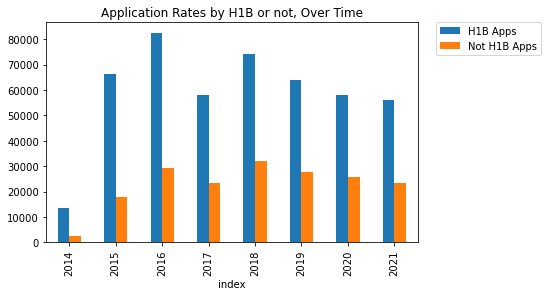

In [301]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["H1B Apps"] = pd.DataFrame(top15apps)
analysisdf["Not H1B Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["H1B Apps","Not H1B Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by H1B or not, Over Time")

In [302]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["H1B Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not H1B Success %"]
    sample1_size = analysisdf.loc[yr[x]]["H1B Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not H1B Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["H1B Vs. Not H1B"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["H1B Vs. Not H1B"]

In [303]:
# LINEAR REGRESSION BETWEEN Professional Occupation AND SUCCESS RATE OVER TIME
print("H1B success rate over time:",st.linregress(y = analysisdf["H1B Success %"], x = yr))
print("\nH1B applications over time:",st.linregress(y = analysisdf["H1B Apps"], x = yr))

print("\n\nNot H1B success rate over time:",st.linregress(y = analysisdf["Not H1B Success %"], x = yr))
print("\nNot H1B applications over time:",st.linregress(y = analysisdf["Not H1B Apps"], x = yr))

H1B success rate over time: LinregressResult(slope=0.007887269388875564, intercept=-14.974422266329311, rvalue=0.8854949081893182, pvalue=0.0034383616195992955, stderr=0.001689623971931741, intercept_stderr=3.408818561767081)

H1B applications over time: LinregressResult(slope=2608.6428571428573, intercept=-5203895.964285715, rvalue=0.3114749052690365, pvalue=0.45265797762639504, stderr=3249.045674686925, intercept_stderr=6554953.876062356)


Not H1B success rate over time: LinregressResult(slope=0.006025492463860842, intercept=-11.301808269594067, rvalue=0.5900908195583722, pvalue=0.1235917333423505, stderr=0.0033655252400268208, intercept_stderr=6.789951550688885)

Not H1B applications over time: LinregressResult(slope=2258.285714285714, intercept=-4533287.428571428, rvalue=0.6002434583369194, pvalue=0.1156531093474238, stderr=1228.4759149841502, intercept_stderr=2478451.7568687447)


In [304]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,H1B Success %,Not H1B Success %,H1B Apps,Not H1B Apps,PVAL Success %
index,,,,,
2014,0.90,0.84,"13,372.00","2,627.00",0.00
2015,0.92,0.85,"66,301.00","18,014.00",0.00
2016,0.94,0.86,"82,471.00","29,307.00",0.00
2017,0.93,0.82,"57,945.00","23,189.00",0.00
2018,0.95,0.85,"74,005.00","32,139.00",0.00
2019,0.95,0.85,"63,988.00","27,827.00",0.00
2020,0.95,0.86,"58,049.00","25,829.00",0.00
2021,0.97,0.91,"56,197.00","23,500.00",0.00
ALL YRS,0.94,0.86,"472,328.00","182,432.00",0.00


In [305]:
# DIVING DEEPER INTO H1B
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = "H-1B"
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY PW LEVEL
topstate = df[df["CLASS_OF_ADMISSION"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
CA    LEVEL I                13674    107000.0                  5.0   
      LEVEL II               46626    119122.0                  5.0   
      LEVEL III              18523    133016.0                  7.0   
      LEVEL IV               23215    143000.0                 11.0   
TX    LEVEL I                 4929     70000.0                  7.0   
      LEVEL II               19646     83000.0                  9.0   
      LEVEL III              10450     95971.0                 10.0   
      LEVEL IV               20259     93475.0                 11.0   
NJ    LEVEL I                 2420     72197.0                  8.0   
      LEVEL II               14806     88000.0                 10.0   
      LEVEL III              11861    104936.0                 10.0   
      LEVEL IV                9703    123490.0                 12.0   
NY    LEVEL I                 5415     90000.0                  6.0   
      LEVEL II               11171    100000.0                  6.0   
      LEVEL III               5119    117257.0                  7.0   
      LEVEL IV               13926    131997.0                 10.0   
WA    LEVEL I                 5160    110000.0                  4.0   
      LEVEL II               16241    106101.0                  4.0   
      LEVEL III               3828   128186.25                  9.0   
      LEVEL IV                3393    138965.0                 11.0   
IL    LEVEL I                 2820     77459.0                  6.0   
      LEVEL II                5763     83366.0                  7.0   
      LEVEL III               5145     96100.0                 10.0   
      LEVEL IV                5768    112925.0                 11.0   
MA    LEVEL I                 2446     87000.0                  5.0   
      LEVEL II                6580     94589.0                  5.0   
      LEVEL III               4038    110250.0                  9.0   
      LEVEL IV                4695    124000.0                 11.0   
MI    LEVEL I                 1820     80000.0                  6.0   
      LEVEL II                5268     80000.0                  7.0   
      LEVEL III               4789     90459.0                  8.0   
      LEVEL IV                4375    104187.0                 12.0   
VA    LEVEL I                 1851     80000.0                  6.0   
      LEVEL II                4658     93000.0                  7.0   
      LEVEL III               3049    110000.0                  7.0   
      LEVEL IV                3456    127379.0                 11.0   
GA    LEVEL I                 1620     70335.5                  6.0   
      LEVEL II                3382     82100.0                  7.0   
      LEVEL III               2204     96000.0                  7.0   
      LEVEL IV                4579    113693.0                 12.0   
PA    LEVEL I                 2266     80000.0                  6.0   
      LEVEL II                3126     82451.0                  7.0   
      LEVEL III               1534     96689.0                  9.0   
      LEVEL IV                4145    103314.0                 11.0   
FL    LEVEL I                 2219     74880.0                  7.0   
      LEVEL II                3899     74880.0                  9.0   
      LEVEL III               1873     89814.0                  8.0   
      LEVEL IV                3054    107578.0                 12.0   
NC    LEVEL I                 1081     79500.0                  7.0   
      LEVEL II                2776     89918.0                  7.0   
      LEVEL III               1875     97500.0                 10.0   
      LEVEL IV                2614    115182.5                 12.0   
OH    LEVEL I                 1346    77421.75                  6.0   
      LEVEL II                1929     85000.0                  7.0   
      LEVEL III               1264     9

In [306]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["CLASS_OF_ADMISSION"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1


TOTAL APPLICATIONS    MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                            
CA    HIGH SCHOOL                 43  116849.892216                 21.0   
      ASSOCIATE'S                180        89700.0                 16.0   
      BACHELOR'S               34685       128170.0                 11.0   
      MASTER'S                 74724       122158.0                  5.0   
      DOCTORATE                 6154       126000.0                  4.0   
...                              ...            ...                  ...   
AZ    ASSOCIATE'S                  3       101483.0                 35.0   
      BACHELOR'S                2359       100368.0                 12.0   
      MASTER'S                  2649        85000.0                  6.0   
      DOCTORATE                  319        90103.0                  4.0   
      OTHER                      262       199992.0                 10.0   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
CA    HIGH SCHOOL                 146.0  
      ASSOCIATE'S                 208.5  
      BACHELOR'S                  135.0  
      MASTER'S                    138.0  
      DOCTORATE                   140.0  
...                                 ...  
AZ    ASSOCIATE'S                 104.0  
      BACHELOR'S             134.615058  
      MASTER'S               141.584526  
      DOCTORATE                   145.0  
      OTHER                  135.248466  

[90 rows x 4 columns]

Text(0.5, 1.0, 'Success Rates by L1/F1 or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

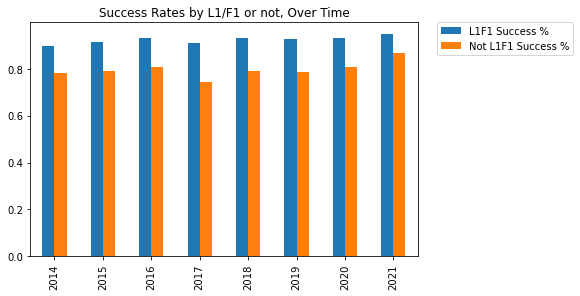

In [307]:
# WHAT ABOUT L1 OR F1 Vs THE REST - except for H1B...
# ADVERTISEMENT THROUGH PROFESSIONAL ADVERTISEMENT?
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY employee ref or not (IN TERMS OF ANNUAL APPLICATIONS)

top15 = df[(df["CLASS_OF_ADMISSION"]=="L-1")|(df["CLASS_OF_ADMISSION"]=="F-1")]
not15 = df[(df["CLASS_OF_ADMISSION"]!="L-1")&(df["CLASS_OF_ADMISSION"]!="F-1")&(df["CLASS_OF_ADMISSION"]!="H-1B")]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["L1F1 Success %", "Not L1F1 Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by L1/F1 or not, Over Time")

Text(0.5, 1.0, 'Application Rates by L1/F1 or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

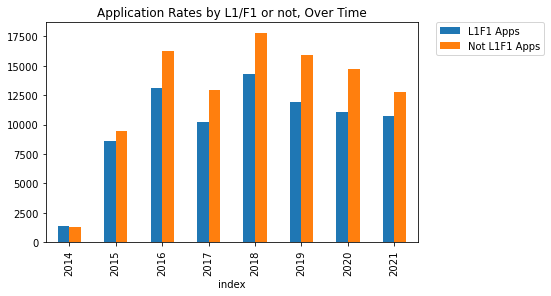

In [308]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["L1F1 Apps"] = pd.DataFrame(top15apps)
analysisdf["Not L1F1 Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["L1F1 Apps","Not L1F1 Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by L1/F1 or not, Over Time")

In [309]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["L1F1 Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not L1F1 Success %"]
    sample1_size = analysisdf.loc[yr[x]]["L1F1 Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not L1F1 Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["L1F1 Vs. Not L1F1"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["L1F1 Vs. Not L1F1"]

In [310]:
# LINEAR REGRESSION BETWEEN L1/F1 Occupation AND SUCCESS RATE OVER TIME
print("L1F1 success rate over time:",st.linregress(y = analysisdf["L1F1 Success %"], x = yr))
print("\nL1F1 applications over time:",st.linregress(y = analysisdf["L1F1 Apps"], x = yr))

print("\n\nNot L1F1 success rate over time:",st.linregress(y = analysisdf["Not L1F1 Success %"], x = yr))
print("\nNot L1F1 applications over time:",st.linregress(y = analysisdf["Not L1F1 Apps"], x = yr))

L1F1 success rate over time: LinregressResult(slope=0.005669813998314651, intercept=-10.51452064831312, rvalue=0.8344770042331204, pvalue=0.00997657844518263, stderr=0.0015284953377769656, intercept_stderr=3.0837413327129677)

L1F1 applications over time: LinregressResult(slope=937.7738095238095, intercept=-1881793.2857142857, rvalue=0.5781546657698499, pvalue=0.1333051996733859, stderr=540.2936287452043, intercept_stderr=1090043.0989774982)


Not L1F1 success rate over time: LinregressResult(slope=0.00810331278253853, intercept=-15.551532983749869, rvalue=0.5653118899612447, pvalue=0.14421573398318305, stderr=0.004827120944279828, intercept_stderr=9.738722785723162)

Not L1F1 applications over time: LinregressResult(slope=1320.5119047619048, intercept=-2651494.142857143, rvalue=0.6146903139224688, pvalue=0.10486822889808384, stderr=691.7671093708718, intercept_stderr=1395641.0432241734)


In [311]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,L1F1 Success %,Not L1F1 Success %,L1F1 Apps,Not L1F1 Apps,PVAL Success %
index,,,,,
2014,0.90,0.78,"1,346.00","1,281.00",0.00
2015,0.91,0.79,"8,572.00","9,442.00",0.00
2016,0.93,0.81,"13,070.00","16,237.00",0.00
2017,0.91,0.74,"10,261.00","12,928.00",0.00
2018,0.93,0.79,"14,343.00","17,796.00",0.00
2019,0.93,0.79,"11,930.00","15,897.00",0.00
2020,0.93,0.81,"11,107.00","14,722.00",0.00
2021,0.95,0.87,"10,694.00","12,806.00",0.00
ALL YRS,0.93,0.80,"81,323.00","101,109.00",0.00


In [312]:
# CREATING A COLUMN JUST FOR L1F1
df["L1F1"] = np.where((df["CLASS_OF_ADMISSION"]=="L-1")|(df["CLASS_OF_ADMISSION"]=="F-1"),1,0)

In [313]:
# DIVING DEEPER INTO THE L1/F1
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = 1
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY PW LEVEL
topstate = df[df["L1F1"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
CA    LEVEL I                 5147     79248.0                  4.0   
      LEVEL II                7463    110510.0                  4.0   
      LEVEL III               3384  131706.715                  8.0   
      LEVEL IV                3716    146098.5                 12.0   
WA    LEVEL I                 2260    110205.0                  3.0   
      LEVEL II                5984    101837.0                  4.0   
      LEVEL III               1368    132080.0                  9.0   
      LEVEL IV                1067    147000.0                 12.0   
TX    LEVEL I                 1084     71676.5                  5.0   
      LEVEL II                2767     81890.0                  9.0   
      LEVEL III               1312     96470.0                 11.0   
      LEVEL IV                2540     93475.0                 12.0   
NY    LEVEL I                 1370     78000.0                  5.0   
      LEVEL II                1676     99004.0                  7.0   
      LEVEL III                842    117624.0                  9.0   
      LEVEL IV                1660    140046.0                 11.0   
NJ    LEVEL I                  473     62000.0                  5.0   
      LEVEL II                1191     83741.0                  7.0   
      LEVEL III                889    103626.0                 10.0   
      LEVEL IV                 659    120182.0                 12.0   
OR    LEVEL I                  179     39166.0                  3.0   
      LEVEL II                1318     86195.0                  1.0   
      LEVEL III                836     93579.0                  1.0   
      LEVEL IV                 264    115939.0                 13.0   
FL    LEVEL I                  709     52000.0                  5.0   
      LEVEL II                 617     76960.0                  5.0   
      LEVEL III                365     85000.0                  9.0   
      LEVEL IV                 697    106122.0                 13.0   
MI    LEVEL I                  677     90626.0                 10.0   
      LEVEL II                 877     84656.0                  8.0   
      LEVEL III                432     93136.0                  9.0   
      LEVEL IV                 515    103709.0                 13.0   
IL    LEVEL I                  487     60000.0                  4.0   
      LEVEL II                 599     80974.0                  6.0   
      LEVEL III                558     90294.5                 10.0   
      LEVEL IV                 706    107515.0                 12.0   
MA    LEVEL I                  370     83386.5                  4.0   
      LEVEL II                 750     95000.0                  7.0   
      LEVEL III                286    108698.5                  9.0   
      LEVEL IV                 502    127002.5                 12.0   
PA    LEVEL I                  246     70010.0                  4.0   
      LEVEL II                 641     84552.0                  8.0   
      LEVEL III                643    103563.0                 10.0   
      LEVEL IV                 414    112341.0                 13.0   
GA    LEVEL I                  827     21840.0                  5.0   
      LEVEL II                 406     80000.0                  7.0   
      LEVEL III                220     93413.0                  8.0   
      LEVEL IV                 409    110000.0                 12.0   
VA    LEVEL I                  512     59623.0                  4.0   
      LEVEL II                 711     90000.0                  4.0   
      LEVEL III                271    105144.0                  5.0   
      LEVEL IV                 236    119891.0                 11.0   
NC    LEVEL I                  384     22391.2                  4.5   
      LEVEL II                 310     92000.0                  8.0   
      LEVEL III                197     9

In [314]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["L1F1"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
CA    HIGH SCHOOL                417     26499.0                 13.0   
      ASSOCIATE'S                277     43680.0                  7.0   
      BACHELOR'S                8794    120000.0                 10.0   
      MASTER'S                 10962    113000.0                  4.0   
      DOCTORATE                 1357    131726.0                  2.0   
...                              ...         ...                  ...   
AZ    ASSOCIATE'S                  4     64303.5                 20.5   
      BACHELOR'S                 278     97401.0                 12.0   
      MASTER'S                   608     78582.0                  2.0   
      DOCTORATE                  134     91749.0                  1.0   
      OTHER                       19     99466.0                 17.0   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
CA    HIGH SCHOOL                 158.0  
      ASSOCIATE'S                 185.0  
      BACHELOR'S             133.554132  
      MASTER'S                    138.0  
      DOCTORATE                   130.0  
...                                 ...  
AZ    ASSOCIATE'S                 155.0  
      BACHELOR'S                  140.0  
      MASTER'S                    146.0  
      DOCTORATE              117.271267  
      OTHER                        93.0  

[90 rows x 4 columns]

Text(0.5, 1.0, 'Success Rates by Required Training Completed or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

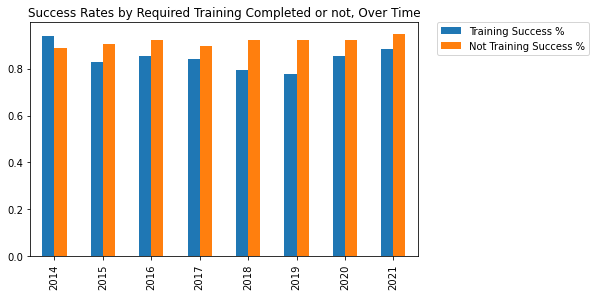

In [315]:
# FOREIGN WORKER TRAINING COMPLETED? THERE WILL BE A LOT 0 DUE TO N/A or missing 
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY TRAINING COMPLETE or not/not applicable (IN TERMS OF ANNUAL APPLICATIONS)

top15 = df[df["FOREIGN_WORKER_TRAINING_COMP"]==1]
not15 = df[df["FOREIGN_WORKER_TRAINING_COMP"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["Training Success %", "Not Training Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Required Training Completed or not, Over Time")

Text(0.5, 1.0, 'Application Rates by Required Training or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

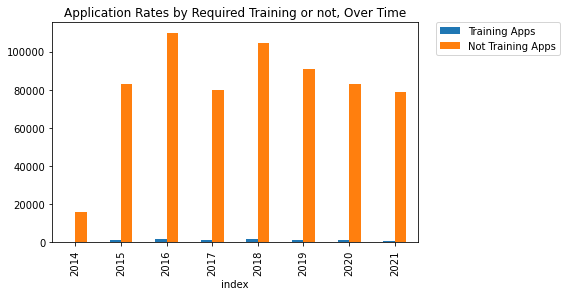

In [316]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["Training Apps"] = pd.DataFrame(top15apps)
analysisdf["Not Training Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["Training Apps","Not Training Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Required Training or not, Over Time")

In [317]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["Training Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not Training Success %"]
    sample1_size = analysisdf.loc[yr[x]]["Training Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not Training Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Training Vs. Not Training"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["Training Vs. Not Training"]

In [318]:
# LINEAR REGRESSION BETWEEN required training completed AND SUCCESS RATE OVER TIME
print("Training success rate over time:",st.linregress(y = analysisdf["Training Success %"], x = yr))
print("\nTraining applications over time:",st.linregress(y = analysisdf["Training Apps"], x = yr))

print("\n\nNot Training success rate over time:",st.linregress(y = analysisdf["Not Training Success %"], x = yr))
print("\nNot Training applications over time:",st.linregress(y = analysisdf["Not Training Apps"], x = yr))

Training success rate over time: LinregressResult(slope=-0.0067516840543807195, intercept=14.46841644447371, rvalue=-0.33079150310122163, pvalue=0.4235259259050288, stderr=0.007863535893475096, intercept_stderr=15.864693896449111)

Training applications over time: LinregressResult(slope=2.0238095238095237, intercept=-2862.535714285714, rvalue=0.010336654343566504, pvalue=0.9806201536047392, stderr=79.92650334691112, intercept_stderr=161251.82449595135)


Not Training success rate over time: LinregressResult(slope=0.006310368626343692, intercept=-11.814919252102602, rvalue=0.8055495840217103, pvalue=0.01580451481867112, stderr=0.001894942231845257, intercept_stderr=3.823048418285231)

Not Training applications over time: LinregressResult(slope=4864.9047619047615, intercept=-9734320.857142856, rvalue=0.41532650797479936, pvalue=0.30618130472115646, stderr=4350.048403132935, intercept_stderr=8776228.31323315)


In [319]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,Training Success %,Not Training Success %,Training Apps,Not Training Apps,PVAL Success %
index,,,,,
2014,0.94,0.89,364.00,"15,635.00",0.00
2015,0.83,0.90,"1,326.00","82,989.00",0.00
2016,0.86,0.92,"1,978.00","109,800.00",0.00
2017,0.84,0.90,"1,387.00","79,747.00",0.00
2018,0.80,0.92,"1,579.00","104,565.00",0.00
2019,0.78,0.92,"1,201.00","90,614.00",0.00
2020,0.85,0.92,"1,008.00","82,870.00",0.00
2021,0.88,0.95,921.00,"78,776.00",0.00
ALL YRS,0.84,0.92,"9,764.00","644,996.00",0.00


In [320]:
# DIVING DEEPER INTO required training jobs
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = 1
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY PW LEVEL
topstate = df[df["FOREIGN_WORKER_TRAINING_COMP"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS    MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                           
NY    LEVEL I                  309       180000.0                  9.0   
      LEVEL II                 172       170538.5                  9.0   
      LEVEL III                 77       180000.0                 11.0   
      LEVEL IV                  76       109703.0                 13.0   
PA    LEVEL I                  377       200000.0                 10.0   
      LEVEL II                 188  197016.278481                 10.0   
      LEVEL III                107       187200.0                 11.0   
      LEVEL IV                  29  160620.846154                 11.0   
CA    LEVEL I                  295       185000.0                 10.0   
      LEVEL II                 146        91633.5                 11.0   
      LEVEL III                 80        87810.0                 10.0   
      LEVEL IV                  84       107932.0                 13.0   
OH    LEVEL I                  220       205000.0                 10.0   
      LEVEL II                 178  196915.307027                 10.0   
      LEVEL III                 65       189810.0                 11.0   
      LEVEL IV                  18        95000.0                 13.0   
TX    LEVEL I                  217       200000.0                 12.0   
      LEVEL II                  93       187199.0                 12.0   
      LEVEL III                 64       157500.0                 10.0   
      LEVEL IV                  65       101540.0                 12.5   
IL    LEVEL I                  143       201843.5                  9.0   
      LEVEL II                 150       190000.0                  9.0   
      LEVEL III                 87       130000.0                 10.0   
      LEVEL IV                  31        88962.0                 15.5   
MO    LEVEL I                  230     71582.6506                 11.0   
      LEVEL II                  60   201769.94331                 11.0   
      LEVEL III                 55       182670.0                 11.0   
      LEVEL IV                  15       129170.0                 13.0   
IA    LEVEL I                  127  205530.136136                  9.0   
      LEVEL II                 131  197921.278424                 10.0   
      LEVEL III                 86  189931.805053                 11.0   
      LEVEL IV                  12        93290.0                  8.0   
VA    LEVEL I                  164       200000.0                  9.5   
      LEVEL II                  70       188787.0                 12.0   
      LEVEL III                 52       185194.0                 10.5   
      LEVEL IV                  50        82430.0                 12.0   
NC    LEVEL I                  124  205530.136136                 10.0   
      LEVEL II                  72       190000.0                  9.0   
      LEVEL III                 23       153697.0                 11.0   
      LEVEL IV                  20       113000.0                 20.0   
MI    LEVEL I                  181       130000.0                 10.0   
      LEVEL II                  70  186758.566667                 12.0   
      LEVEL III                 25  187647.354167                 11.0   
      LEVEL IV                  10       110126.6                 12.5   
FL    LEVEL I                  140       170000.0                 11.5   
      LEVEL II                  49       160222.0                 11.0   
      LEVEL III                 32       133116.0                 11.0   
      LEVEL IV                  33        59000.0                 18.0   
IN    LEVEL I                  123   210967.42966                 10.0   
      LEVEL II                  34       192500.0                 11.5   
      LEVEL III                 30       180566.5                 10.0   
      LEVEL IV                  25        54600.0                 11.5   
MA    LEVEL I       

In [321]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_TRAINING_COMP"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS    MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                            
NY    HIGH SCHOOL                 30        43399.2                 20.0   
      ASSOCIATE'S                  4        58656.0                  5.5   
      BACHELOR'S                  36        90813.0                  9.5   
      MASTER'S                    40        99746.5                  6.0   
      DOCTORATE                   17        95000.0                  4.0   
...                              ...            ...                  ...   
GA    ASSOCIATE'S                  2        22505.6                 11.5   
      BACHELOR'S                  27        53414.0                 10.0   
      MASTER'S                     7        75500.0                  5.0   
      DOCTORATE                   22       153545.5                  9.0   
      OTHER                      134  205530.136136                 11.0   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
NY    HIGH SCHOOL            176.182679  
      ASSOCIATE'S                 111.5  
      BACHELOR'S                  102.0  
      MASTER'S                    168.5  
      DOCTORATE              147.471586  
...                                 ...  
GA    ASSOCIATE'S                 187.0  
      BACHELOR'S                  105.0  
      MASTER'S                     77.0  
      DOCTORATE                   118.5  
      OTHER                       135.5  

[90 rows x 4 columns]

In [322]:
# LOOKS LIKE A LOT OF CLUSTER AROUND LEVEL 1 AND LEVEL 2: FOR TRAINING REQUIRED
# THAT IS ODD... LETS SEE WHAT KIND OF EMPLOYER HAS REQUIRED TRAINING
df[df["FOREIGN_WORKER_TRAINING_COMP"]==1]["NAICS_CODE"].value_counts()[:5]
#621111 and 622110 are medical related, 611310 is University... very odd that the cluster is around level 1 jobs

621111    2686
622110    2636
611310    1204
62111      285
62211      159
Name: NAICS_CODE, dtype: int64

In [323]:
# PW SKILL DISTRIBUTION OF TRAINING REQ... DOESNT MAKE SENSE...
df[df["FOREIGN_WORKER_TRAINING_COMP"]==1]["PW_SKILL_LEVEL"].value_counts()

LEVEL I      4395
LEVEL II     2387
LEVEL III    1362
LEVEL IV      827
Name: PW_SKILL_LEVEL, dtype: int64

In [324]:
# TOP JOB CODE IS GENERAL INTERNISTS, ADULT CARE... 
df[(df["FOREIGN_WORKER_TRAINING_COMP"]==1)&(df["PW_SKILL_LEVEL"]=="LEVEL I")]["PW_SOC_CODE"].value_counts()[:5]

29-1063    2497
29-1069     295
29-1062     279
29-1065     228
29-1066     117
Name: PW_SOC_CODE, dtype: int64

In [325]:
# SUCCESS RATE FOR THE TOP 3 NAICS CODES vs the rest of naics codes: THAT IS WHY!
reqtrain = df[df["FOREIGN_WORKER_TRAINING_COMP"]==1]
print("SUCCESS RATE FOR TOP 3:",reqtrain[(reqtrain["NAICS_CODE"] == "621111")|(reqtrain["NAICS_CODE"] == "622110")|(reqtrain["NAICS_CODE"] == "611310")]["CASE_STATUS"].sum()/len(reqtrain[(reqtrain["NAICS_CODE"] == "621111")|(reqtrain["NAICS_CODE"] == "622110")|(reqtrain["NAICS_CODE"] == "611310")]))
print("SUCCESS RATE FOR THE REST:",reqtrain[(reqtrain["NAICS_CODE"] != "621111")&(reqtrain["NAICS_CODE"] != "622110")&(reqtrain["NAICS_CODE"] != "611310")]["CASE_STATUS"].sum()/len(reqtrain[(reqtrain["NAICS_CODE"] != "621111")&(reqtrain["NAICS_CODE"] != "622110")&(reqtrain["NAICS_CODE"] != "611310")]))

SUCCESS RATE FOR TOP 3: 0.9420778424762488
SUCCESS RATE FOR THE REST: 0.6229153798641136


Text(0.5, 1.0, 'Success Rates by Required Experience Completed or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

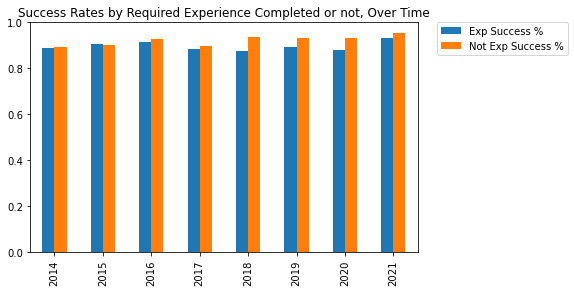

In [326]:
# FOREIGN WORKER REQ EXPERIENCE MET? THERE WILL BE SOME 0 due to N/A or missing
# FOREIGN WORKER REQ EXPERIENCE COMPLETED? THERE WILL BE A LOT 0 DUE TO N/A or missing 
# PLOTTING THE DIFFERENT SUCCESS RATES OVER TIME BY TRAINING COMPLETE or not/not applicable (IN TERMS OF ANNUAL APPLICATIONS)

top15 = df[df["FOREIGN_WORKER_REQ_EXPERIENCE"]==1]
not15 = df[df["FOREIGN_WORKER_REQ_EXPERIENCE"]==0]

topdf = pd.DataFrame()
notdf = pd.DataFrame()
analysisdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(top15[(top15["YEAR"]==yr[x])&(top15["CASE_STATUS"]==1)])/len(top15[top15["YEAR"]==yr[x]])])
    b = pd.DataFrame([len(not15[(not15["YEAR"]==yr[x])&(not15["CASE_STATUS"]==1)])/len(not15[not15["YEAR"]==yr[x]])])
    topdf = pd.concat([topdf,j])
    notdf = pd.concat([notdf,b])
    analysisdf = pd.concat([topdf,notdf], axis = 1)

analysisdf.index = yr
analysisdf.columns = ["Exp Success %", "Not Exp Success %"]
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Required Experience Completed or not, Over Time")

Text(0.5, 1.0, 'Application Rates by Required Experience Completed or not, Over Time')

<Figure size 1200x1000 with 0 Axes>

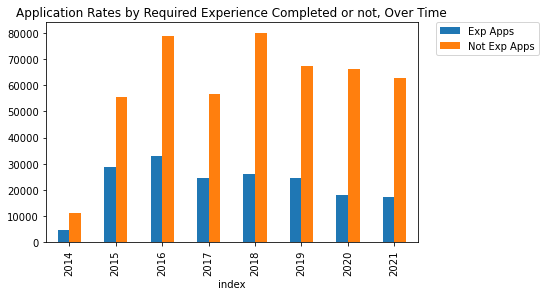

In [327]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
top15apps = []
not15apps = []

for x in range(len(yr)):
    t = (top15["YEAR"]==yr[x]).sum()
    n = (not15["YEAR"]==yr[x]).sum()
    top15apps.append(t)
    not15apps.append(n)
analysisdf = analysisdf.reset_index()
analysisdf["Exp Apps"] = pd.DataFrame(top15apps)
analysisdf["Not Exp Apps"] = pd.DataFrame(not15apps)
analysisdf = analysisdf.set_index("index")
# PLOTTING APPLICATION RATES OVER TIME BY TOP 15 or NOT TOP 15
plt.figure(figsize = (12,10), dpi = 100)
analysisdf.reset_index().plot(x = "index", y = ["Exp Apps","Not Exp Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Required Experience Completed or not, Over Time")

In [328]:
# P VALUE PER YEAR: ON THE SUCCESS RATE
top_not = []
for x in range(len(yr)):
    sample1_phat = analysisdf.loc[yr[x]]["Exp Success %"]
    sample2_phat = analysisdf.loc[yr[x]]["Not Exp Success %"]
    sample1_size = analysisdf.loc[yr[x]]["Exp Apps"]
    sample2_size = analysisdf.loc[yr[x]]["Not Exp Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    top_not.append(pval)

pvaldf = pd.DataFrame(top_not)
pvaldf.columns = ["Exp Vs. Not Exp"]
pvaldf.index = yr
analysisdf["PVAL Success %"] = pvaldf["Exp Vs. Not Exp"]

In [329]:
# LINEAR REGRESSION BETWEEN Experience Required Completed AND SUCCESS RATE OVER TIME
print("Exp success rate over time:",st.linregress(y = analysisdf["Exp Success %"], x = yr))
print("\nExp applications over time:",st.linregress(y = analysisdf["Exp Apps"], x = yr))

print("\n\nNot Exp success rate over time:",st.linregress(y = analysisdf["Not Exp Success %"], x = yr))
print("\nNot Exp applications over time:",st.linregress(y = analysisdf["Not Exp Apps"], x = yr))

Exp success rate over time: LinregressResult(slope=0.0013218065620068426, intercept=-1.769613688072996, rvalue=0.16739987818208385, pvalue=0.6919396826736646, stderr=0.003178082724915437, intercept_stderr=6.411786032567434)

Exp applications over time: LinregressResult(slope=109.14285714285714, intercept=-198099.9642857143, rvalue=0.030640599875707466, pvalue=0.9425848236247963, stderr=1453.511479692761, intercept_stderr=2932461.3014654755)


Not Exp success rate over time: LinregressResult(slope=0.007542319270575872, intercept=-14.29545492481593, rvalue=0.8518725985381942, pvalue=0.0072494715710869255, stderr=0.0018931189085312939, intercept_stderr=3.8193698611269573)

Not Exp applications over time: LinregressResult(slope=4757.785714285715, intercept=-9539083.42857143, rvalue=0.5405272943925864, pvalue=0.16661556214753842, stderr=3023.2647571706507, intercept_stderr=6099440.581206375)


In [330]:
# GETTING THE TOTAL PVAL
analysisdf.loc["ALL YRS"] = analysisdf.sum()
top15suc = []
not15suc = []

for x in range(len(yr)):
    t15 = analysisdf.loc[yr[x]].iloc[0]*analysisdf.loc[yr[x]].iloc[2]
    n15 = analysisdf.loc[yr[x]].iloc[1]*analysisdf.loc[yr[x]].iloc[3]
    top15suc.append(t15)
    not15suc.append(n15)
analysisdf.loc["ALL YRS"].iloc[0] = sum(top15suc)/analysisdf.loc["ALL YRS"].iloc[2]
analysisdf.loc["ALL YRS"].iloc[1] = sum(not15suc)/analysisdf.loc["ALL YRS"].iloc[3]


for x in range(len(yr)):
    sample1_phat = analysisdf.loc["ALL YRS"].iloc[0]
    sample2_phat = analysisdf.loc["ALL YRS"].iloc[1]
    sample1_size = analysisdf.loc["ALL YRS"].iloc[2]
    sample2_size = analysisdf.loc["ALL YRS"].iloc[3]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
analysisdf.loc["ALL YRS"].iloc[4] = pval

analysisdf = analysisdf.head(9).style.format("{:,.2f}")
analysisdf

,Exp Success %,Not Exp Success %,Exp Apps,Not Exp Apps,PVAL Success %
index,,,,,
2014,0.89,0.89,"4,788.00","11,211.00",0.63
2015,0.91,0.90,"28,707.00","55,608.00",0.00
2016,0.91,0.93,"32,999.00","78,779.00",0.00
2017,0.89,0.90,"24,398.00","56,736.00",0.00
2018,0.88,0.94,"26,207.00","79,937.00",0.00
2019,0.89,0.93,"24,628.00","67,187.00",0.00
2020,0.88,0.93,"17,875.00","66,003.00",0.00
2021,0.93,0.95,"17,164.00","62,533.00",0.00
ALL YRS,0.90,0.93,"176,766.00","477,994.00",0.00


In [331]:
# DIVING DEEPER INTO Experience Required 
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

code = 1
# CHANGE THIS FOR ANY CODE

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY PW LEVEL
topstate = df[df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf = codestatedf.set_index(["STATE","PW LEVEL"])
codestatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
CA    LEVEL I                 4658     83844.6                  7.0   
      LEVEL II               12431    109554.0                  6.0   
      LEVEL III               7085    121118.0                  9.0   
      LEVEL IV               11259    137000.0                 12.0   
TX    LEVEL I                 2303     60320.0                  8.0   
      LEVEL II               12645     72946.0                  9.0   
      LEVEL III               5205     75878.0                 10.0   
      LEVEL IV               15056     81765.0                 11.0   
NJ    LEVEL I                 1393     70000.0                 10.0   
      LEVEL II                8226     85871.5                 10.0   
      LEVEL III               5686    103626.0                 11.0   
      LEVEL IV                5331    121500.0                 12.0   
NY    LEVEL I                 1808     67154.5                  7.0   
      LEVEL II                3282     91926.5                  8.0   
      LEVEL III               2274    105227.0                 11.0   
      LEVEL IV                2579    117811.0                 12.0   
FL    LEVEL I                 1696     55494.0                 10.0   
      LEVEL II                2969     74880.0                 10.0   
      LEVEL III               1698     72051.0                 12.0   
      LEVEL IV                2059     98821.0                 13.0   
MI    LEVEL I                  722     72000.0                  8.0   
      LEVEL II                2798     78052.0                  8.0   
      LEVEL III               2303     86715.0                 10.0   
      LEVEL IV                1528    101733.0                 12.0   
PA    LEVEL I                  467     66456.0                  7.0   
      LEVEL II                1751     79352.0                  9.0   
      LEVEL III               1181     97406.0                 10.0   
      LEVEL IV                2307    101712.0                 11.0   
IL    LEVEL I                  634     64850.0                  7.0   
      LEVEL II                1712     77469.0                  8.0   
      LEVEL III               1257     81619.0                  9.0   
      LEVEL IV                1655    105102.0                 12.0   
VA    LEVEL I                  736     70283.0                  8.0   
      LEVEL II                1573     90646.0                  8.0   
      LEVEL III               1136    106787.0                  8.0   
      LEVEL IV                1449    125757.0                 12.0   
MA    LEVEL I                  376     76398.0                  6.0   
      LEVEL II                1217     90646.0                  7.0   
      LEVEL III               1865    107890.0                 10.0   
      LEVEL IV                1406    122450.0                 11.0   
GA    LEVEL I                  469     61000.0                  8.0   
      LEVEL II                1044     80000.0                  8.0   
      LEVEL III                642     90850.0                  9.0   
      LEVEL IV                1299    111384.0                 12.0   
OR    LEVEL I                   96     75708.5                  6.0   
      LEVEL II                 821     86195.0                  4.0   
      LEVEL III                969     42869.0                  9.5   
      LEVEL IV                 834    113439.0                 12.0   
WA    LEVEL I                  302     85426.0                  7.0   
      LEVEL II                1188    107000.0                  9.0   
      LEVEL III                414    122533.0                  9.0   
      LEVEL IV                 984    129000.0                 11.0   
OH    LEVEL I                  416     47795.0                  7.0   
      LEVEL II                 806     74194.0                  7.0   
      LEVEL III                426     8

In [332]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(edu)):
        a = len(df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"] == code)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
codestatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
codestatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
codestatedf1 = codestatedf1.set_index(["STATE","EDU LEVEL"])
codestatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
CA    HIGH SCHOOL                758     38178.5                 20.0   
      ASSOCIATE'S                369     62608.0                 15.0   
      BACHELOR'S               13779   123484.82                 12.0   
      MASTER'S                 18715    120349.0                  6.0   
      DOCTORATE                  966    130000.0                  5.0   
...                              ...         ...                  ...   
MD    ASSOCIATE'S                 26     40456.0                  5.5   
      BACHELOR'S                 645     93500.0                 12.0   
      MASTER'S                   985     95000.0                  7.0   
      DOCTORATE                   32    96042.78                  4.0   
      OTHER                       26     68850.5                 12.5   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
CA    HIGH SCHOOL                 193.0  
      ASSOCIATE'S                 203.0  
      BACHELOR'S                  136.0  
      MASTER'S               133.497164  
      DOCTORATE                   138.0  
...                                 ...  
MD    ASSOCIATE'S            231.941453  
      BACHELOR'S                  141.0  
      MASTER'S                    141.0  
      DOCTORATE                   144.5  
      OTHER                       152.5  

[90 rows x 4 columns]

In [333]:
# THAT IS ODD... LETS SEE WHAT KIND OF EMPLOYER HAS REQUIRED EXPERIENCE
# PW SKILL DISTRIBUTION OF EXP REQ... DOESNT MAKE SENSE...
df[df["FOREIGN_WORKER_REQ_EXPERIENCE"]==1]["PW_SKILL_LEVEL"].value_counts()

LEVEL II     59210
LEVEL IV     56142
LEVEL III    37061
LEVEL I      19825
Name: PW_SKILL_LEVEL, dtype: int64

In [334]:
df[df["FOREIGN_WORKER_REQ_EXPERIENCE"]==1]["NAICS_CODE"].value_counts()[:5]
#541511 and 541512 are computer systems and software related

541511    53266
541512    26091
541519     5345
3344       5011
541330     3860
Name: NAICS_CODE, dtype: int64

In [335]:
# TOP JOB CODE IS SOFTWARE DEVELOPER... 
df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"]==1)&(df["PW_SKILL_LEVEL"]=="LEVEL II")]["PW_SOC_CODE"].value_counts()[:5]

15-1132    22828
15-1121     8288
15-1133     4024
53-3032     1960
17-2072     1934
Name: PW_SOC_CODE, dtype: int64

In [336]:
# TOP JOB CODE IS SOFTWARE DEVELOPER... 
df[(df["FOREIGN_WORKER_REQ_EXPERIENCE"]==1)&(df["PW_SKILL_LEVEL"]=="LEVEL IV")]["PW_SOC_CODE"].value_counts()[:5]

15-1132    25983
15-1121     7054
15-1133     3235
15-1199     2020
35-2014     1930
Name: PW_SOC_CODE, dtype: int64

In [337]:
# SUCCESS RATE FOR THE TOP 2 NAICS CODES vs the rest of naics codes: drop off is not so steep..
reqtrain = df[df["FOREIGN_WORKER_REQ_EXPERIENCE"]==1]
print("SUCCESS RATE FOR TOP 2:",reqtrain[(reqtrain["NAICS_CODE"] == "541511")|(reqtrain["NAICS_CODE"] == "541512")]["CASE_STATUS"].sum()/len(reqtrain[(reqtrain["NAICS_CODE"] == "541511")|(reqtrain["NAICS_CODE"] == "541512")]))
print("SUCCESS RATE FOR THE REST:",reqtrain[(reqtrain["NAICS_CODE"] != "541511")&(reqtrain["NAICS_CODE"] != "541512")]["CASE_STATUS"].sum()/len(reqtrain[(reqtrain["NAICS_CODE"] != "541511")&(reqtrain["NAICS_CODE"] != "541512")]))

SUCCESS RATE FOR TOP 2: 0.9378378718953589
SUCCESS RATE FOR THE REST: 0.8654128468621995


In [338]:
# SUCCESS RATE FOR top 3 job codes
reqtrain = df[df["FOREIGN_WORKER_REQ_EXPERIENCE"]==1]
print("SUCCESS RATE FOR TOP 3:",reqtrain[(reqtrain["PW_SOC_CODE"] == "15-1132")|(reqtrain["PW_SOC_CODE"] == "15-1121")|(reqtrain["PW_SOC_CODE"] == "15-1133")]["CASE_STATUS"].sum()/len(reqtrain[(reqtrain["PW_SOC_CODE"] == "15-1132")|(reqtrain["PW_SOC_CODE"] == "15-1121")|(reqtrain["PW_SOC_CODE"] == "15-1133")]))
print("SUCCESS RATE FOR THE REST:",reqtrain[(reqtrain["PW_SOC_CODE"] != "15-1132")&(reqtrain["PW_SOC_CODE"] != "15-1121")&(reqtrain["PW_SOC_CODE"] != "15-1133")]["CASE_STATUS"].sum()/len(reqtrain[(reqtrain["PW_SOC_CODE"] != "15-1132")&(reqtrain["PW_SOC_CODE"] != "15-1121")&(reqtrain["PW_SOC_CODE"] != "15-1133")]))

SUCCESS RATE FOR TOP 3: 0.9435564587061357
SUCCESS RATE FOR THE REST: 0.8399547865849742


In [339]:
# CREATING A NEW COLUMN: SPLITTING THE APPLICANT's EDUCATION LEVEL INTO 4 GROUPS
df["EDU_GROUP"] = np.nan
for x in range(len(yr)):
    df["EDU_GROUP"] = np.where((df["FOREIGN_WORKER_EDUCATION"]=="HIGH SCHOOL")|(df["FOREIGN_WORKER_EDUCATION"]=="ASSOCIATE'S"),"LOWER",df["EDU_GROUP"])
    df["EDU_GROUP"] = np.where(df["FOREIGN_WORKER_EDUCATION"]=="BACHELOR'S","COLLEGE",df["REQ_EDU_GROUP"])
    df["EDU_GROUP"] = np.where((df["FOREIGN_WORKER_EDUCATION"]=="MASTER'S")|(df["FOREIGN_WORKER_EDUCATION"]=="DOCTORATE"),"UPPER",df["EDU_GROUP"])
    df["EDU_GROUP"] = np.where((df["FOREIGN_WORKER_EDUCATION"].isnull())|(df["FOREIGN_WORKER_EDUCATION"]=="OTHER"),"OTHER",df["EDU_GROUP"])

In [340]:
# DROPPING ALL #VALUE!
listy = df.columns.tolist()
for x in range(len(listy)):
    df = df[df[listy[x]]!="#VALUE!"]

In [341]:
##############################################################################

In [343]:
#### PREPARING THE DATA FOR MACHINE LEARNING ###
# DROPPING THE COLUMNS NOT USED FOR ML
model = df[['CASE_STATUS',
'DAYS_TO_DECIDE',
'REFILE',
'EMPLOYER_STATE_PROVINCE',
'EMPLOYER_COUNTRY',
'EMPLOYER_NUM_EMPLOYEES',
'EMPLOYER_YEAR_COMMENCED_BUSINESS',
'PW_SOC_CODE',
'PW_SKILL_LEVEL',
'PW_DURATION',
'APP_TO_PW_DETERMINE',
'WAGE_OFFER_UNIT_OF_PAY',
'WORKSITE_STATE',
'REQUIRED_TRAINING',
'REQUIRED_EXPERIENCE',
'ACCEPT_FOREIGN_EDUCATION',
'ACCEPT_ALT_OCCUPATION',
'JOB_OPP_REQUIREMENTS_NORMAL',
'FOREIGN_LANGUAGE_REQUIRED',
'PROFESSIONAL_OCCUPATION',
'SWA_DURATION',
'FIRST_AD_TO_APP_DAYS',
'SECOND_AD_TO_APP_DAYS',
'JOB_FAIR',
'ON_CAMPUS_RECRUITING',
'EMPLOYER_WEBSITE',
'PRO_ORG_AD',
'JOB_SEARCH_WEBSITE','EMPLOYEE_REF_PROG',
'CAMPUS_PLACEMENT',
'LOCAL_ETHNIC_PAPER',
'RADIO_TV_AD',
'CLASS_OF_ADMISSION',
'FOREIGN_WORKER_YRS_ED_COMP',
'FOREIGN_WORKER_TRAINING_COMP',
'FOREIGN_WORKER_REQ_EXPERIENCE',
'FOREIGN_WORKER_ALT_ED_EXP',
'FOREIGN_WORKER_ALT_OCC_EXP',
'MONTH',
'YEAR',
'WO_A',
'PW_A',
'WO-PW',
'WORKSITE_REGION',
'EMPLOYER_REGION',
'DISC_ST',
'DISC_CTY',
'DISC_RGION',
'DISC_UNIT',
'YRSPOSTGRAD',
'EMPLOYER_SIZE',
'EMPLOYER_AGE',
'REQ_EDU_GROUP',
'EDU_GROUP']]

In [344]:
# CUSTOM DUMMY VARIABLES FOR MODEL DF
model["H1L1F1"] = np.where((model["CLASS_OF_ADMISSION"]=="L-1")|(model["CLASS_OF_ADMISSION"]=="F-1")|(model["CLASS_OF_ADMISSION"]=="H-1B"),1,0)
model = model.drop("CLASS_OF_ADMISSION", axis = 1)
model["PW_SOC_CODE"] = model["PW_SOC_CODE"].str[:2]
model = pd.concat([model,pd.get_dummies(model["PW_SOC_CODE"], drop_first = True)],axis = 1).drop("PW_SOC_CODE",axis = 1)
model["cosM"] = np.cos(model["MONTH"]*2*np.pi/12)
model["sinM"] = np.sin(model["MONTH"]*2*np.pi/12)
model = model.drop("MONTH",axis = 1)

In [345]:
dummy = ['EMPLOYER_STATE_PROVINCE',
'EMPLOYER_COUNTRY',
'PW_SKILL_LEVEL',
'WAGE_OFFER_UNIT_OF_PAY',
'WORKSITE_STATE',
'WORKSITE_REGION',
'EMPLOYER_REGION',
'EMPLOYER_SIZE',
'EMPLOYER_AGE',
'REQ_EDU_GROUP',
'EDU_GROUP']

for x in range(len(dummy)):
    model = pd.concat([model,pd.get_dummies(model[dummy[x]], drop_first = True)],axis = 1).drop(dummy[x],axis = 1)

In [346]:
model.to_csv("model.csv", index = False)